# Miles in the Sky Data Science Course - Final Project "Intro to Machine Learning"

This repository is part of the learning objectives of the [Data Science Course](https://milesinthesky.education/programs-by-miles/) provided by Miles in the Sky.

## Table of Contents

- [Project Description](#Project-Description)

- [The Dataset](#The-Dataset)

- [Simple Exponential Smoothing (SES)](#Simple-Exponential-Smoothing-(SES))

- [Triple Exponential Smoothing (ETS)](#Triple-Exponential-Smoothing-(ETS))

- [Stationarity](#Stationarity)

- [Auto Regressive Integrated Moving Average (ARIMA)](#Auto-Regressive-Integrated-Moving-Average-(ARIMA))

- [SARIMA](#SARIMA)

- [Prophet](#Prophet)

- [Outro](#Outro)

# Project Description

The main aim of this project was to use different modelling and forecasting techniques in time series. The following were compared: Simple Exponential Smoothing, Triple Exponential Smoothing, Stationarity, ARIMA, SARIMA, SARIMA Exogenous and Prophet.

These comparisons took into account the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error) values presented by each of the models, in order to see which one performed best for this task. Over this project we will be calculating, storing and outputting both for comparison but will go with the RMSE when performing hyperparameter optimization.

This data set contains the number of website visits generated on a Business to Business (B2B) corporate website as well as purchases made by date. As a B2B company, the clients are organizations, not individual customers and the purchase has substantial associated cost.

More details about this project can be found in the README of the repository containing this notebook.

## Content

Attribute information of  [ts_data.csv](https://miles-become-a-data-scientist.s3.us-east-2.amazonaws.com/J2/M7/ts_data.csv):

. `date`: The date. Datetime. The year, day and month in which the website visits and purchases took place;

. `nbr_website_visits`: The number of website visits. Integer. The number of new online visits registered on each date;

. `nbr_purchases`: The number of purchases. Integer. The number of new purchases generated on each date.

## Import the Packages

In [ ]:
!pip install pmdarima
!pip install prophet
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import prophet

import warnings     # for ignoring warnings
warnings.filterwarnings('ignore')

import pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# The Dataset

In [ ]:
#Loading the Dataset in this cell
df = pd.read_csv('https://miles-become-a-data-scientist.s3.us-east-2.amazonaws.com/J2/M7/ts_data.csv')

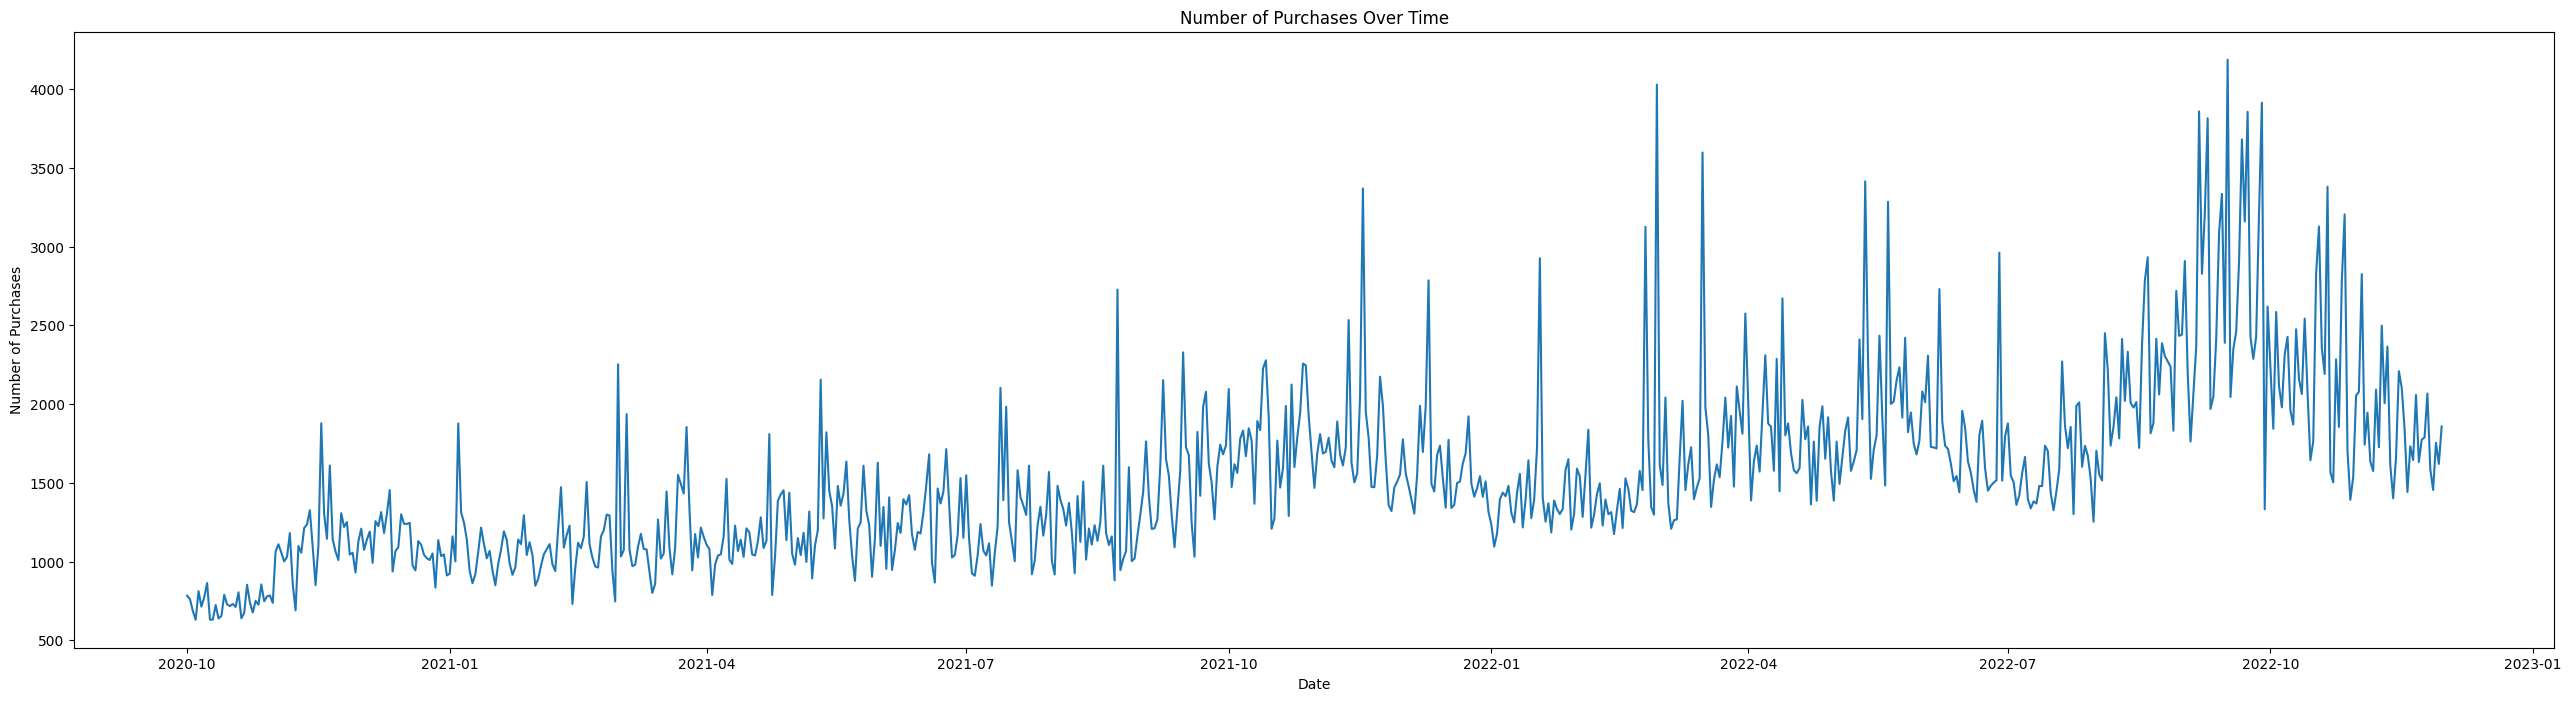

In [ ]:
#Converting to datetime
df['date'] = pd.to_datetime(df.date,format='%Y-%d-%m')
#Set index and frequency
df = df.set_index('date')
df = df.asfreq(freq='d')

#Features of date
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['ym'] = df.index.strftime('%Y-%m')
df['week'] = df.index.isocalendar().week
df['week_day'] = df.index.day_name()

df.loc['2021-01-06'].week_day

#Plot of nbr_purchases
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases)
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases Over Time')
plt.show()

## Split in Train/Test

In [ ]:
df_train = df.loc[:'2022-10-31'].copy()
df_test = df.loc['2022-11-01':].copy()

## Baseline Models

In [ ]:
#Mean
purchases_mean = df_train.nbr_purchases.mean()
df_test['prediction_mean'] = purchases_mean
print(f'RMSE of Mean method is {np.sqrt(mean_squared_error(df_test.nbr_purchases,df_test.prediction_mean)):.2f}')
print(f'MAPE of Mean method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases,df_test.prediction_mean)):.2f}%')
print()
#Moving Average
purchases_ma_8 = df_train.nbr_purchases.rolling(8,closed='left').mean().iloc[-1]
df_test['prediction_naive_ma'] = purchases_ma_8
print(f'RMSE of Moving Average method is {np.sqrt(mean_squared_error(df_test.nbr_purchases,df_test.prediction_naive_ma)):.2f}')
print(f'MAPE of Moving Average method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases,df_test.prediction_naive_ma)):.2f}%')
print()
#Naive
purchases_naive = df_train.nbr_purchases.iloc[-1]
df_test['prediction_naive'] = purchases_naive
print(f'RMSE of Naive method is {np.sqrt(mean_squared_error(df_test.nbr_purchases,df_test.prediction_naive)):.2f}')
print(f'MAPE of Naive method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases,df_test.prediction_naive)):.2f}%')
print()
#Seasonal Naive
df_test['prediction_snaive'] = df_test.week_day.map(dict(zip(df_train.iloc[-7:].week_day,df_train.iloc[-7:].nbr_purchases)))
print(f'RMSE of Seasonal Naive method is {np.sqrt(mean_squared_error(df_test.nbr_purchases,df_test.prediction_snaive)):.2f}')
print(f'MAPE of Seasonal Naive method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases,df_test.prediction_snaive)):.2f}%')

RMSE of Mean method is 459.79
MAPE of Mean method is 16.90%

RMSE of Moving Average method is 364.27
MAPE of Moving Average method is 17.67%

RMSE of Naive method is 374.84
MAPE of Naive method is 18.27%

RMSE of Seasonal Naive method is 615.20
MAPE of Seasonal Naive method is 23.79%


MAE and RMSE seem to be moving in tandem. But MAPE is worse on the Moving Average or Naive methods than the Mean one, despite both having vastly better MAE/RMSE results than the Mean one.

RMSE is a metric that will give larger importance to larger errors. This means it can be affected by outliers if there are many on the data. The resulting value is in the same scale as the actual observations which allows for easier interpretation of the model's performance.

MAPE on the other hand divides de error by the actual observation value. This means that is in an independent percentual scale which is easily read and interpreted. The downside is that if the actual values vary over time (for example with a positive trend), it may give more importance to errors made on observations with small actual values than on days with larger actuals. Additionally it can produce infinite values when the actual observations have values of, or close to, zero. Finally it will penalize negative errors more than positive ones.

# Simple Exponential Smoothing (SES)

SES or Simple Exponential Smoothing is a simple method that often performs very well. It is an expansion of the moving average concept that adds weights to each observation, giving more importance to recent observations than past ones. This is controlled by the smoothing level hyperparameter that can have any value between 0 and 1.

If we set the value to 0 we will consider the entire training set equally to calculate the average, that is, we will calculate the mean over the entire training data set and make predictions with that value.

If the value is 1 than we will only consider the last value to make forecasts, that is we will have the Naive method.

Let's see what happens when the smoothing level is set to 0.

**What method does this correspond to?**

RMSE of Simple Exponential Smoothing method is 459.79
MAPE of Simple Exponential Smoothing method is 16.90%


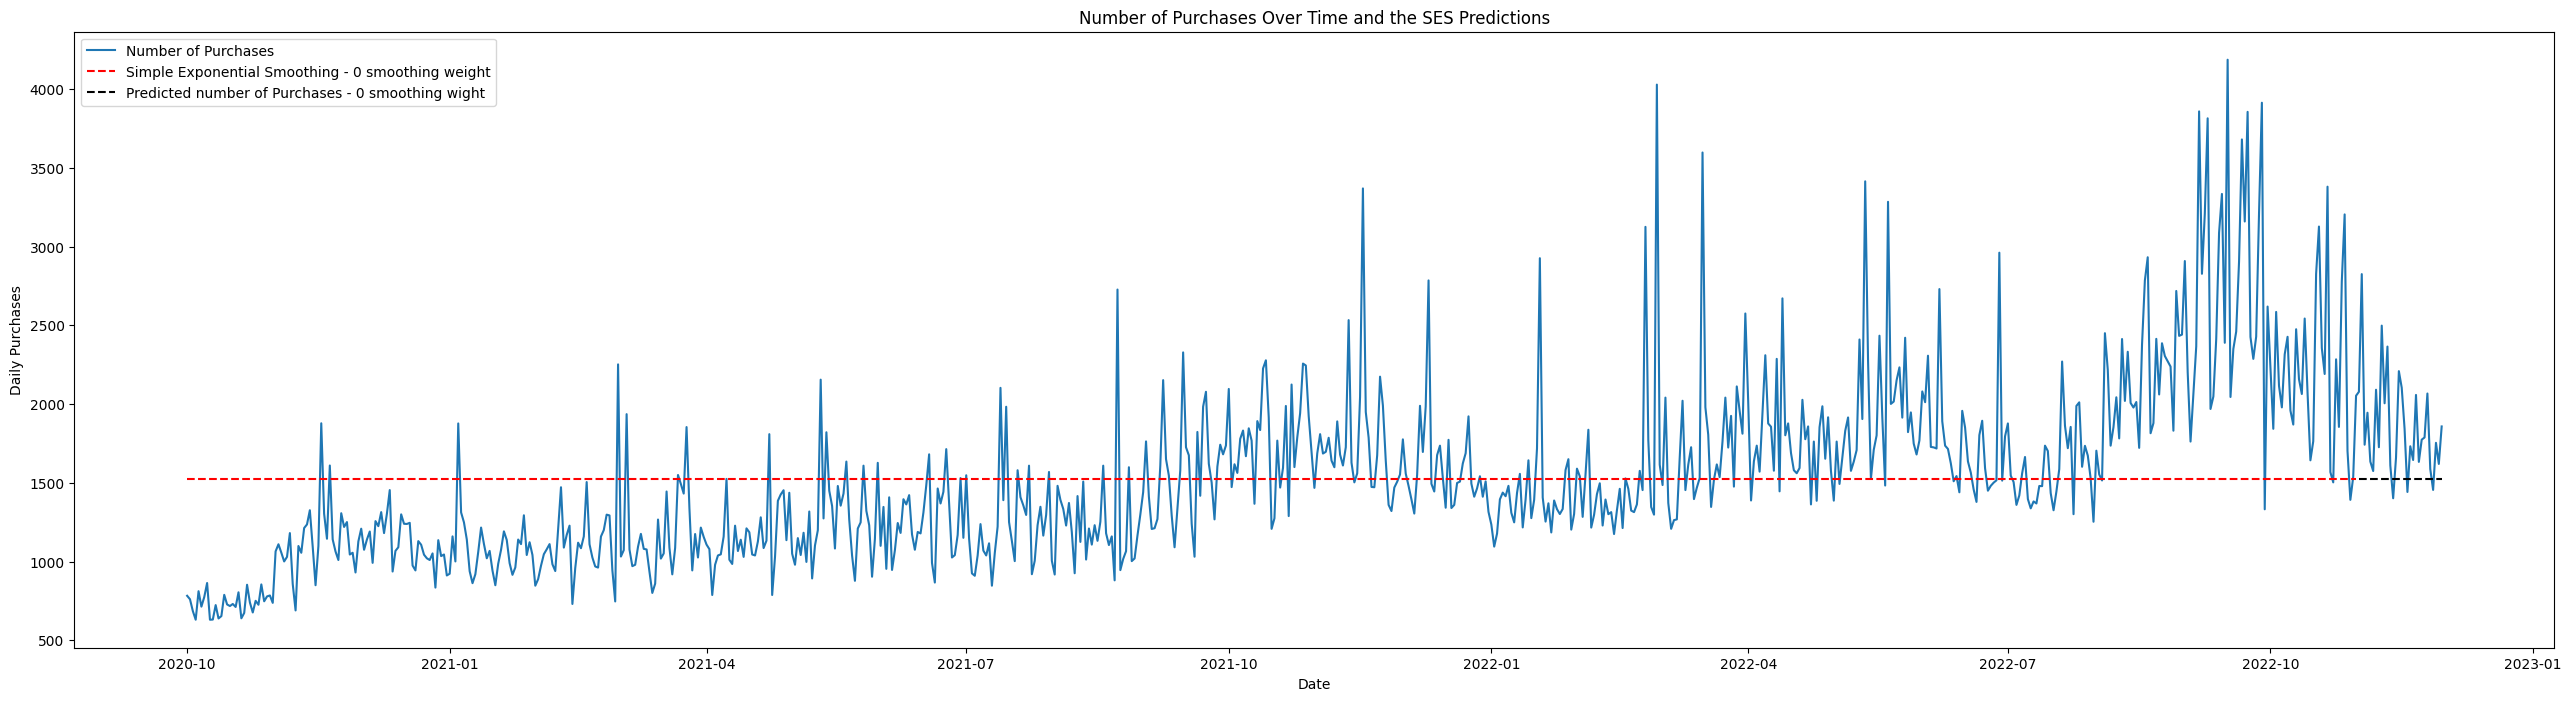

In [ ]:
#Fitting with extreme levels to illustrate difference - 0
ses = SimpleExpSmoothing(df_train.nbr_purchases)
model = ses.fit(smoothing_level = 0)

#Making forecasts and store them in preds_ses. Printing the RMSE/MAPE.
preds_ses = model.forecast(30)
print(f'RMSE of Simple Exponential Smoothing method is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ses)):.2f}')
print(f'MAPE of Simple Exponential Smoothing method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ses)):.2f}%')

#Creating plot of the SES forecasts on the entire dataset
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Number of Purchases')
plt.plot(model.fittedvalues,
         color='red',
         linestyle='--',
         label='Simple Exponential Smoothing - 0 smoothing weight')
plt.plot(preds_ses,
         color='black',
         linestyle='--',
         label='Predicted number of Purchases - 0 smoothing wight')
plt.xlabel('Date')
plt.ylabel('Daily Purchases')
plt.title('Number of Purchases Over Time and the SES Predictions')
plt.legend()
plt.show()

**This corresponds to the Mean Method.**

I'll repeat the same steps but using a smoothing level of 1.

**What method does this correspond to?**

RMSE of Simple Exponential Smoothing method is 374.84
MAPE of Simple Exponential Smoothing  method is 18.27%


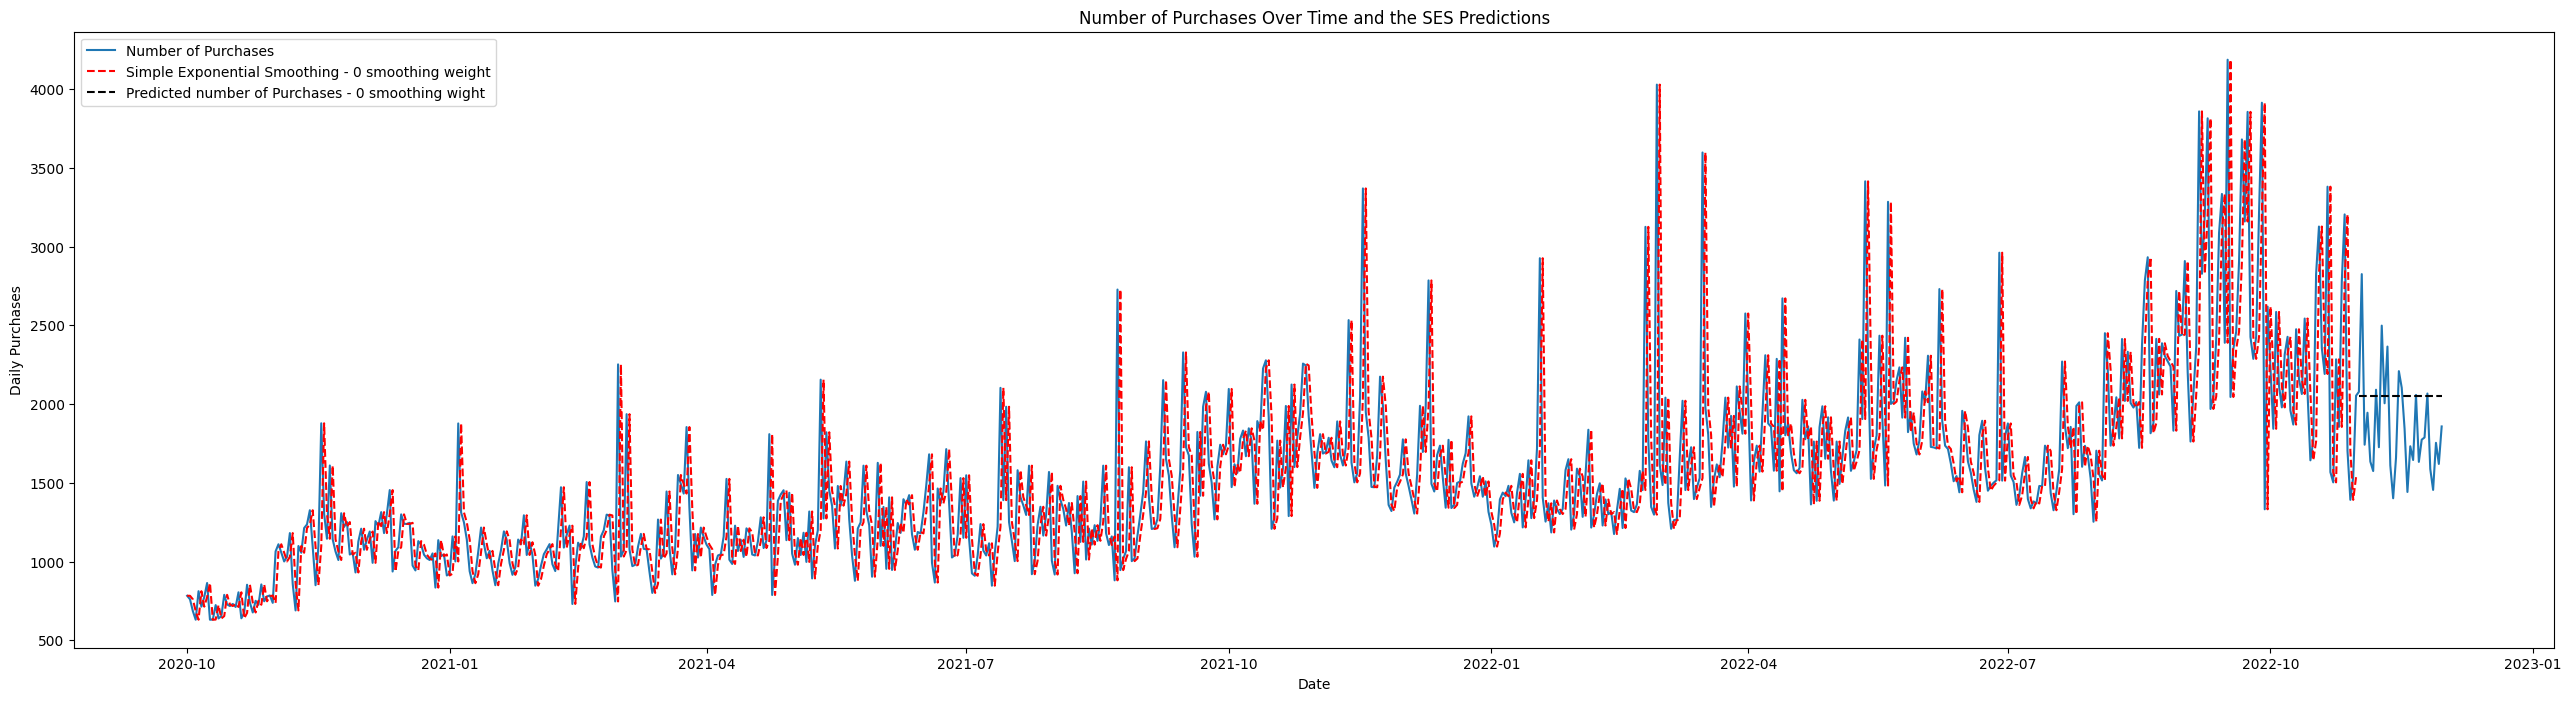

In [ ]:
#Fitting with extreme levels to illustrate difference - 1
ses = SimpleExpSmoothing(df_train.nbr_purchases)
model = ses.fit(smoothing_level = 1)

#Making forecasts and store them in preds_ses. Print the RMSE/MAPE.
preds_ses = model.forecast(30)
print(f'RMSE of Simple Exponential Smoothing method is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ses)):.2f}')
print(f'MAPE of Simple Exponential Smoothing  method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ses)):.2f}%')

#Creating plot of the SES forecasts on the entire dataset
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Number of Purchases')
plt.plot(model.fittedvalues,
         color='red',
         linestyle='--',
         label='Simple Exponential Smoothing - 0 smoothing weight')
plt.plot(preds_ses,
         color='black',
         linestyle='--',
         label='Predicted number of Purchases - 0 smoothing wight')
plt.xlabel('Date')
plt.ylabel('Daily Purchases')
plt.title('Number of Purchases Over Time and the SES Predictions')
plt.legend()
plt.show()

**This corresponds to the Naive Method.**

I will now look for the optimal hyperparameter which will likely be somewhere between 0 and 1.

The SimpleExpSmoothing is capable of looking for the best hyperparameter by itself. I only have to use the "estimated" initialization method for that!

I'll train the model on the training set with this method and then check the RMSE and MAPE on the Training set as well as the Test set.

In [ ]:
#Initializing and fittting a SES allowing Statsmodels to look for best hyperparameter by itself
ses = SimpleExpSmoothing(df_train.nbr_purchases,
                         initialization_method='estimated')
model = ses.fit()

#Make forecasts, print the optimal smoothing level found and the RMSE/MAPE performance on training and test sets.
preds_ses = model.forecast(30)
print(f'The optimal smoothing level is {model.model.params["smoothing_level"]:.2f}')
print()
print(f'RMSE of df_train Simple Exponential Smoothing method is {np.sqrt(mean_squared_error(df_train.nbr_purchases, model.fittedvalues)):.2f}')
print(f'MAPE of df_train Simple Exponential Smoothing  method is {100*(mean_absolute_percentage_error(df_train.nbr_purchases, model.fittedvalues)):.2f}%')
print()
print(f'RMSE of df_test Simple Exponential Smoothing method is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ses)):.2f}')
print(f'MAPE of df_test Simple Exponential Smoothing  method is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ses)):.2f}%')

The optimal smoothing level is 0.12

RMSE of df_train Simple Exponential Smoothing method is 365.32
MAPE of df_train Simple Exponential Smoothing  method is 15.04%

RMSE of df_test Simple Exponential Smoothing method is 405.53
MAPE of df_test Simple Exponential Smoothing  method is 20.23%


**How well fit is this model?**

Given that I will be performing a hyperparameter optimization, I might want to evaluate that search process on validation folds and not on the test set to make sure that I have found the best option for a model that generalizes well!


In [ ]:
#Expanding windows. I'll save 6 30 day periods for validation and the remaining for training
#The result should be a list of tuples, each tuple containing the training and validation indexes.
list_splits = []
for i in range(6):
  if i == 0:
    list_splits.append((df_train.iloc[:-30].nbr_purchases,
                        df_train.iloc[-30:].nbr_purchases))
  else:
    list_splits.append((list_splits[i-1][0].iloc[:-30],
                        list_splits[i-1][0].iloc[-30:]))

In [ ]:
#Finding the performance on the 6 expanding windows cross validation set.
list_params = [i/40 for i in range(0, 41)]
results = {'smoothing_level':[],
           'train_rmse':[],
           'val_rmse':[],
           'train_mape':[],
           'val_mape':[]}
for i in list_params:
  list_rmse_train = []
  list_rmse_val = []
  list_mape_train = []
  list_mape_val = []
  for (train,val) in list_splits:
    ses = SimpleExpSmoothing(train,
                          initialization_method=None).fit(smoothing_level=i)
    preds_tmp = ses.forecast(30)
    rmse_tmp_train = np.sqrt(mean_squared_error(train,ses.fittedvalues))
    mape_tmp_train = 100*(mean_absolute_percentage_error(train,ses.fittedvalues))
    list_rmse_train.append(rmse_tmp_train)
    list_mape_train.append(mape_tmp_train)
    rmse_tmp_val = np.sqrt(mean_squared_error(val,preds_tmp))
    mape_tmp_val = 100*(mean_absolute_percentage_error(val,preds_tmp))
    list_rmse_val.append(rmse_tmp_val)
    list_mape_val.append(mape_tmp_val)

  mean_rmse_train = np.mean(list_rmse_train)
  mean_rmse_val = np.mean(list_rmse_val)
  mean_mape_train = np.mean(list_mape_train)
  mean_mape_val = np.mean(list_mape_val)
  #Store smoothing levels
  results['smoothing_level'].append(i)
  #Calculate and store training RMSE
  results['train_rmse'].append(mean_rmse_train)
  #Calculate and store val RMSE
  results['val_rmse'].append(mean_rmse_val)
  #Calculate and store training MAPE
  results['train_mape'].append(mean_mape_train)
  #Calculate and store val MAPE
  results['val_mape'].append(mean_mape_val)

  #Print the mean RMSE + MAPE values on each trial
  print(f"On the Training sets, for Smoothing level {i} the RMSE is {mean_rmse_train:.2f}")
  print(f"On the Training sets, for Smoothing level {i} the MAPE is {mean_mape_train:.2f}%")
  print(f"On the Validation sets, for Smoothing level {i} the RMSE is {mean_rmse_val:.2f}")
  print(f"On the Validation sets, for Smoothing level {i} the MAPE is {mean_mape_val:.2f}%")
  print()

#Store the results in df_ses. Identify the best performers on the training folds and validation folds based on RMSE and MAPE.
df_ses = pd.DataFrame(results)
best_performer_train_rmse = df_ses.iloc[df_ses.train_rmse.idxmin()]
best_performer_val_rmse = df_ses.iloc[df_ses.val_rmse.idxmin()]
best_performer_train_mape = df_ses.iloc[df_ses.train_mape.idxmin()]
best_performer_val_mape = df_ses.iloc[df_ses.val_mape.idxmin()]

#Print the best smoothing level and RMSE when considering the training set and then the test set.
print('Focusing on RMSE:')
print(f"""Considering the lowest RMSE on the training folds:
            - The best smoothing level was {best_performer_train_rmse.smoothing_level};
            - The training RMSE was {best_performer_train_rmse.train_rmse:.2f};
            - The validation RMSE was {best_performer_train_rmse.val_rmse:.2f};
            - The training MAPE was {best_performer_train_rmse.train_mape:.2f}%;
            - The validation MAPE was {best_performer_train_rmse.val_mape:.2f}%""")
print()
print(f"""Considering the lowest RMSE on the validation folds:
            - The best smoothing level was {best_performer_val_rmse.smoothing_level};
            - The training RMSE was {best_performer_val_rmse.train_rmse:.2f};
            - The validation RMSE was {best_performer_val_rmse.val_rmse:.2f};
            - The training MAPE was {best_performer_val_rmse.train_mape:.2f}%;
            - The validation MAPE was {best_performer_val_rmse.val_mape:.2f}%""")

print('Focusing on MAPE:')
print(f"""Considering the lowest MAPE on the training folds:
            - The best smoothing level was {best_performer_train_mape.smoothing_level};
            - The training RMSE was {best_performer_train_mape.train_rmse:.2f};
            - The validation RMSE was {best_performer_train_mape.val_rmse:.2f};
            - The training MAPE was {best_performer_train_mape.train_mape:.2f}%;
            - The validation MAPE was {best_performer_train_mape.val_mape:.2f}%""")
print()
print(f"""Considering the lowest MAPE on the validation folds:
            - The best smoothing level was {best_performer_val_mape.smoothing_level};
            - The training RMSE was {best_performer_val_mape.train_rmse:.2f};
            - The validation RMSE was {best_performer_val_mape.val_rmse:.2f};
            - The training MAPE was {best_performer_val_mape.train_mape:.2f}%;
            - The validation MAPE was {best_performer_val_mape.val_mape:.2f}%""")

On the Training sets, for Smoothing level 0.0 the RMSE is 456.70
On the Training sets, for Smoothing level 0.0 the MAPE is 26.03%
On the Validation sets, for Smoothing level 0.0 the RMSE is 796.22
On the Validation sets, for Smoothing level 0.0 the MAPE is 27.73%

On the Training sets, for Smoothing level 0.025 the RMSE is 344.46
On the Training sets, for Smoothing level 0.025 the MAPE is 15.17%
On the Validation sets, for Smoothing level 0.025 the RMSE is 573.41
On the Validation sets, for Smoothing level 0.025 the MAPE is 20.46%

On the Training sets, for Smoothing level 0.05 the RMSE is 332.63
On the Training sets, for Smoothing level 0.05 the MAPE is 14.57%
On the Validation sets, for Smoothing level 0.05 the RMSE is 584.11
On the Validation sets, for Smoothing level 0.05 the MAPE is 21.84%

On the Training sets, for Smoothing level 0.075 the RMSE is 328.71
On the Training sets, for Smoothing level 0.075 the MAPE is 14.41%
On the Validation sets, for Smoothing level 0.075 the RMSE 

**I'll use the optimal hyperparameter as determined by the RMSE.**

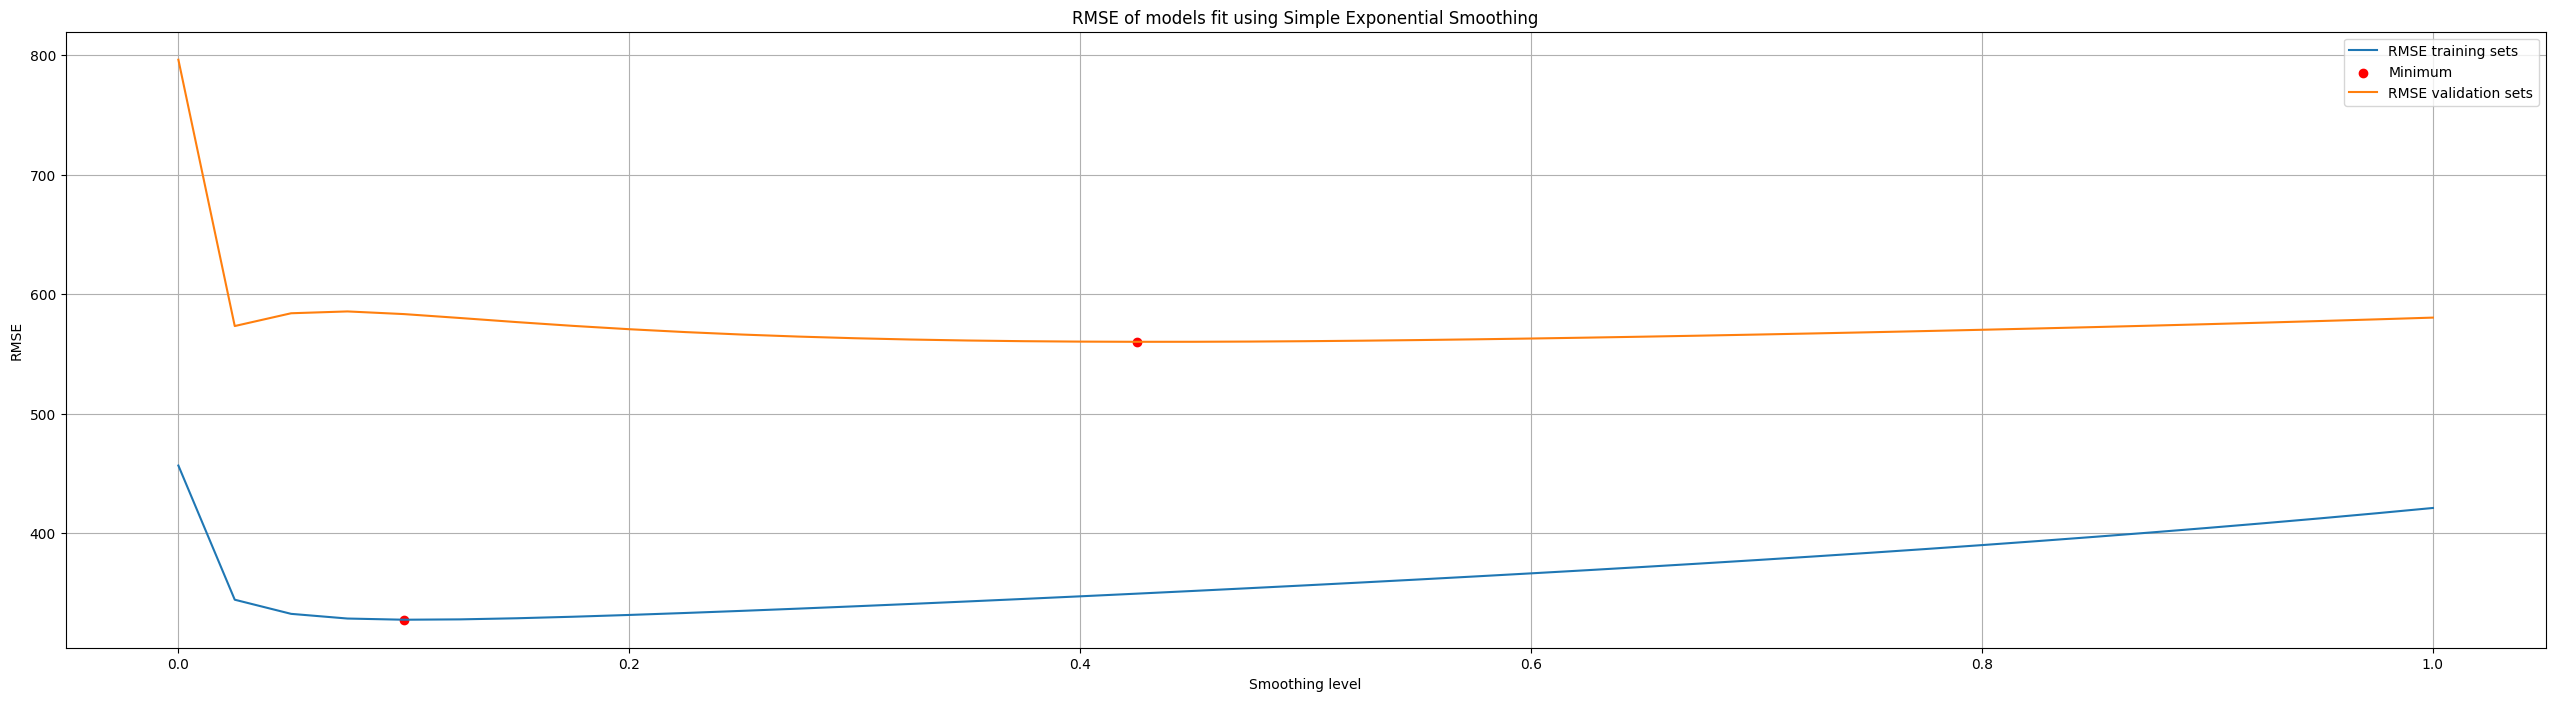


Focusing on RMSE:
Considering the lowest RMSE on the training folds:
            - The best smoothing level was 0.1;
            - The training RMSE was 327.72;
            - The validation RMSE was 583.42;
            - The training MAPE was 14.41%;
            - The validation MAPE was 22.32%

Considering the lowest RMSE on the validation folds:
            - The best smoothing level was 0.425;
            - The training RMSE was 349.52;
            - The validation RMSE was 560.23;
            - The training MAPE was 15.72%;
            - The validation MAPE was 22.31%


In [ ]:
#Plotting Performance on each trial on the Training and Validation sets as well as the best result on either folds
plt.figure(figsize=(32, 8))
plt.plot(df_ses.smoothing_level,
         df_ses.train_rmse,
         label = 'RMSE training sets')
plt.scatter(best_performer_train_rmse.smoothing_level,
            best_performer_train_rmse.train_rmse,
            color = 'red', label = 'Minimum')
plt.plot(df_ses.smoothing_level,
         df_ses.val_rmse,
         label = 'RMSE validation sets')
plt.scatter(best_performer_val_rmse.smoothing_level,
            best_performer_val_rmse.val_rmse,
            color = 'red')
plt.grid()
plt.legend()
plt.title('RMSE of models fit using Simple Exponential Smoothing')
plt.xlabel('Smoothing level')
plt.ylabel('RMSE')
plt.show()

print()
print('Focusing on RMSE:')
print(f"""Considering the lowest RMSE on the training folds:
            - The best smoothing level was {best_performer_train_rmse.smoothing_level};
            - The training RMSE was {best_performer_train_rmse.train_rmse:.2f};
            - The validation RMSE was {best_performer_train_rmse.val_rmse:.2f};
            - The training MAPE was {best_performer_train_rmse.train_mape:.2f}%;
            - The validation MAPE was {best_performer_train_rmse.val_mape:.2f}%""")
print()
print(f"""Considering the lowest RMSE on the validation folds:
            - The best smoothing level was {best_performer_val_rmse.smoothing_level};
            - The training RMSE was {best_performer_val_rmse.train_rmse:.2f};
            - The validation RMSE was {best_performer_val_rmse.val_rmse:.2f};
            - The training MAPE was {best_performer_val_rmse.train_mape:.2f}%;
            - The validation MAPE was {best_performer_val_rmse.val_mape:.2f}%""")


**Using the best performing smoothing level on the validation set, how does it compare to the performance of the model derived automatically before?**

In [ ]:
#Final fit with optimal level based on the validation folds
ses = SimpleExpSmoothing(df_train.nbr_purchases)
model = ses.fit(smoothing_level = 0.425)
#Make forecasts, save to a new column 'preds_ses' of the df_test and print the RMSE/MAPE on the test set
preds_ses = model.forecast(30)
df_test['preds_ses'] = preds_ses
print(f'On the test set, with smoothing level \033[1m{best_performer_val_rmse.smoothing_level}\033[0m the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ses)):.2f}')
print(f'On the test set, with smoothing level \033[1m{best_performer_val_rmse.smoothing_level}\033[0m the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ses)):.2f}%')

On the test set, with smoothing level 0.425 the RMSE is 320.43
On the test set, with smoothing level 0.425 the MAPE is 13.92%


**Statsmodels fits and evaluates on the same data, the training set. By evaluating a model based on the predictions it makes on the data that it already "saw" I run the risk of choosing hyperparameters that do not generalize well on unseen data!**

By using training and validation sets, in this case in a Cross Validation, I evaluate the model's performance on unseen data when choosing the best hyperparameter. The end result was a more robust model performance on the test set, outperforming the hyperparameter found automatically by Statsmodels!

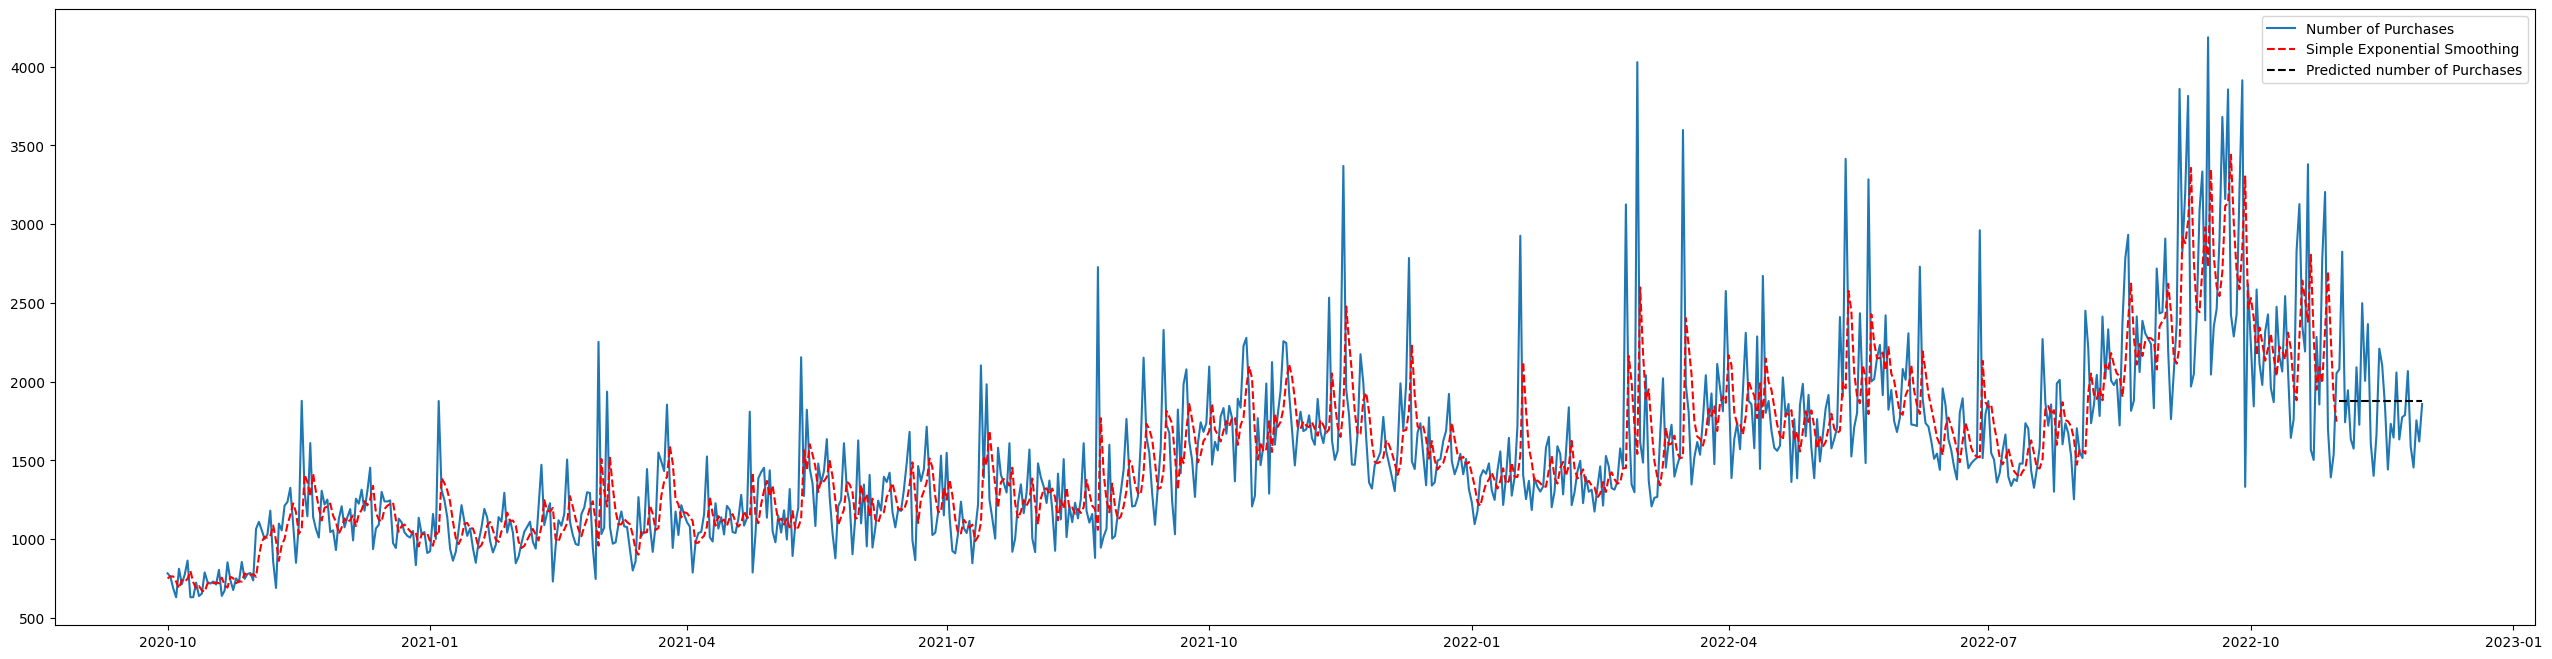


On the test set the RMSE is 320.43
On the test set the MAPE is 13.92%


In [ ]:
#Printing the model predictions on the entire dataset
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Number of Purchases')
plt.plot(model.fittedvalues,
         color='red',
         linestyle='--',
         label='Simple Exponential Smoothing')
plt.plot(preds_ses,
         color='black',
         linestyle='--',
         label='Predicted number of Purchases')
df_test['prediction_mean']
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ses)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ses)):.2f}%')

**The model follows the trend but doesn't match the outliers. Is a better model, somewhere between the Mean and the Naive methods.**

# 2. Triple Exponential Smoothing (ETS)

The Triple Exponential Smoothing model is an expansion of the Simple Exponential Smoothing and is also known as the Seasonal Holt-Winters Model.

This model takes into consideration not only what has happened before as well as the trend and seasonal patterns in the data to produce a better forecast.

This is therefore a more complex model with more hyperparameters, but the main ones are:
*   Alpha - Smoothing weight (smoothing_level in Statsmodels) (same as we've seen in the SES model);
*   Beta - Trend Smoothing weight (smoothing_trend in Statsmodels);
*   Gamma - Seasonal Smoothing weight (smoothing_seasonal in Statsmodels);

There are also 2 hyperparameters for telling the model whether the trend and seasonal components are additive or multiplicative. Remember the seasonal decomposition you performed on Module 7? Here is where you put it into practice to make more accurate predictions of the future!

As in the SES, there is a built in hyperparameter to tell Statsmodels to find the best hyperparameter by itself. Let's start by allowing it to do most of the  work!

**After fitting what are the best hyperparameters found by Statsmodels?**

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import smooth
#Initializing and fitting the model
model_ets = ExponentialSmoothing(
    df_train.nbr_purchases,
    seasonal_periods=7,
    trend='mul',
    seasonal='mul',
    initialization_method='estimated',
).fit()
df_model_ets = pd.DataFrame(columns=['smoothing_level',
                                     'smoothing_trend',
                                     'smoothing_seasonal',
                                     'trend',
                                     'seasonal'],
                                     index=[0])
df_model_ets['smoothing_level'] = model_ets.params['smoothing_level']
df_model_ets['smoothing_trend'] = model_ets.params['smoothing_trend']
df_model_ets['smoothing_seasonal'] = model_ets.params['smoothing_seasonal']
df_model_ets['trend'] = 'multiplicative'
df_model_ets['seasonal'] = 'multiplicative'
#Print the optimal hyperparameters found
print('The optimal hyperparameters found are:')
print(model_ets.params)

The optimal hyperparameters found are:
{'smoothing_level': 0.14642864373209455, 'smoothing_trend': 0.01331170967639252, 'smoothing_seasonal': 0.032829725541698024, 'damping_trend': nan, 'initial_level': 751.6191206770297, 'initial_trend': 1.0044527239494236, 'initial_seasons': array([1.18237462, 1.1650434 , 0.9259613 , 1.02161747, 1.10951329,
       1.18021837, 1.20291725]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


**How does it look compared with the SES model created before?**

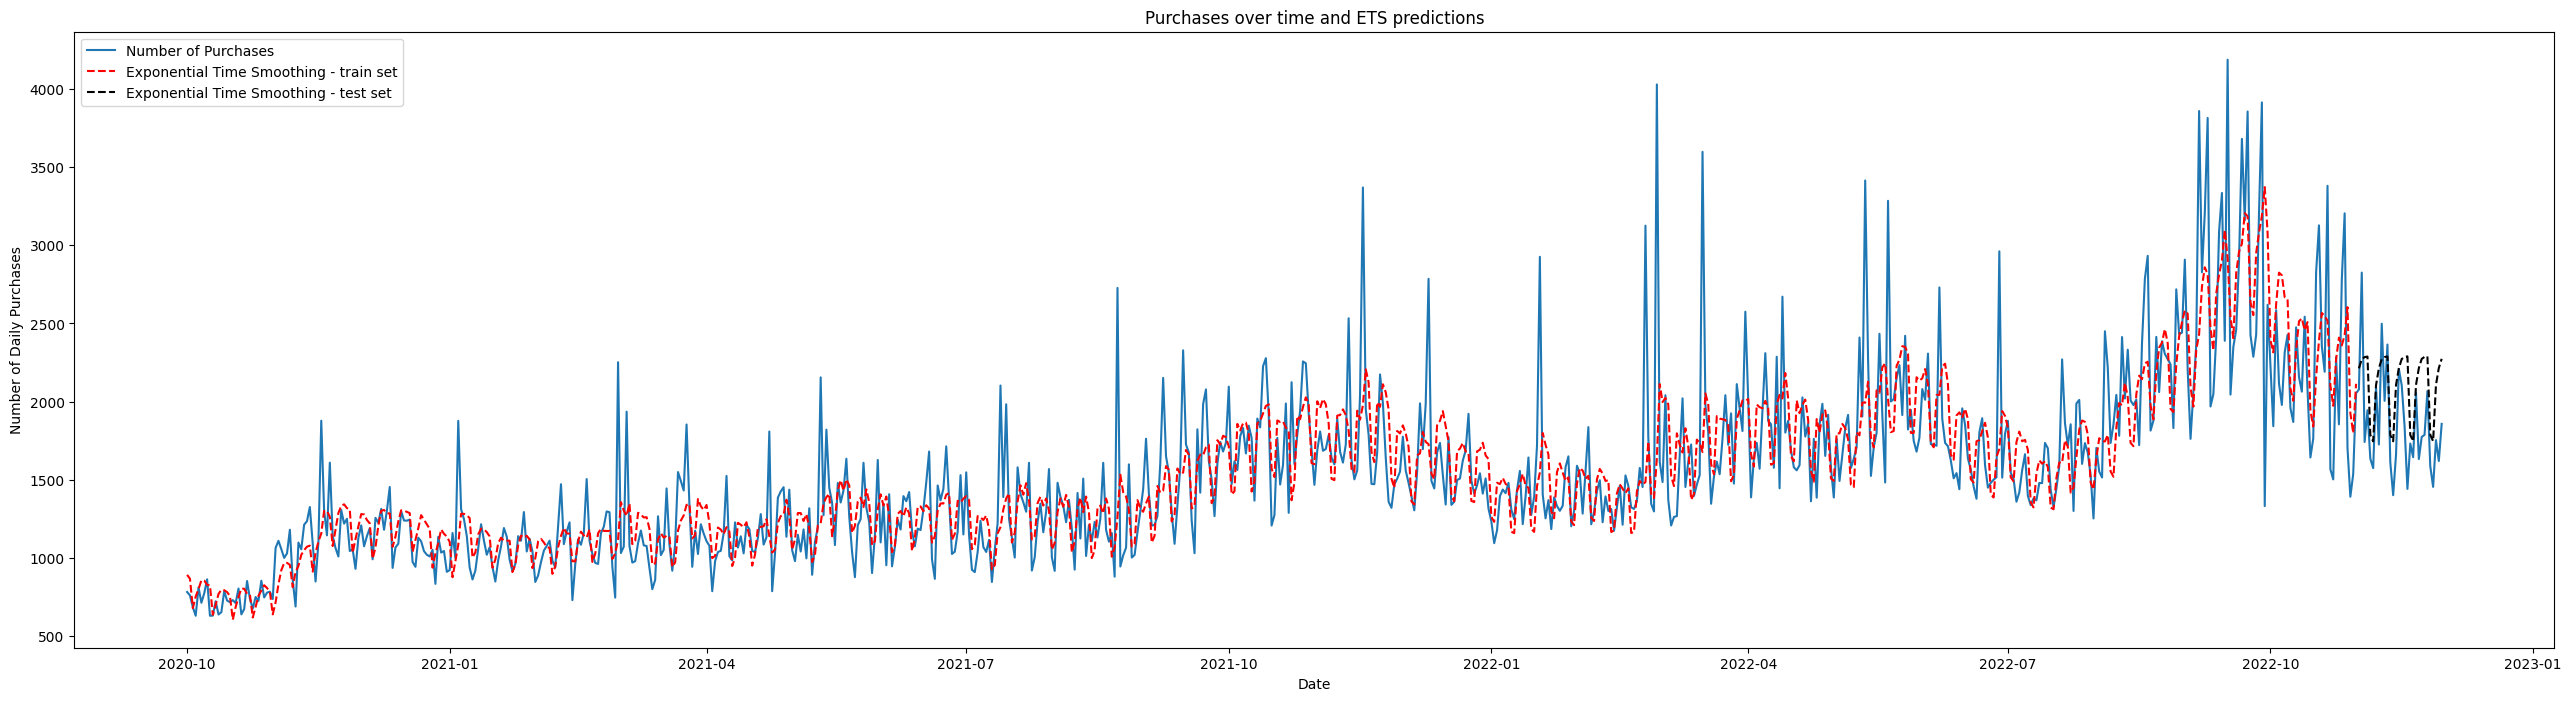


On the test set the RMSE is 371.05
On the test set the MAPE is 17.65%


In [ ]:
#Making 30 day forecasts and visualizing them
preds_ets = model_ets.forecast(30)

plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Number of Purchases')
plt.plot(model_ets.fittedvalues,
         color='red',
         linestyle='--',
         label='Exponential Time Smoothing - train set')
plt.plot(preds_ets,
         color='black',
         linestyle='--',
         label='Exponential Time Smoothing - test set')
plt.title('Purchases over time and ETS predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ets)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ets)):.2f}%')

**This model seems to display seasonality as it goes along, but considering the RMSE and MAPE values it is not performing as good as SES or Moving Average.**

When making forecasts on unseen data it is not making a prediction that shows a straight line - so the values will not always be the same, taking into consideration that we might have a trend.

Now its time  to find the best hyperparameters possible using Cross-Validation! The script is similar to the one used before for SES but needs to be adapted as I have a different model as well as more than 1 possible hyperparameter to optimize this time.

Large values of smoothing_trend and smoothing_seasonal tend to produce unstable models that make very large (potentially infinitely so) positive or negative predictions so I to limited the maximum values to the 0.3 range.

In [ ]:
#Manually look for best parameters...
list_param_alpha = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
list_param_beta = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
list_param_gamma = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
list_trend = ['multiplicative']
list_seasonal = ['multiplicative']
a = [list_param_alpha,
     list_param_beta,
     list_param_gamma,
     list_trend,
     list_seasonal]
list_params = list(itertools.product(*a))

results = {'trial':[],
           'train_rmse':[],
           'val_rmse':[],
           'train_mape':[],
           'val_mape':[]}
for i in range(len(list_params)):
  list_rmse_train = []
  list_rmse_val = []
  list_mape_train = []
  list_mape_val = []
  for (train,val) in list_splits:
    ets = ExponentialSmoothing(train,
                            seasonal_periods=7,
                            trend=list_params[i][3],
                            seasonal=list_params[i][4],
                            initialization_method=None,
                            ).fit(smoothing_level=list_params[i][0],
                                  smoothing_trend=list_params[i][1],
                                  smoothing_seasonal=list_params[i][2],)
    preds_val = ets.forecast(30)
    try:
      rmse_tmp_train = np.sqrt(mean_squared_error(train,ets.fittedvalues))
      mape_tmp_train = 100*(mean_absolute_percentage_error(train,ets.fittedvalues))
      list_rmse_train.append(rmse_tmp_train)
      list_mape_train.append(mape_tmp_train)
      rmse_tmp_val = np.sqrt(mean_squared_error(val,preds_val))
      mape_tmp_val = 100*(mean_absolute_percentage_error(val,preds_val))
      list_rmse_val.append(rmse_tmp_val)
      list_mape_val.append(mape_tmp_val)
    except:
      print(f'Error on trial {i}')

  #Calculating and storing training RMSE
  mean_rmse_train = np.mean(list_rmse_train)
  #Calculating and storing test RMSE
  mean_rmse_val = np.mean(list_rmse_val)
  #Calculating and storing training MAPE
  mean_mape_train = np.mean(list_mape_train)
  #Calculating and storing test MAPE
  mean_mape_val = np.mean(list_mape_val)

  results['trial'].append(i)
  results['train_rmse'].append(mean_rmse_train)
  results['val_rmse'].append(mean_rmse_val)
  results['train_mape'].append(mean_mape_train)
  results['val_mape'].append(mean_mape_val)

  print(f"On the training set, for trial {i} the RMSE is {mean_rmse_train:.2f}")
  print(f"On the validation set, for trial {i} the RMSE is {mean_rmse_val:.2f}")
  print(f"On the training set, for trial {i} the MAPE is {mean_mape_train:.2f}%")
  print(f"On the validation set, for trial {i} the MAPE is {mean_mape_val:.2f}%")
  print()

df_ets = pd.DataFrame(results)

On the training set, for trial 0 the RMSE is 309.42
On the validation set, for trial 0 the RMSE is 668.23
On the training set, for trial 0 the MAPE is 13.71%
On the validation set, for trial 0 the MAPE is 27.88%

On the training set, for trial 1 the RMSE is 311.30
On the validation set, for trial 1 the RMSE is 657.59
On the training set, for trial 1 the MAPE is 13.67%
On the validation set, for trial 1 the MAPE is 27.29%

On the training set, for trial 2 the RMSE is 313.61
On the validation set, for trial 2 the RMSE is 649.74
On the training set, for trial 2 the MAPE is 13.70%
On the validation set, for trial 2 the MAPE is 26.77%

On the training set, for trial 3 the RMSE is 316.34
On the validation set, for trial 3 the RMSE is 644.02
On the training set, for trial 3 the MAPE is 13.75%
On the validation set, for trial 3 the MAPE is 26.30%

On the training set, for trial 4 the RMSE is 319.60
On the validation set, for trial 4 the RMSE is 639.86
On the training set, for trial 4 the MAPE 

**What was the minimum training and validation RMSE obtained for each of these options? And what hyperparameters work best in each situation?**

In [ ]:
#Identifying the best performer on training folds RMSE and the one that best performs on the validation folds RMSE
best_performer_train_rmse = df_ets.iloc[df_ets.train_rmse.idxmin()]
best_performer_val_rmse = df_ets.iloc[df_ets.val_rmse.idxmin()]
best_params_train_rmse = list_params[best_performer_train_rmse.trial.astype('int')]
best_params_val_rmse = list_params[best_performer_val_rmse.trial.astype('int')]

#Identifying the best performer on training folds MAPE and the one that best performs on the validation folds MAPE
best_performer_train_mape = df_ets.iloc[df_ets.train_mape.idxmin()]
best_performer_val_mape = df_ets.iloc[df_ets.val_mape.idxmin()]
best_params_train_mape = list_params[best_performer_train_mape.trial.astype('int')]
best_params_val_mape = list_params[best_performer_val_mape.trial.astype('int')]

#Printing the best hyperparameters as well as the RMSE/MAPE values for the best performing ones based on RMSE
print(f"""Considering the lowest RMSE on the training folds:
            - The best alpha was {best_params_train_rmse[0]};
            - The best beta was {best_params_train_rmse[1]};
            - The best gamma was {best_params_train_rmse[2]};
            - The training RMSE was {best_performer_train_rmse.train_rmse:.2f};
            - The validation RMSE was {best_performer_train_rmse.val_rmse:.2f};
            - The training MAPE was {best_performer_train_rmse.train_mape:.2f}%;
            - The validation MAPE was {best_performer_train_rmse.val_mape:.2f}%""")
print()
print(f"""Considering the lowest RMSE on the validation folds:
            - The best alpha was {best_params_val_rmse[0]};
            - The best beta was {best_params_val_rmse[1]};
            - The best gamma was {best_params_val_rmse[2]};
            - The training RMSE was {best_performer_val_rmse.train_rmse:.2f};
            - The validation RMSE was {best_performer_val_rmse.val_rmse:.2f};
            - The training MAPE was {best_performer_val_rmse.train_mape:.2f}%;
            - The validation MAPE was {best_performer_val_rmse.val_mape:.2f}%""")
#Printing the best hyperparameters as well as the RMSE/MAPE values for the best performing ones based on MAPE
print()
print(f"""Considering the lowest MAPE on the training folds:
            - The best alpha was {best_params_train_mape[0]};
            - The best beta was {best_params_train_mape[1]};
            - The best gamma was {best_params_train_mape[2]};
            - The training RMSE was {best_performer_train_mape.train_rmse:.2f};
            - The validation RMSE was {best_performer_train_mape.val_rmse:.2f};
            - The training MAPE was {best_performer_train_mape.train_mape:.2f}%;
            - The validation MAPE was {best_performer_train_mape.val_mape:.2f}%""")
print()
print(f"""Considering the lowest MAPE on the training folds:
            - The best alpha was {best_params_val_mape[0]};
            - The best beta was {best_params_val_mape[1]};
            - The best gamma was {best_params_val_mape[2]};
            - The training RMSE was {best_performer_val_mape.train_rmse:.2f};
            - The validation RMSE was {best_performer_val_mape.val_rmse:.2f};
            - The training MAPE was {best_performer_val_mape.train_mape:.2f}%;
            - The validation MAPE was {best_performer_val_mape.val_mape:.2f}%""")

Considering the lowest RMSE on the training folds:
            - The best alpha was 0.1;
            - The best beta was 0.05;
            - The best gamma was 0.05;
            - The training RMSE was 303.89;
            - The validation RMSE was 607.34;
            - The training MAPE was 13.19%;
            - The validation MAPE was 25.24%

Considering the lowest RMSE on the validation folds:
            - The best alpha was 0.1;
            - The best beta was 0.15;
            - The best gamma was 0.05;
            - The training RMSE was 312.02;
            - The validation RMSE was 521.44;
            - The training MAPE was 13.69%;
            - The validation MAPE was 21.36%

Considering the lowest MAPE on the training folds:
            - The best alpha was 0.15;
            - The best beta was 0.05;
            - The best gamma was 0.05;
            - The training RMSE was 304.61;
            - The validation RMSE was 568.04;
            - The training MAPE was 13.16%;
     

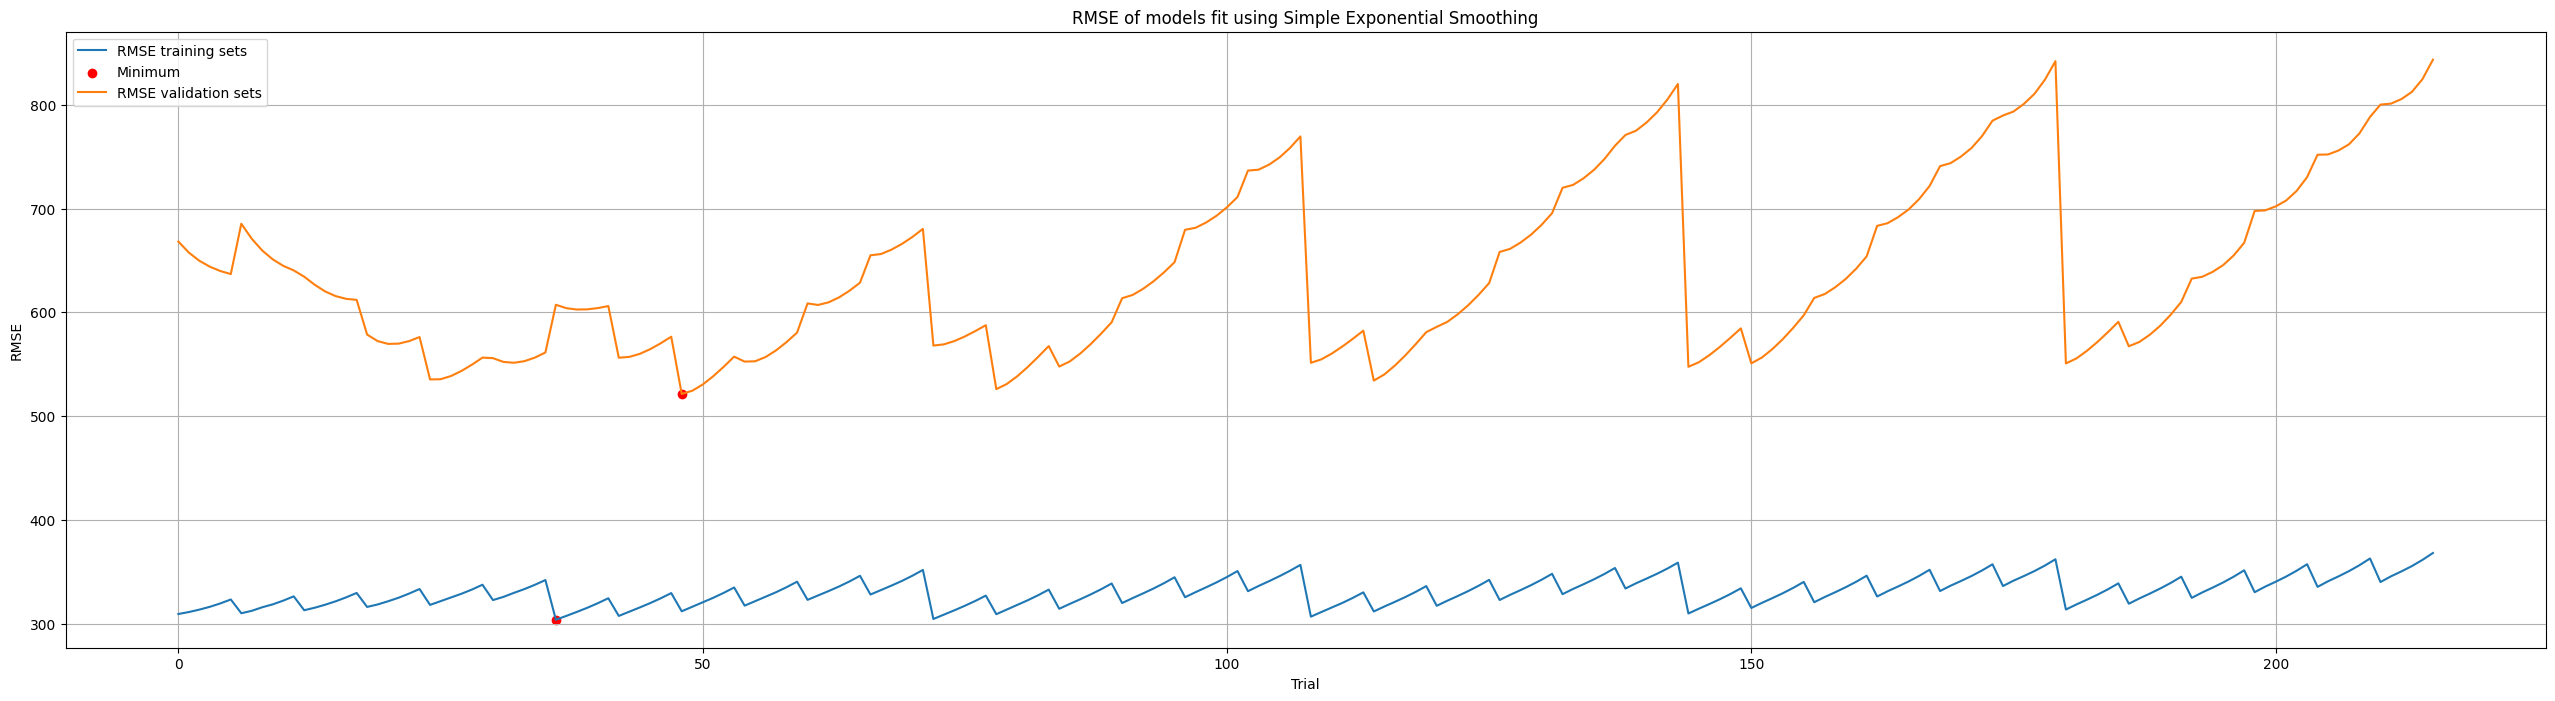

In [ ]:
#Plotting Performance on each trial on the Training and Validation sets as well as the best result on either folds
plt.figure(figsize=(32, 8))
plt.plot(df_ets.trial,
         df_ets.train_rmse,
         label = 'RMSE training sets')
plt.scatter(best_performer_train_rmse.trial,
            best_performer_train_rmse.train_rmse,
            color = 'red', label = 'Minimum')
plt.plot(df_ets.trial,
         df_ets.val_rmse,
         label = 'RMSE validation sets')
plt.scatter(best_performer_val_rmse.trial,
            best_performer_val_rmse.val_rmse,
            color = 'red')
plt.grid()
plt.legend()
plt.title('RMSE of models fit using Simple Exponential Smoothing')
plt.xlabel('Trial')
plt.ylabel('RMSE')
plt.show()

**The validation set has larger RMSE than the training set.**

**How does this model compare with the one produced before (SES)?**

In [ ]:
#Final fit with optimal level based on the validation folds
model_ets = ExponentialSmoothing(
    df_train.nbr_purchases,
    seasonal_periods=7,
    trend=best_params_val_rmse[3],
    seasonal=best_params_val_rmse[4],
    initialization_method=None,).fit(smoothing_level=best_params_val_rmse[0],
                                     smoothing_trend=best_params_val_rmse[1],
                                     smoothing_seasonal=best_params_val_rmse[2])

#Making and saving forecasts.
preds_ets = model_ets.forecast(30)
df_test['preds_ets'] = preds_ets

#Printing RMSE/MAPE
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ets)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ets)):.2f}%')

On the test set the RMSE is 263.00
On the test set the MAPE is 11.34%


**Until this point, it's the best result we've reached.**

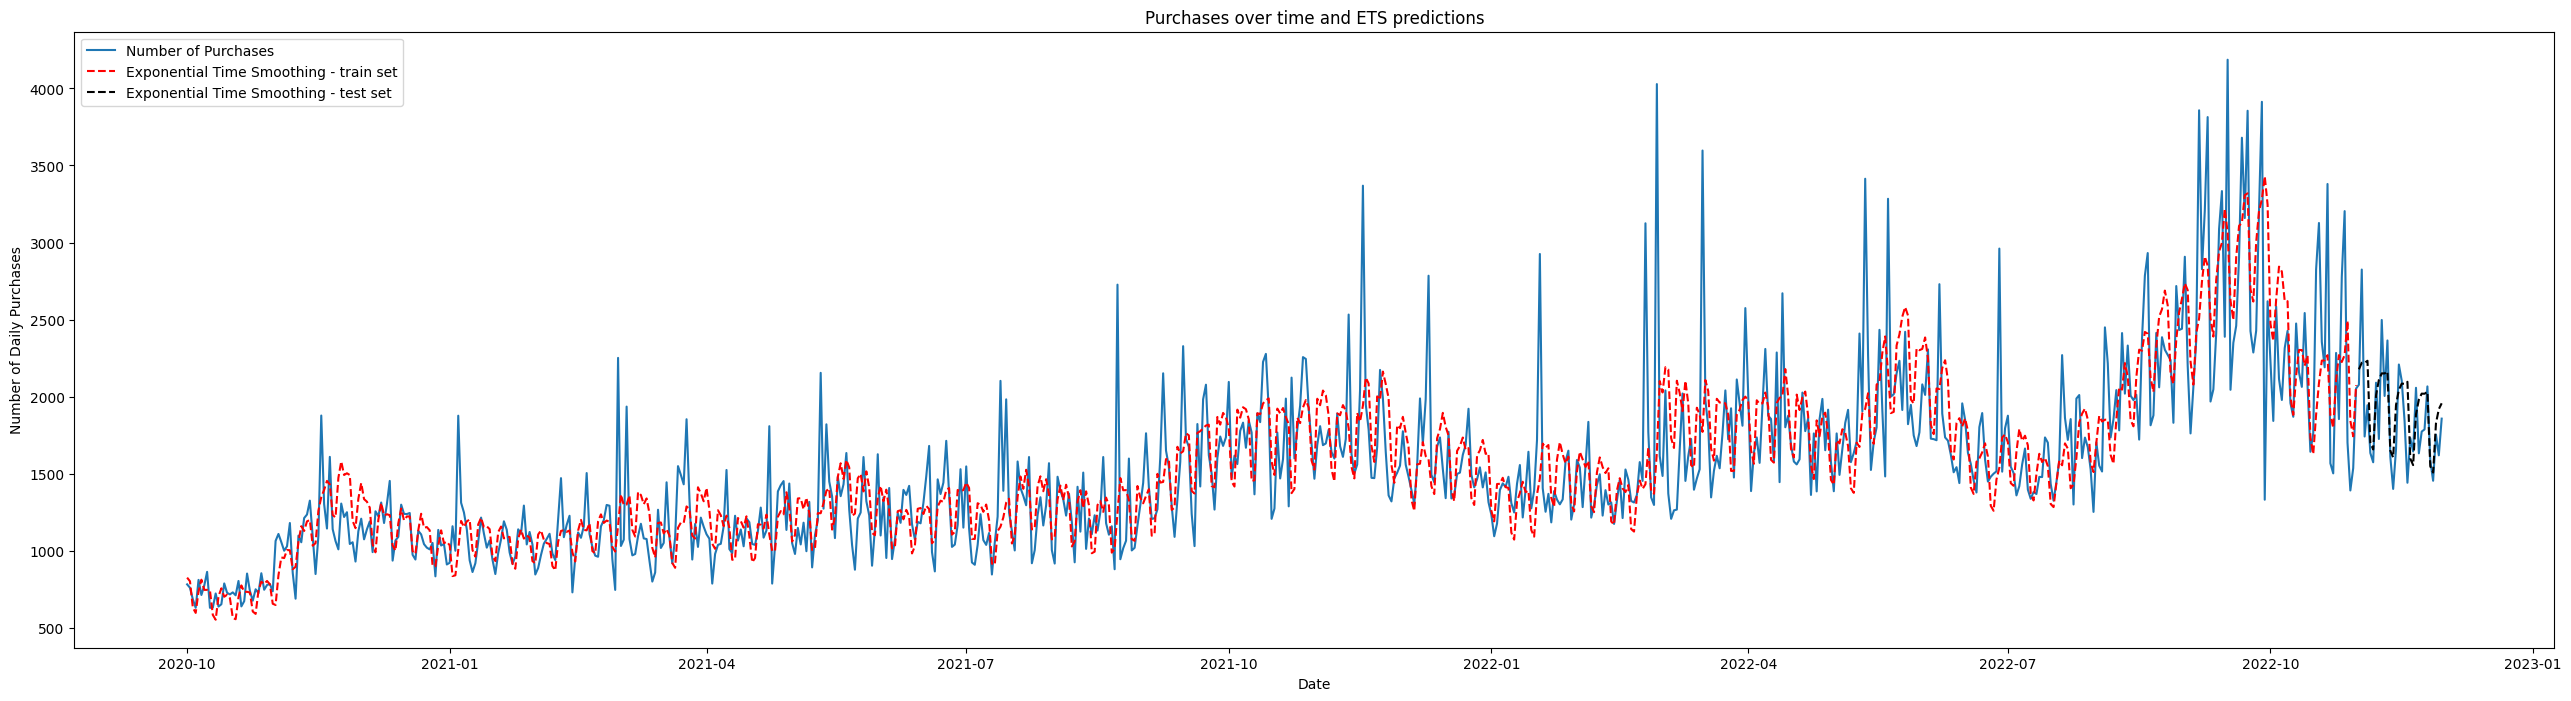


On the test set the RMSE is 263.00
On the test set the MAPE is 11.34%


In [ ]:
#Printing model performance on the entire time series range
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Number of Purchases')
plt.plot(model_ets.fittedvalues,
         color='red',
         linestyle='--',
         label='Exponential Time Smoothing - train set')
plt.plot(preds_ets,
         color='black',
         linestyle='--',
         label='Exponential Time Smoothing - test set')
plt.title('Purchases over time and ETS predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_ets)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_ets)):.2f}%')

**For the test set it's no longer making a straight line as it is on SES: it is following the trend of the data, considering more recent data.**

# 3. Stationarity

By now I'm  very familiar with the time series plot of `'nbr_purchases'`. Is it stationary?

To confirm this hunch I'll apply the Augmented Dickey-Fuller test using the `adfuller` method from `statsmodels.tsa.stattools`.

**Can I reject the null hypothesis and claim that the data is stationary?**

In [ ]:
#Using Augmented Dickey-Fuller test for stationarity check
print("Observations of Dickey-fuller test")
results_adfuller = adfuller(df_train.nbr_purchases, autolag='AIC')
dickey=pd.Series(results_adfuller[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in results_adfuller[4].items():
    dickey['critical value (%s)'%key]= value
print(dickey)

Observations of Dickey-fuller test
Test Statistic                  -1.724027
p-value                          0.418778
#lags used                      20.000000
number of observations used    740.000000
critical value (1%)             -3.439218
critical value (5%)             -2.865454
critical value (10%)            -2.568854
dtype: float64


The test Statistic is not less than the critical values at different percentage. I cannot reject my null hypothesis and conclude that the data is **not stationary.**

I'll plot the ACF and PACF using the `plot_acf` and `plot_pacf` methods from `statsmodels.graphics.tsaplots` using `lags=365` and `zero=False`.

**Are there evidences of trends and seasonality on them?**

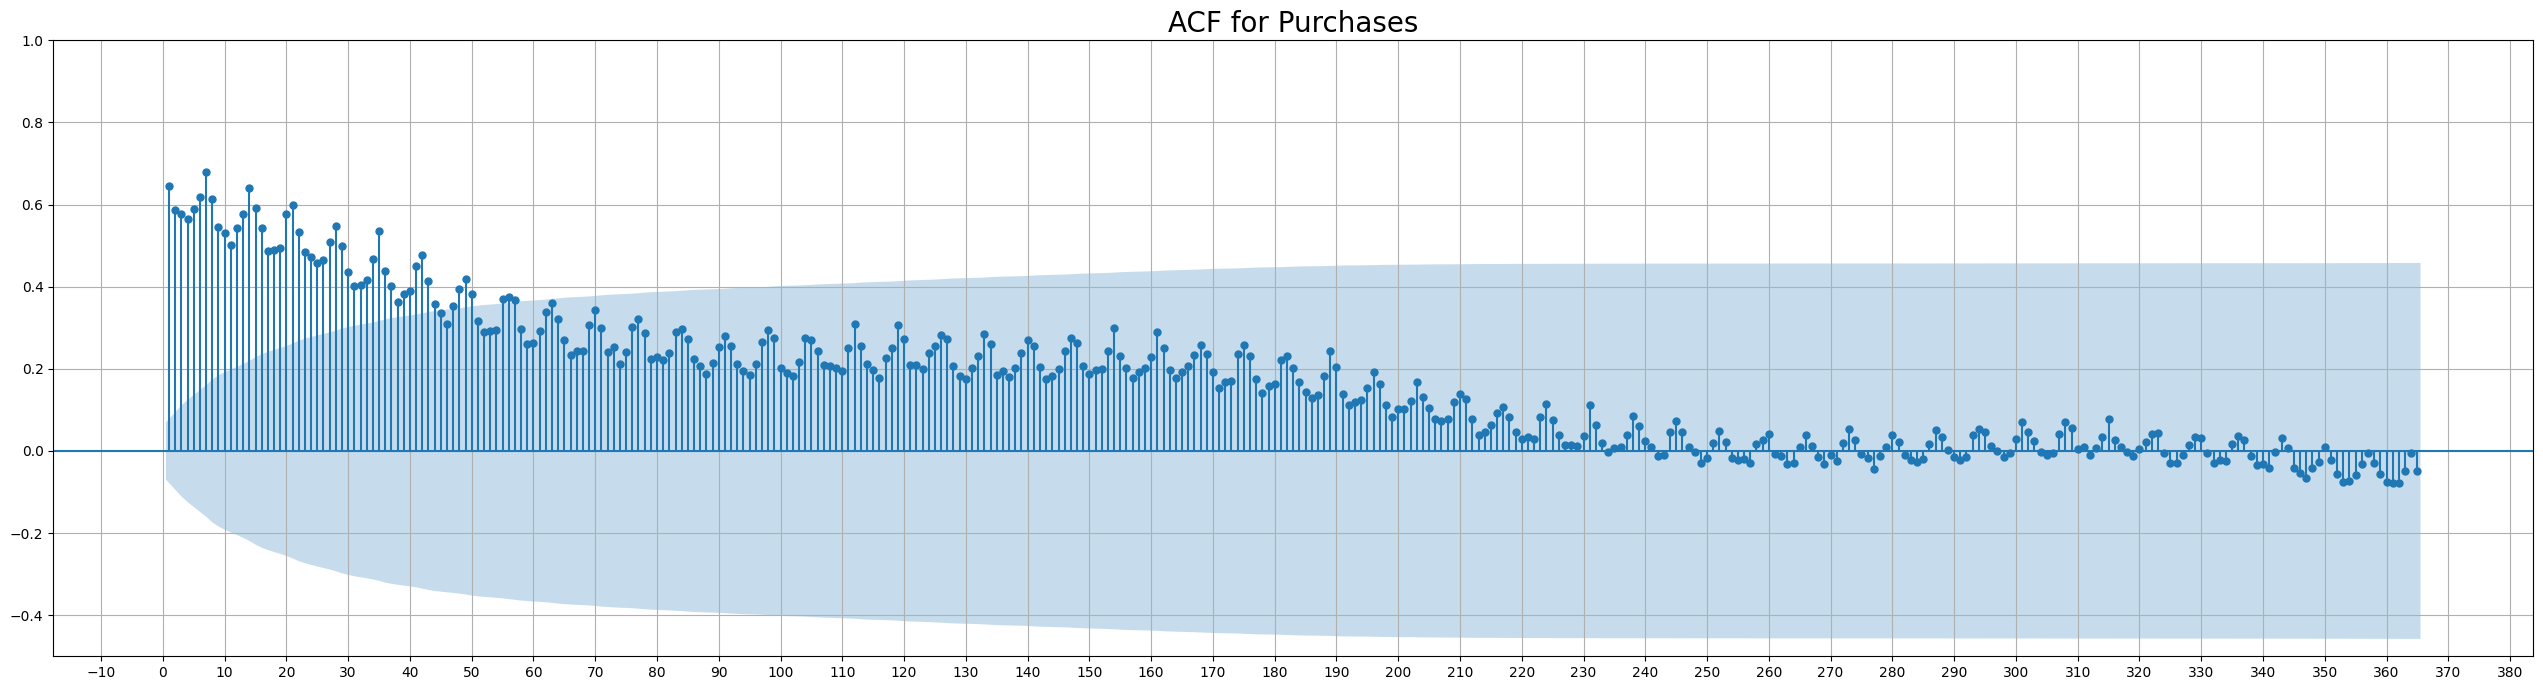

In [ ]:
#Applying ACF
with plt.rc_context():
    plt.rc("figure", figsize=(32,8))
    plot_acf(df.nbr_purchases,
             zero = False,
             lags = 365,
             alpha = 0.05)
    plt.title("ACF for Purchases",
              size=20)
    plt.grid()
    plt.ylim(-0.5,1)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

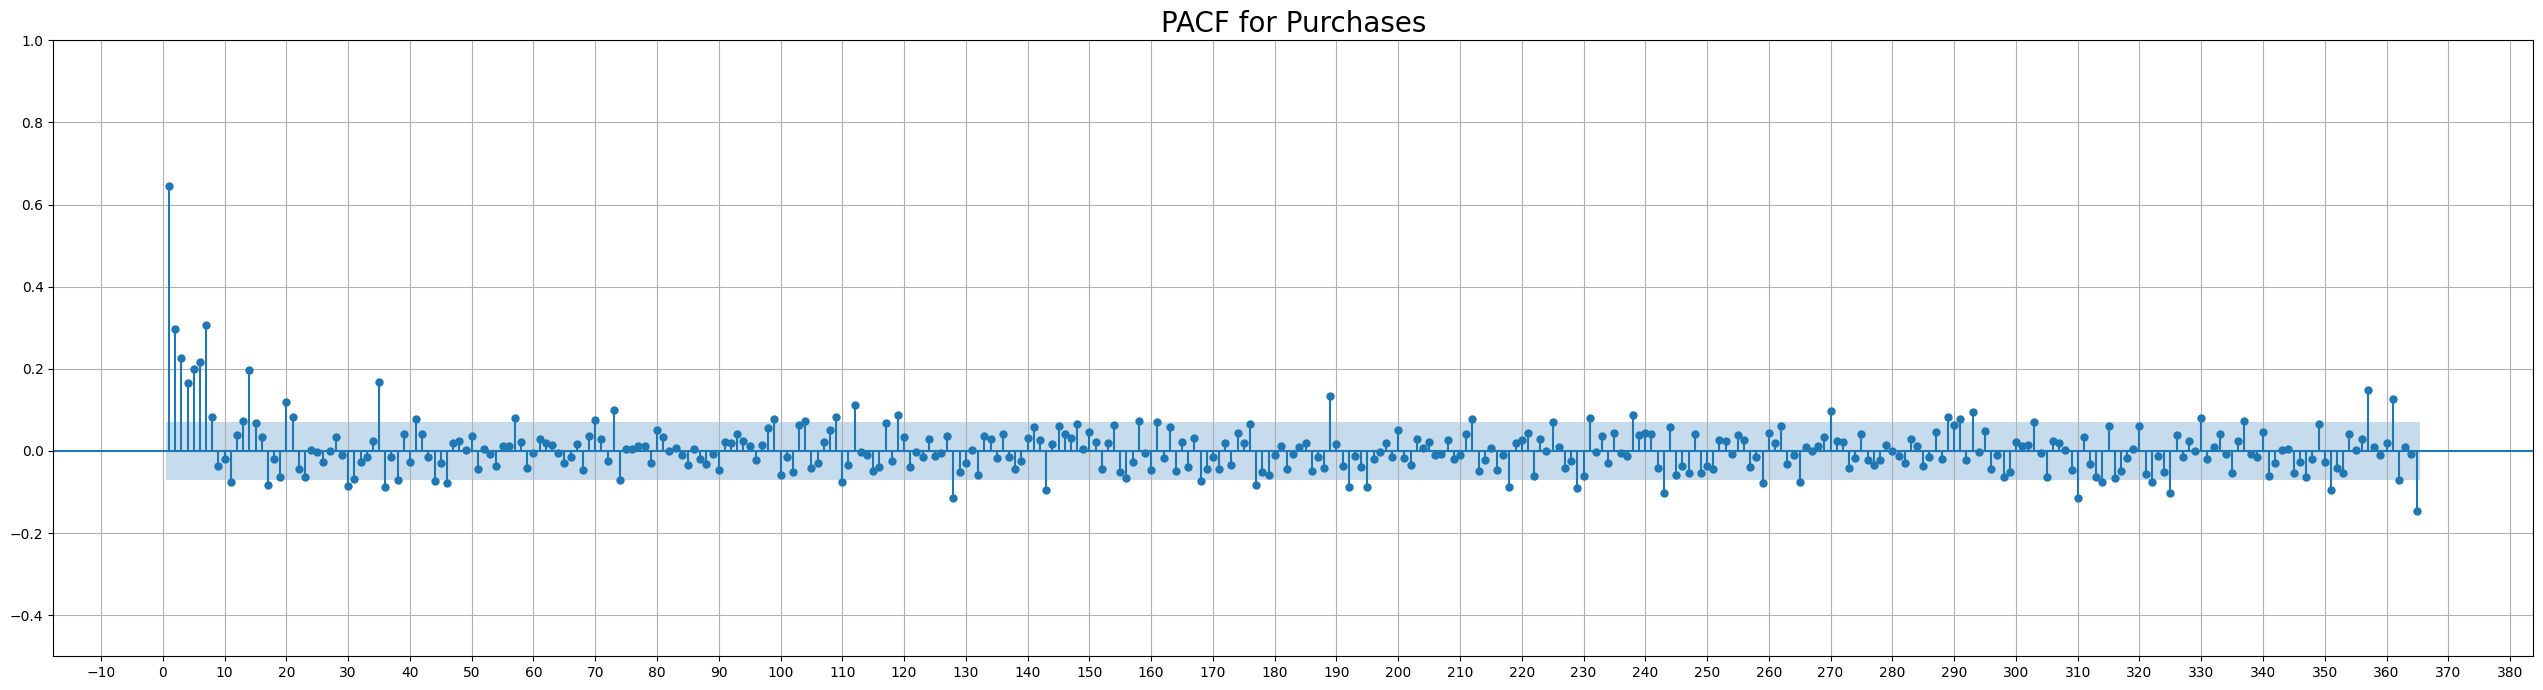

In [ ]:
#Applying PACF
with plt.rc_context():
    plt.rc("figure", figsize=(32,8))
    plot_pacf(df.nbr_purchases,
              zero = False,
              lags = 365,
              alpha = 0.05)
    plt.title("PACF for Purchases",
              size=20)
    plt.grid()
    plt.ylim(-0.5,1)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

I can see evidences of trend and seasonality, especially on the ACF.

It'a a trend because it's possible to see a downward slope, very gradual, that takes a large number of days to disappear, which is consistent with **trend.**

Also there's a regular variation, where every n_days we have a local maximum autocorrelation, which is conistent with **seasonality.**

In [ ]:
#First order differencing
df_train['nbr_purchases_diff_1'] = df_train.nbr_purchases.diff()

I'll re-run the Augmented Dickey-Fuller on `'nbr_purchases_diff_1'` test to check stationarity. Will it work?

In [ ]:
#Using Augmented Dickey-Fuller test for stationarity check
print("Observations of Dickey-fuller test")
results_adfuller2 = adfuller(df_train.nbr_purchases_diff_1.dropna(), autolag='AIC')
dickey2=pd.Series(results_adfuller2[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in results_adfuller2[4].items():
    dickey2['critical value (%s)'%key]= value
print(dickey2)

Observations of Dickey-fuller test
Test Statistic                -9.443060e+00
p-value                        4.836503e-16
#lags used                     1.900000e+01
number of observations used    7.400000e+02
critical value (1%)           -3.439218e+00
critical value (5%)           -2.865454e+00
critical value (10%)          -2.568854e+00
dtype: float64


Now the data seems to be **stationary**, since the statistical test returns a smaller value than the critical values, and so I reject the null hypothesis.

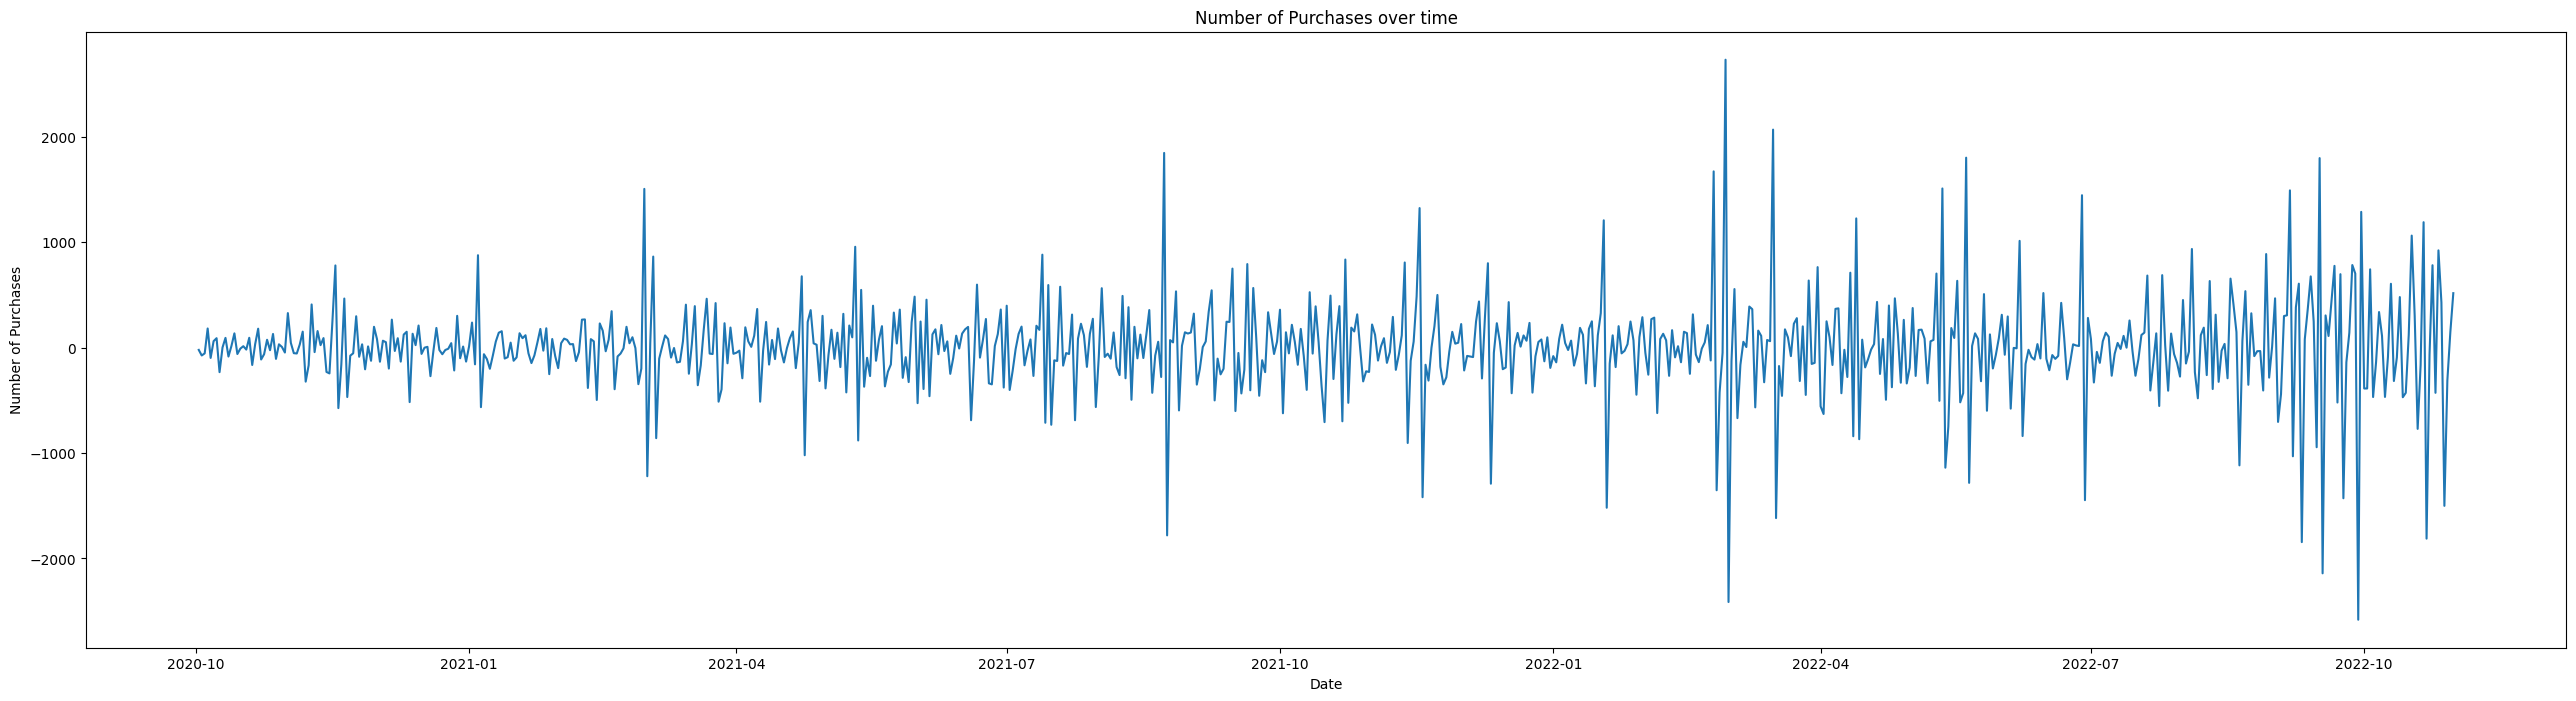

In [ ]:
#Plotting of nbr_purchases
plt.figure(figsize=(32,8))
plt.plot(df_train.nbr_purchases_diff_1)
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.title('Number of Purchases over time')
plt.show()

**No hints of trend or seasonality.**

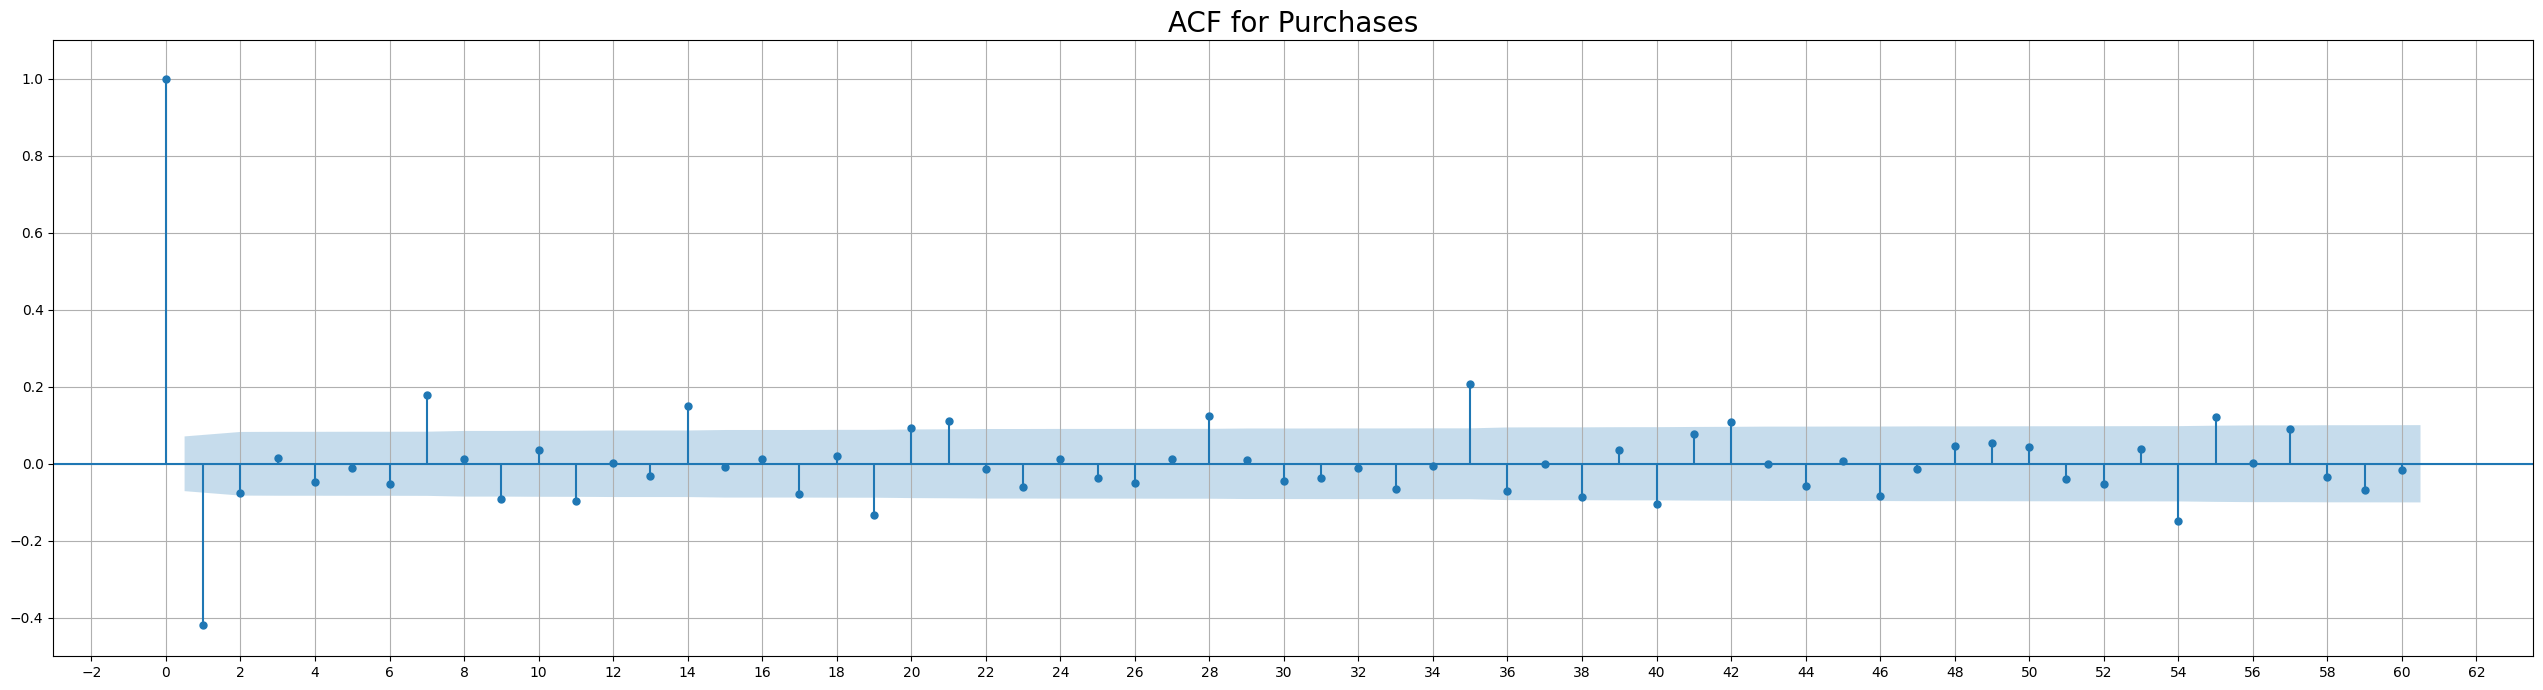

In [ ]:
#Applying ACF
with plt.rc_context():
    plt.rc("figure", figsize=(32,8))
    plot_acf(df_train.nbr_purchases_diff_1.dropna(),
             zero = True,
             lags = 60,
             alpha = 0.05)
    plt.title("ACF for Purchases",
              size=20)
    plt.grid()
    plt.ylim(-0.5,1.1)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

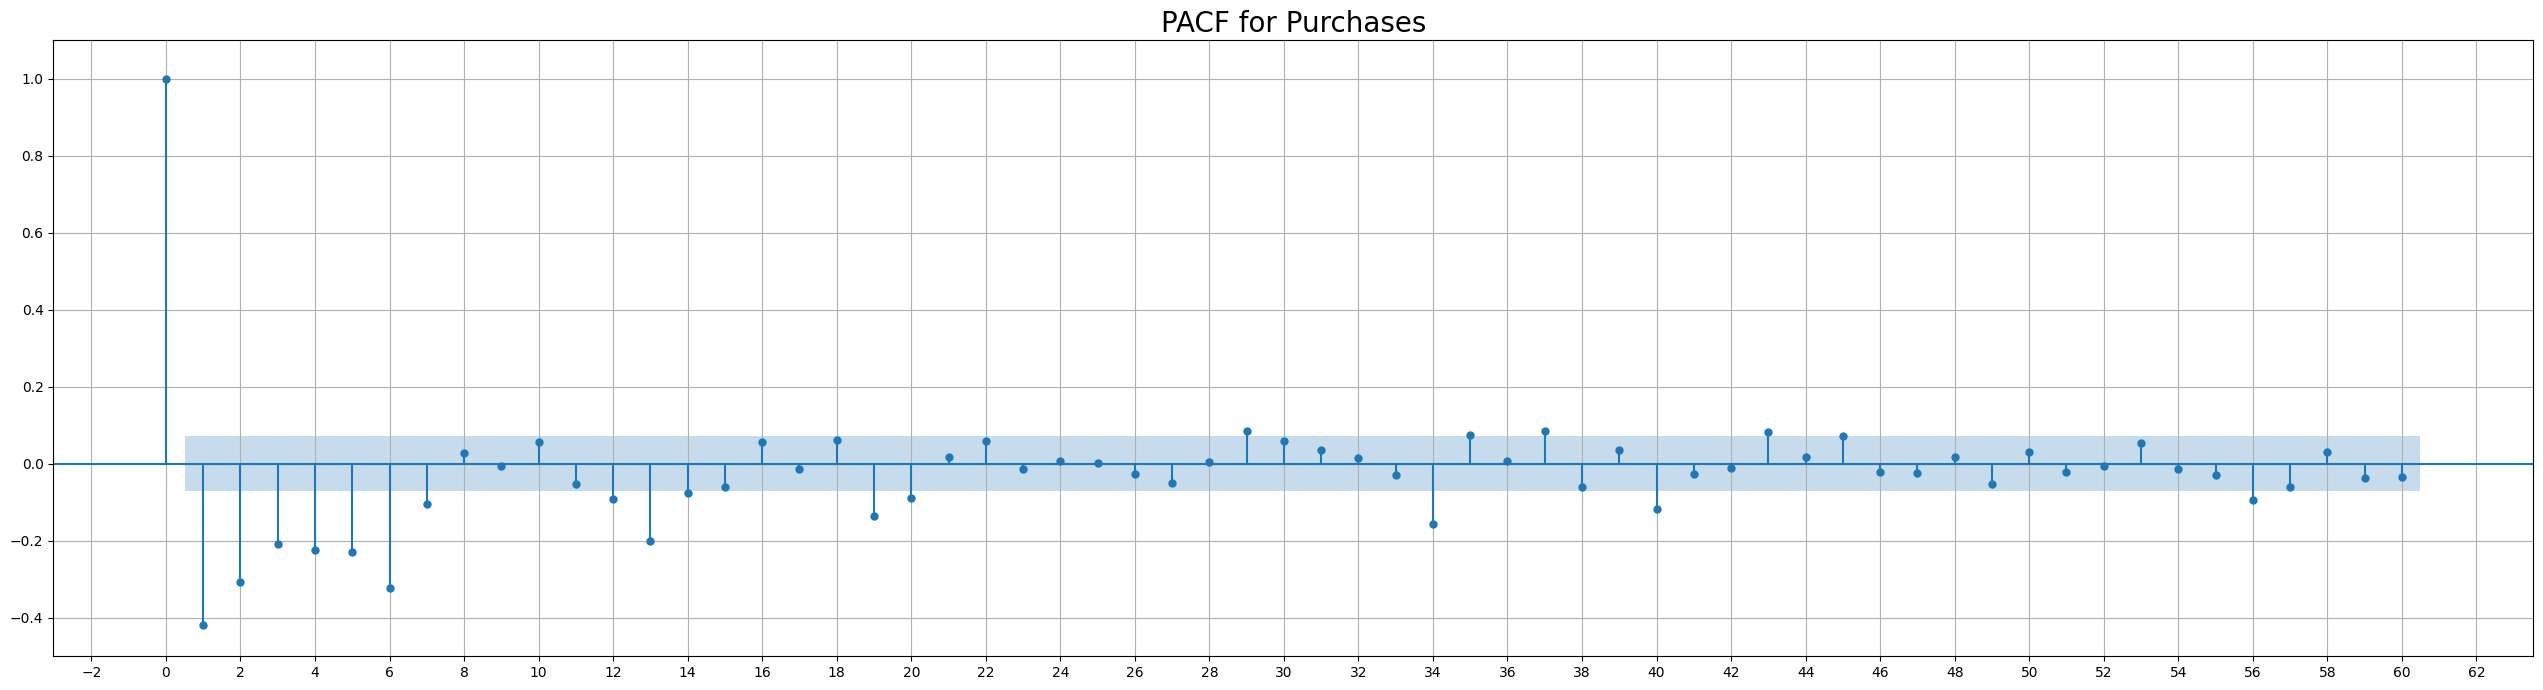

In [ ]:
#Applying PACF
with plt.rc_context():
    plt.rc("figure", figsize=(32,8))
    plot_pacf(df_train.nbr_purchases_diff_1.dropna(),
             zero = True,
             lags = 60,
             alpha = 0.05)
    plt.title("PACF for Purchases",
              size=20)
    plt.grid()
    plt.ylim(-0.5,1.1)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

**ACF and PACF look different: we have some indications of seasonality but nothing too extreme, we cannot see a trend.**

# 4. Auto Regressive Integrated Moving Average (ARIMA)

ARIMA stands for Auto Regressive Integrated Moving Average. This model works by considering the past lagged values of the time series to forecast future ones (the AR component) as well as the lagged forecast errors (the MA component). Integrated here is due to integrating differencing, the order of which is a hyperparameter `d` that can be passed to the model.

Both the MA and AR components of the model have hyperparameters associated, indicating in this case `q` and `p` respectively.

`q` is obtained by looking into the ACF. I should look at where the number I have just prior to the values dropping to or below the significance band (in blue on the ACF/PACF plots).

`p` is obtained from the PACF. The method of choosing is just the same.


Taking a look at the ACF and PACF plots that you produced previously (after 1st order differencing) and looking at the lag number (the x axis value) immediately prior to the bands dropping to or below the blue significance band. That should be my first guesses at the `p` and `q` hyperparameters.

When I look at the ACF I see a large value on lag one and then I have statistically significant spikes on lags 7 (likely the result of the weekly seasonality). The weekly seasonality still shows here as I see lag 14, 21, 28 above the threshold as well.

The ACF informs on the MA (Moving Average) term q. I'll try `q = 1` as my first guess. `q = 7` is also a possibility as it represents the first term of seasonality.

The PACF informs on the AR (Auto Regressive) term `p`. Here I see that it is significant all the way to `p = 6` or `p = 7` so those are the values to use.

## 4.2.

Now that you have identified some potential candidate hyperparameters for the ARIMA you should initialize and fit models with the various candidates you found. Feel free to try various possibilities, ARIMA hyperparameters aren’t always obvious and while the ACF and PACF can give good clues, there is ample room for experimentation.

For now choose only one and follow the instructions. Later you will be able to test other options to find the best one.

Use the `ARIMA` method of the `statsmodels.tsa.arima`.model and initialize by passing `'nbr_purchases'` and the hyperparameters using `order=(p,d,q)`. Save the initialized models to a variable called `arima`. Then fit it using `.fit()` (do not pass any hyperparameters on the fit call) and save it to `model_arima` (reuse them if looking at various possibilities).

In [ ]:
#Initialize and fit your first guess for ARIMA hyperparameters
arima = ARIMA(df_train.nbr_purchases, order=(7,1,1))
model_arima= arima.fit()

## 4.3.

Look into `.summary()` to obtain various statistics and metrics that help you evaluate your model choices. You should pay extra attention to the Akaike Information Criterion (AIC) as well as the Ljung Box test.

The AIC evaluates how well your model fits the data while penalizing complexity. Generally speaking we want simple models that perform well and the AIC will consider this trade-off. So you are looking for low values of AIC.

The Ljung Box test is a way of testing if the residuals that remain after making predictions are not random (the null hypothesis). If they are not random, that means we still have patterns on the residuals that the model is not considering and therefore we should look for a better model. So in this test you will want p-values > than your significance threshold (0.05 for example).

After investigating the summary statistics you should visualize the residuals (line plot) as well as their density plot. Residuals should be centered around 0 and not display patterns. The Density plot should approximate to a Normal distribution (Gaussian shape) and be centered close to 0.

 First extract the residuals of the model and save then to an object called residuals. Then make the two plots (you will see an example of this on fifth learning content.

Also don’t forget to use the trusty RMSE and MAPE on the test set to see the performance of the model

In [ ]:
#Print the model summary statistics
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          nbr_purchases   No. Observations:                  761
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -5536.104
Date:                Tue, 02 May 2023   AIC                          11090.209
Time:                        21:16:38   BIC                          11131.909
Sample:                    10-01-2020   HQIC                         11106.267
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1124      0.058      1.922      0.055      -0.002       0.227
ar.L2         -0.0224      0.053     -0.424      0.672      -0.126       0.081
ar.L3          0.0103      0.053      0.197      0.8

The Ljung-Box-P is large enough so we cannot reject the null hypothesis that the residuals are white noise.

In [ ]:
#Make forecasts and print the RMSE and MAPE on the test set
preds_arima = model_arima.forecast(30)
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_arima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_arima)):.2f}%')

On the test set the RMSE is 400.48
On the test set the MAPE is 20.31%


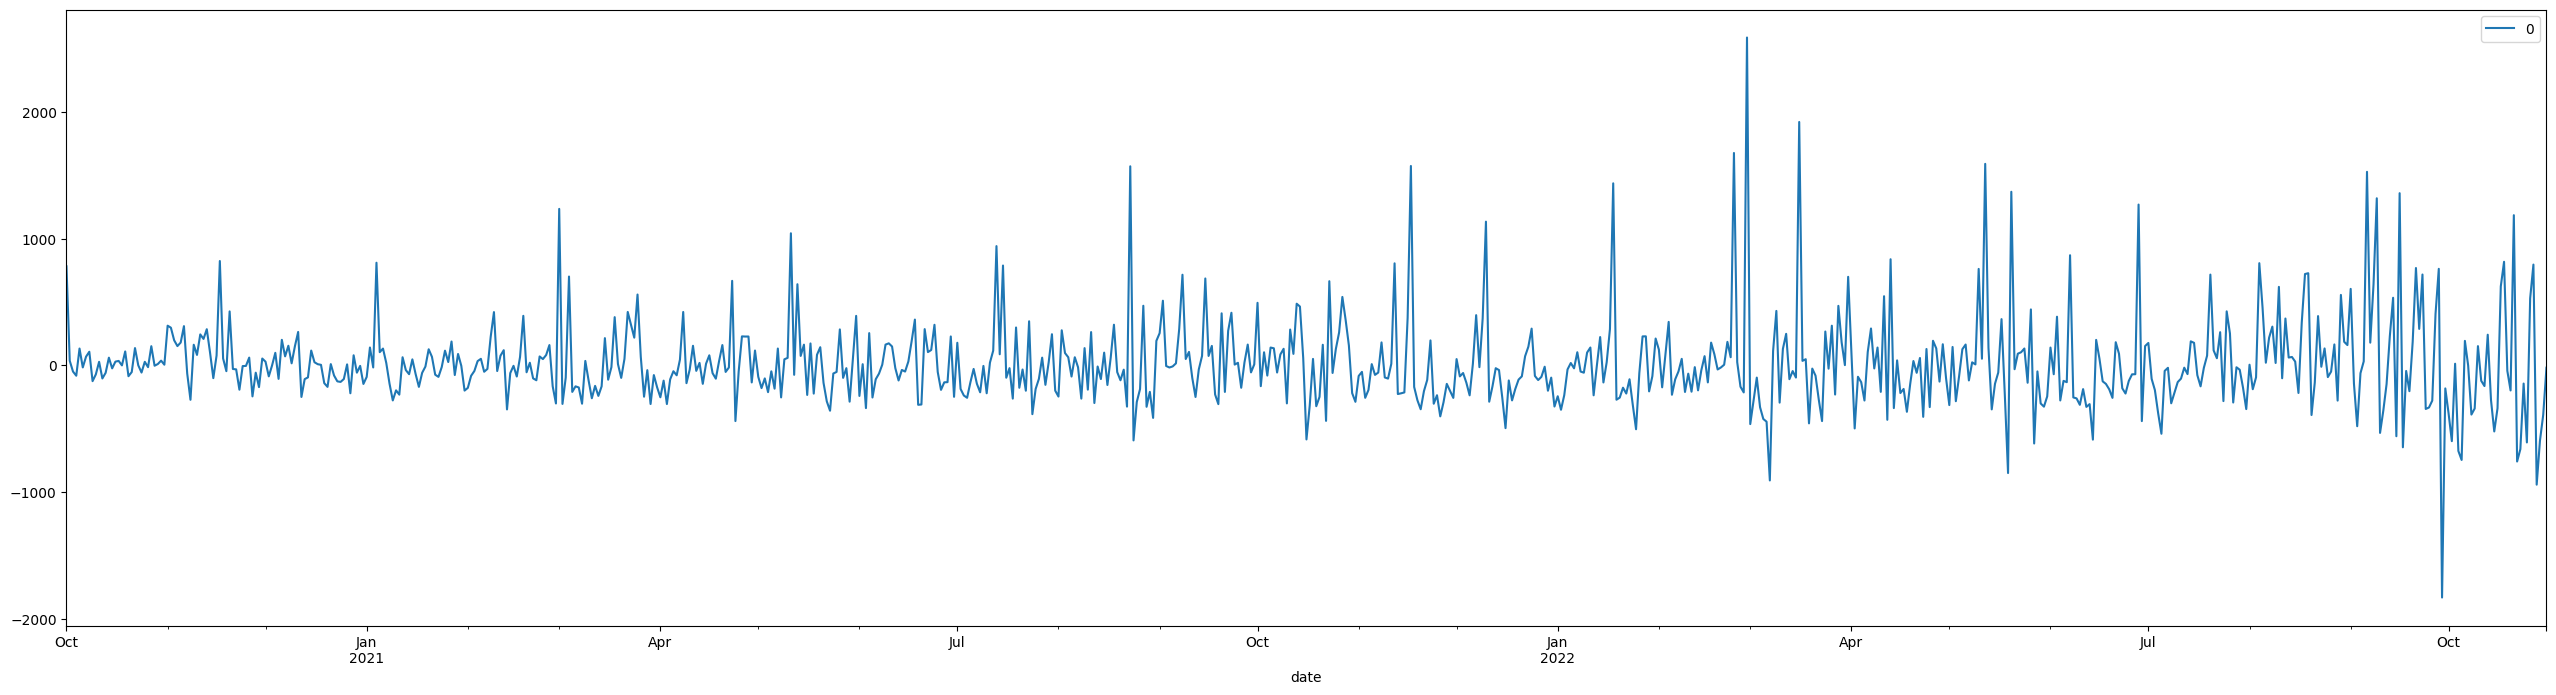

In [ ]:
#Save residuals to a variable named "residuals" and plot them with a simple line
residuals=pd.DataFrame(model_arima.resid)
residuals.plot(figsize=(32,8))
plt.show()

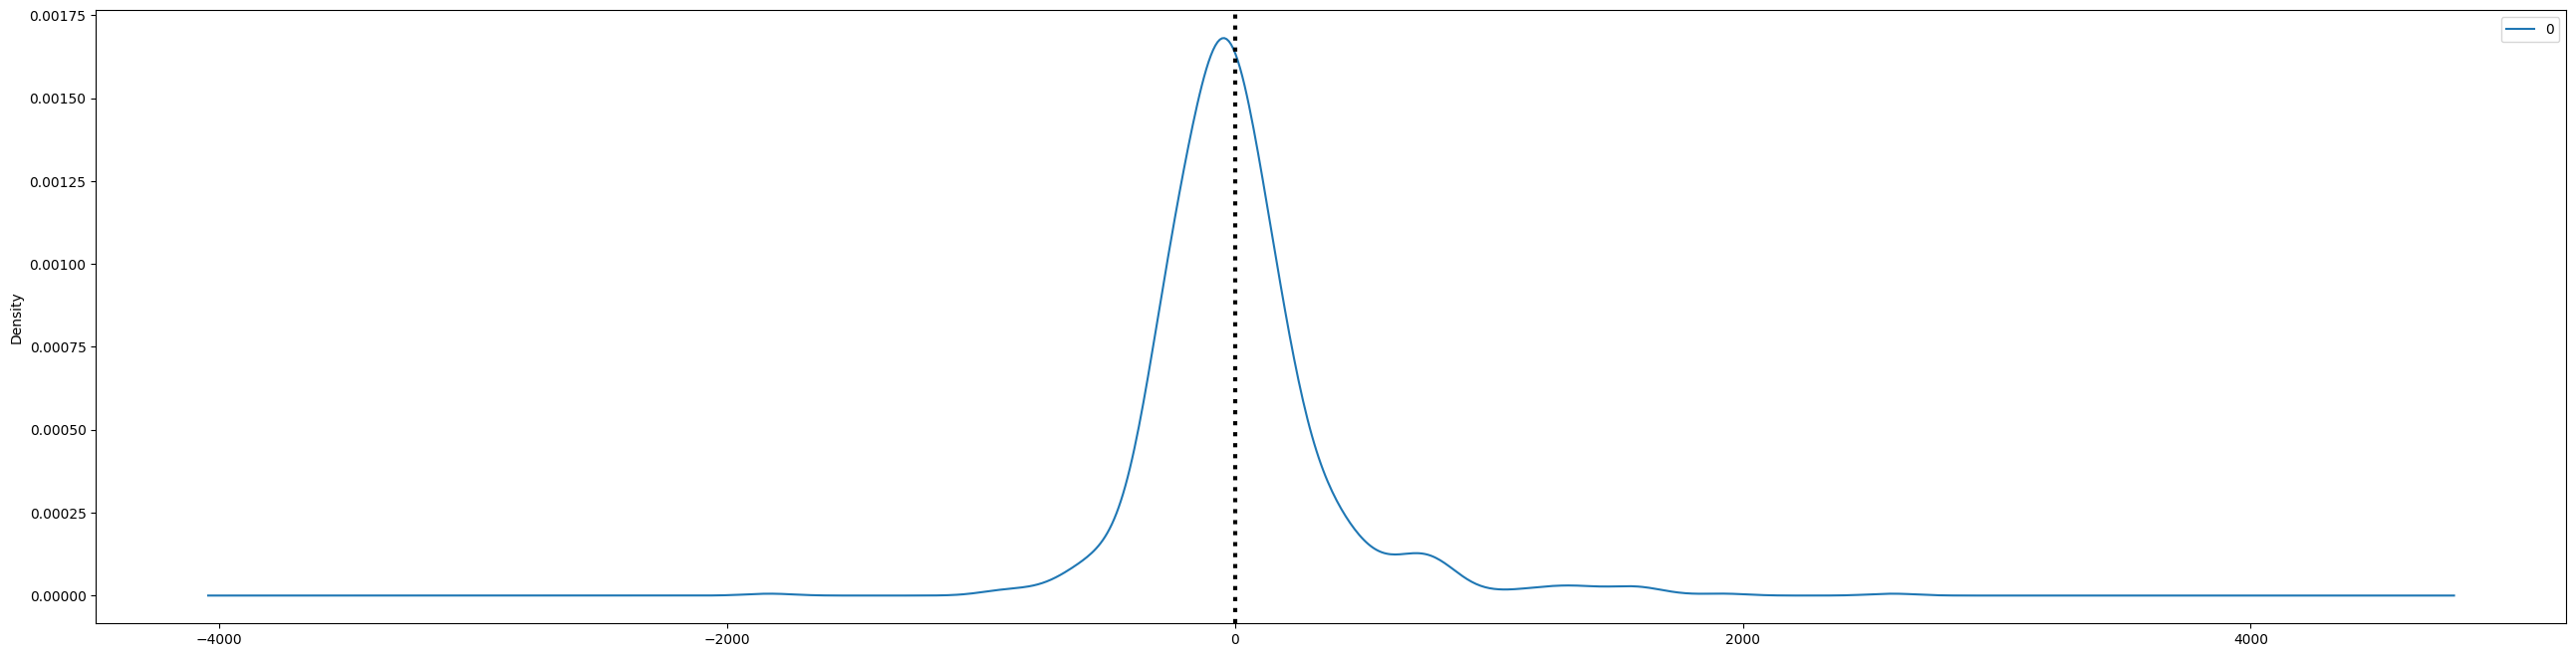

In [ ]:
#Make a density plot of the residuals
residuals.plot(kind='kde', figsize=(32,8))
plt.axvline(x=0, color='black', linewidth=3, label='Zero', linestyle=':')
plt.show()

In general it looks good. The bump on the right side of the Gausian shape that we see it has likely to do with outliers.

## 4.4.

Having learned how to evaluate an ARIMA model, test other options by repeating steps 3 and 4 with other values. Evaluate them and choose the one that seems best!

In [ ]:
#Repeat for other models and choose best one
arima = ARIMA(df_train.nbr_purchases, order=(7,1,2))
model_arima= arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          nbr_purchases   No. Observations:                  761
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -5535.000
Date:                Tue, 02 May 2023   AIC                          11089.999
Time:                        21:16:44   BIC                          11136.333
Sample:                    10-01-2020   HQIC                         11107.841
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3353      0.126      2.670      0.008       0.089       0.581
ar.L2         -0.0016      0.044     -0.036      0.971      -0.087       0.084
ar.L3          0.0558      0.040      1.404      0.1

Best performing model, so far.

In [ ]:
arima = ARIMA(df_train.nbr_purchases, order=(6,1,1))
model_arima= arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          nbr_purchases   No. Observations:                  761
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5538.469
Date:                Tue, 02 May 2023   AIC                          11092.937
Time:                        21:16:46   BIC                          11130.004
Sample:                    10-01-2020   HQIC                         11107.211
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5799      0.097     -5.986      0.000      -0.770      -0.390
ar.L2         -0.5685      0.078     -7.257      0.000      -0.722      -0.415
ar.L3         -0.4900      0.061     -8.095      0.0

The AIC value has raised, so we'll keep the (7, 1, 2) model by now.

In [ ]:
arima = ARIMA(df_train.nbr_purchases, order=(6,1,7))
model_arima= arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          nbr_purchases   No. Observations:                  761
Model:                 ARIMA(6, 1, 7)   Log Likelihood               -5507.073
Date:                Tue, 02 May 2023   AIC                          11042.147
Time:                        21:16:55   BIC                          11107.013
Sample:                    10-01-2020   HQIC                         11067.126
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0399      0.115     -0.348      0.728      -0.265       0.185
ar.L2          0.5140      0.111      4.642      0.000       0.297       0.731
ar.L3         -0.0239      0.056     -0.425      0.6

The AIC has dropped on this model, so for now we will consider the (6, 1, 7) model as reference.

In [ ]:
arima = ARIMA(df_train.nbr_purchases, order=(7,1,7))
model_arima= arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          nbr_purchases   No. Observations:                  761
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -5500.049
Date:                Tue, 02 May 2023   AIC                          11030.098
Time:                        21:17:00   BIC                          11099.598
Sample:                    10-01-2020   HQIC                         11056.861
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0594      0.428     -0.139      0.890      -0.899       0.780
ar.L2         -0.0197      0.420     -0.047      0.962      -0.843       0.803
ar.L3         -0.0903      0.219     -0.412      0.6

The AIC has dropped on this model, so for now we will consider the (7, 1, 7) model as reference.

Also we can see that the Ljung-Box-P is 0.91 so we cannot reject the null hypothesis that the residuals are white noise.

In [ ]:
#Make forecasts and print the RMSE and MAPE on the test set
preds_arima = model_arima.forecast(30)
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_arima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_arima)):.2f}%')

On the test set the RMSE is 392.91
On the test set the MAPE is 19.55%


RMSE and MAPE look better than the first model we've tried (7, 1, 1).

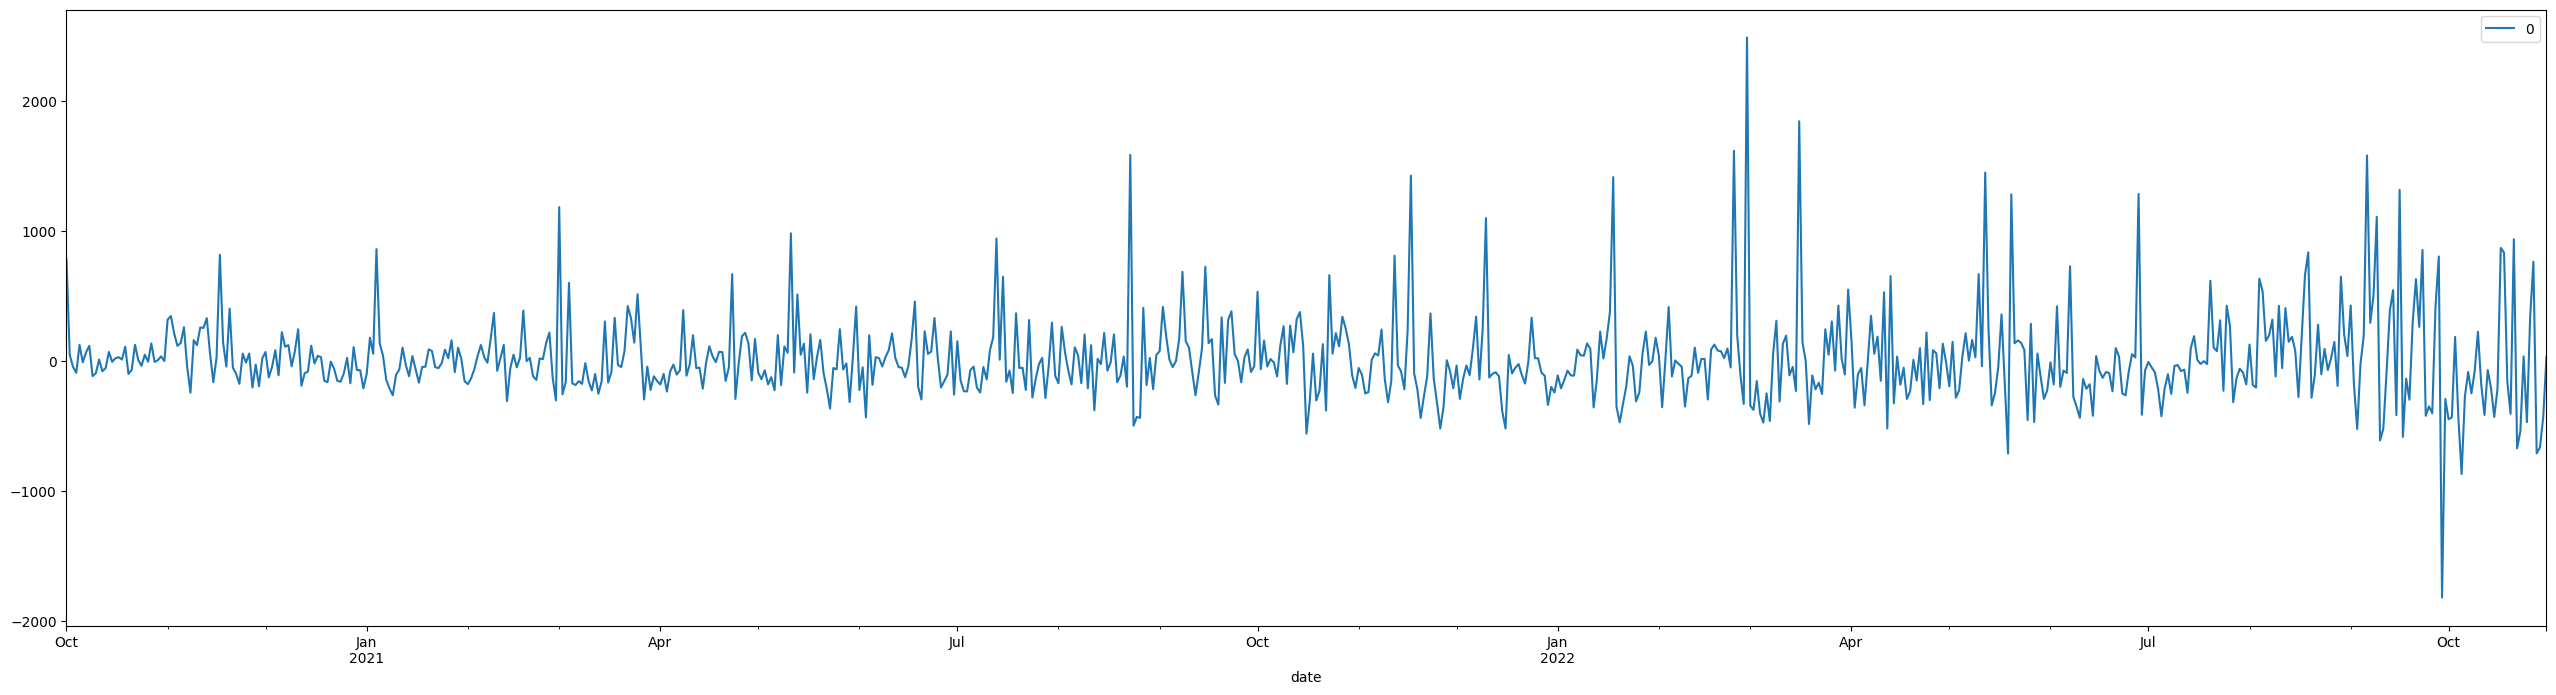

In [ ]:
#Save residuals to a variable named "residuals" and plot them with a simple line
residuals=pd.DataFrame(model_arima.resid)
residuals.plot(figsize=(32,8))
plt.show()

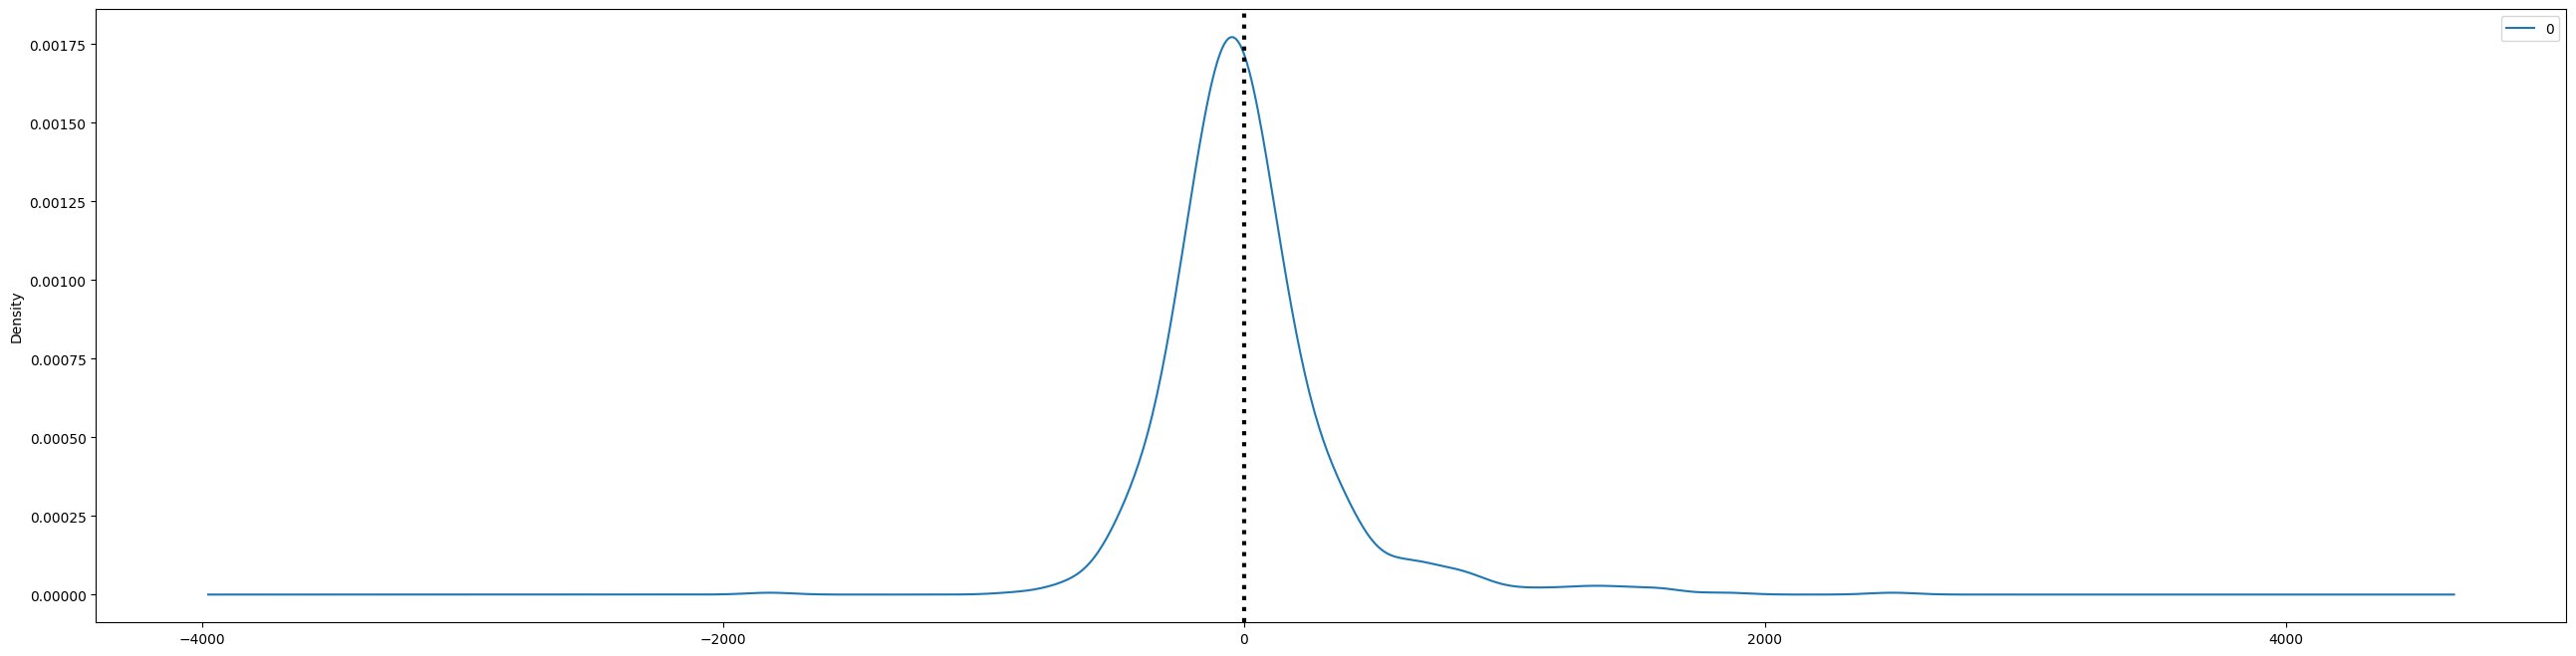

In [ ]:
#Make a density plot of the residuals
residuals.plot(kind='kde', figsize=(32,8))
plt.axvline(x=0, color='black', linewidth=3, label='Zero', linestyle=':')
plt.show()

The density plot looks better than the model (7, 1, 1), and the bump descreased.

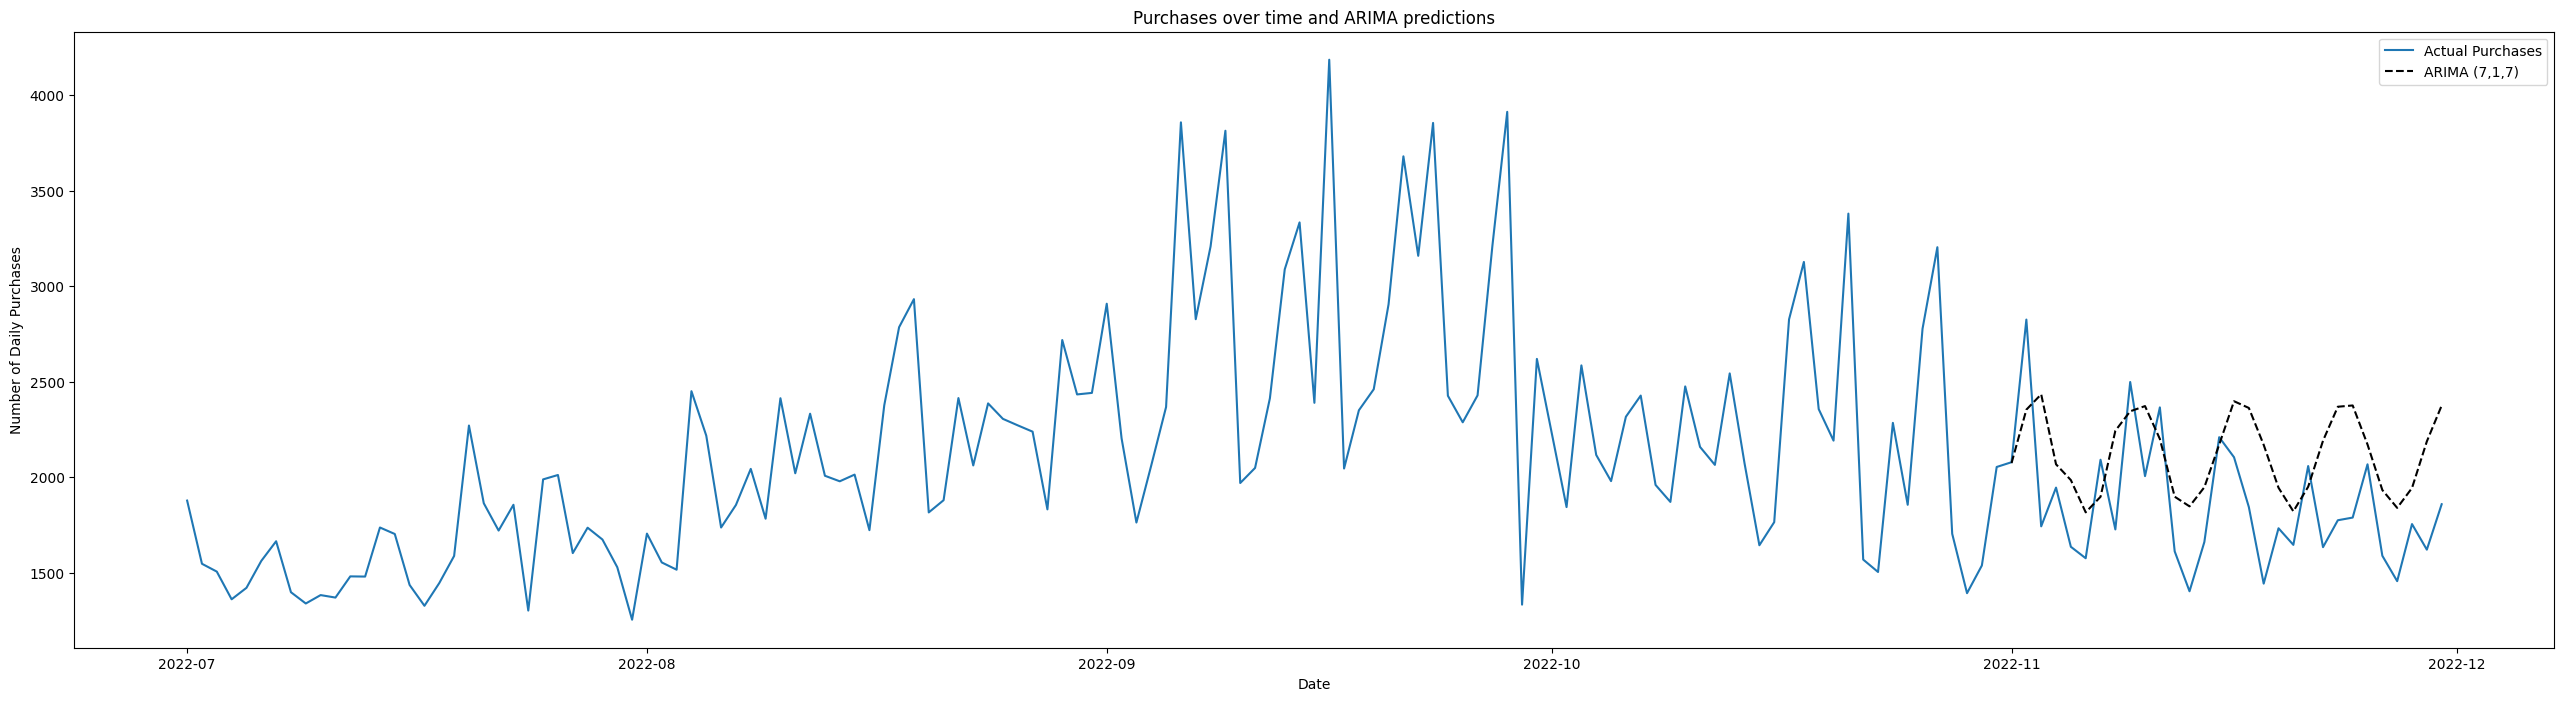


On the test set the RMSE is 392.91
On the test set the MAPE is 19.55%


In [ ]:
df_test['preds_arima'] = preds_arima

plt.figure(figsize=(32,8))
plt.plot(df.loc['2022-07-01':].nbr_purchases, label ='Actual Purchases')
plt.plot(preds_arima,
         color='black',
         linestyle='--',
         label='ARIMA (7,1,7)')
plt.title('Purchases over time and ARIMA predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_arima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_arima)):.2f}%')

Out of the 4 models, this seems to be the one that perfoms best.

## 4.5.

So far you have been manually fitting and tuning the ARIMA. But you can also run the process automatically using the Auto-ARIMA from the auto_arima method of the pmdarima package.

Run a non-seasonal ARIMA and pass it starting `p`, `q`  as well as maximum `p` and `q` hyperparameters (you already know the actual `d` hyperparameter so there’s no need to allow it to search for that one). See what the best combination of hyperparameters is according to auto_arima! How does it compare to the models you found? Which one produces the best RMSE and MAPE?

Once you decide what the best model is, if yours or the Auto ARIMA one, store the 30 day forecasts of that model to a `'preds_arima'` column of the `df_test` and visualize it as well as the `'nbr_purchases'` of the `df_test`.

In [ ]:
#Initialize the Auto ARIMA with hyperparameters
model=pmdarima.auto_arima(df_train.nbr_purchases,
          start_p=7,
          d=1,
          start_q=7,
          max_p=10,
          max_d=1,
          max_q=10,
          start_P=0,
          D=0, start_Q=0, max_P=0,max_D=0,
          max_Q=0, m=7, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(7,1,7)(0,0,0)[0] intercept   : AIC=11029.215, Time=15.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11502.138, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11357.025, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11132.996, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11500.148, Time=0.23 sec
 ARIMA(6,1,7)(0,0,0)[0] intercept   : AIC=11040.678, Time=10.11 sec
 ARIMA(7,1,6)(0,0,0)[0] intercept   : AIC=11033.479, Time=11.72 sec
 ARIMA(8,1,7)(0,0,0)[0] intercept   : AIC=inf, Time=13.38 sec
 ARIMA(7,1,8)(0,0,0)[0] intercept   : AIC=11024.647, Time=10.12 sec
 ARIMA(6,1,8)(0,0,0)[0] intercept   : AIC=inf, Time=12.81 sec
 ARIMA(8,1,8)(0,0,0)[0] intercept   : AIC=inf, Time=17.78 sec
 ARIMA(7,1,9)(0,0,0)[0] intercept   : AIC=11012.254, Time=8.60 sec
 ARIMA(6,1,9)(0,0,0)[0] intercept   : AIC=11006.415, Time=6.62 sec
 ARIMA(5,1,9)(0,0,0)[0] intercept   : AIC=inf, Time=8.05 sec
 ARIMA(6,1,10)(0,0,0)[0] intercept  

In [ ]:
#Initialize and fit an ARIMA model with the best hyperparameters found by Auto ARIMA. Print the summary statistics
arima = ARIMA(df_train.nbr_purchases, order=(6,1,9))
model_auto_arima= arima.fit()
print(model_auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          nbr_purchases   No. Observations:                  761
Model:                 ARIMA(6, 1, 9)   Log Likelihood               -5486.913
Date:                Tue, 02 May 2023   AIC                          11005.827
Time:                        21:20:37   BIC                          11079.960
Sample:                    10-01-2020   HQIC                         11034.374
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0415      0.086    -12.117      0.000      -1.210      -0.873
ar.L2         -0.7111      0.113     -6.294      0.000      -0.933      -0.490
ar.L3         -1.0885      0.061    -17.820      0.0

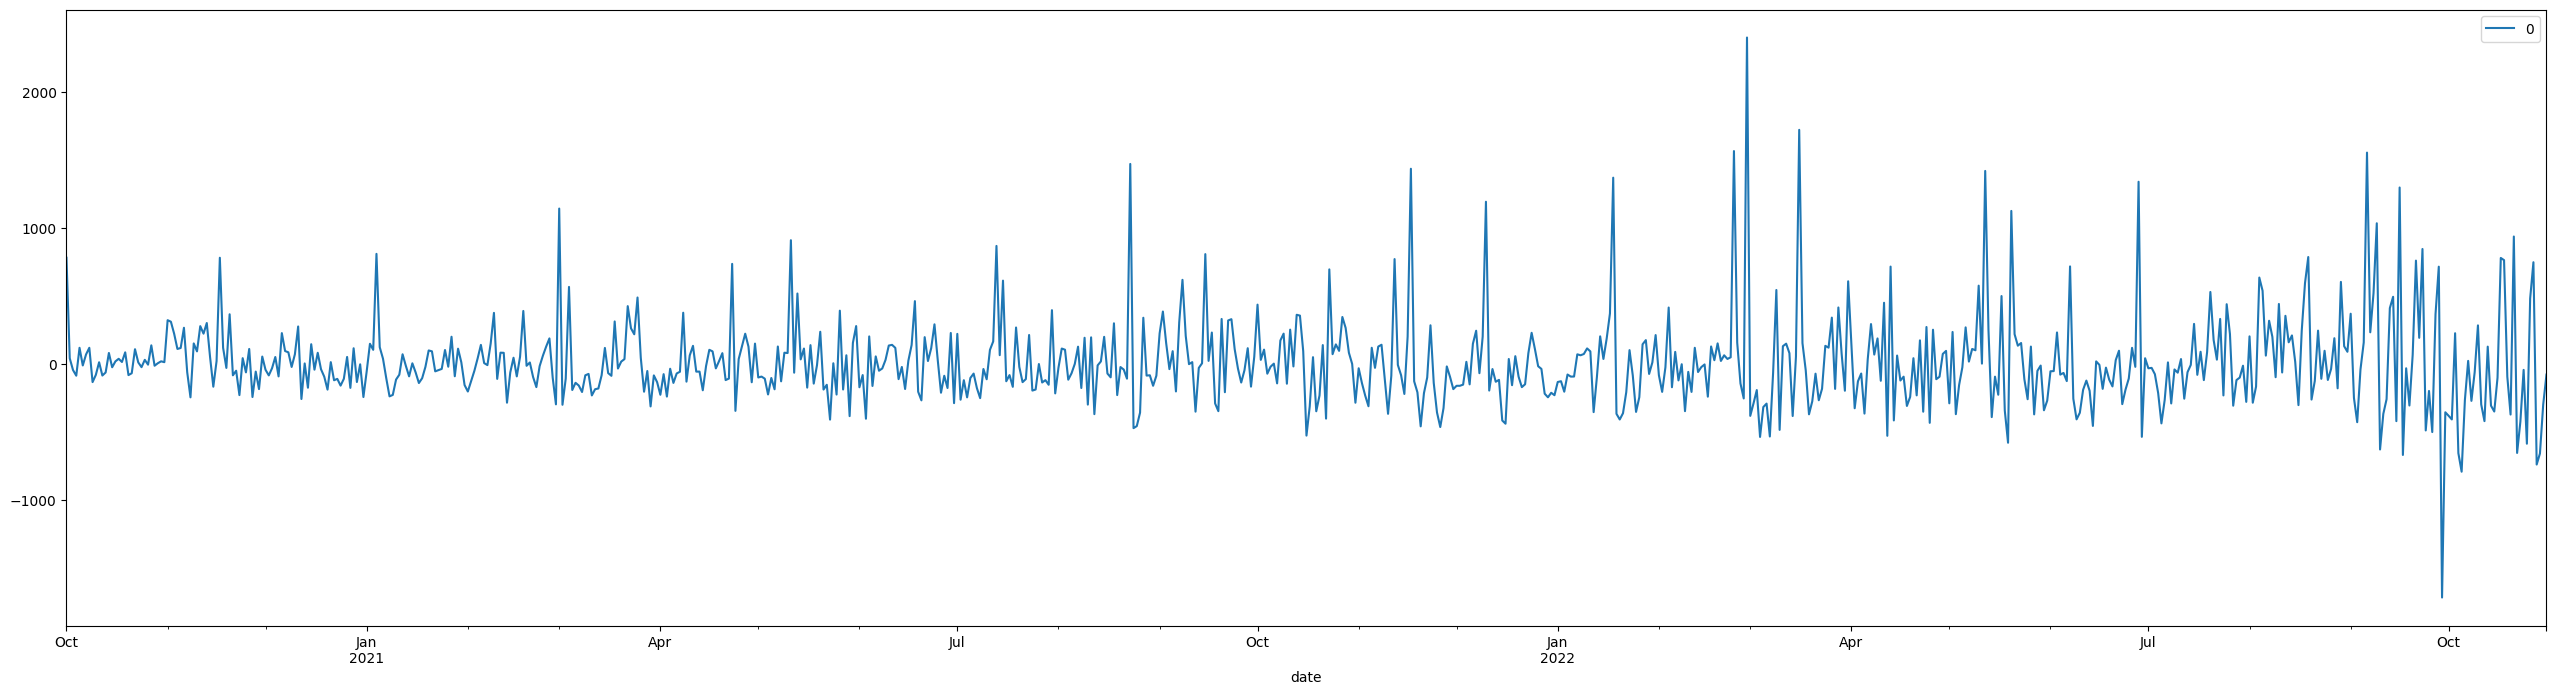

In [ ]:
#Save the residuals and line plot them
residuals=pd.DataFrame(model_auto_arima.resid)
residuals.plot(figsize=(32,8))
plt.show()

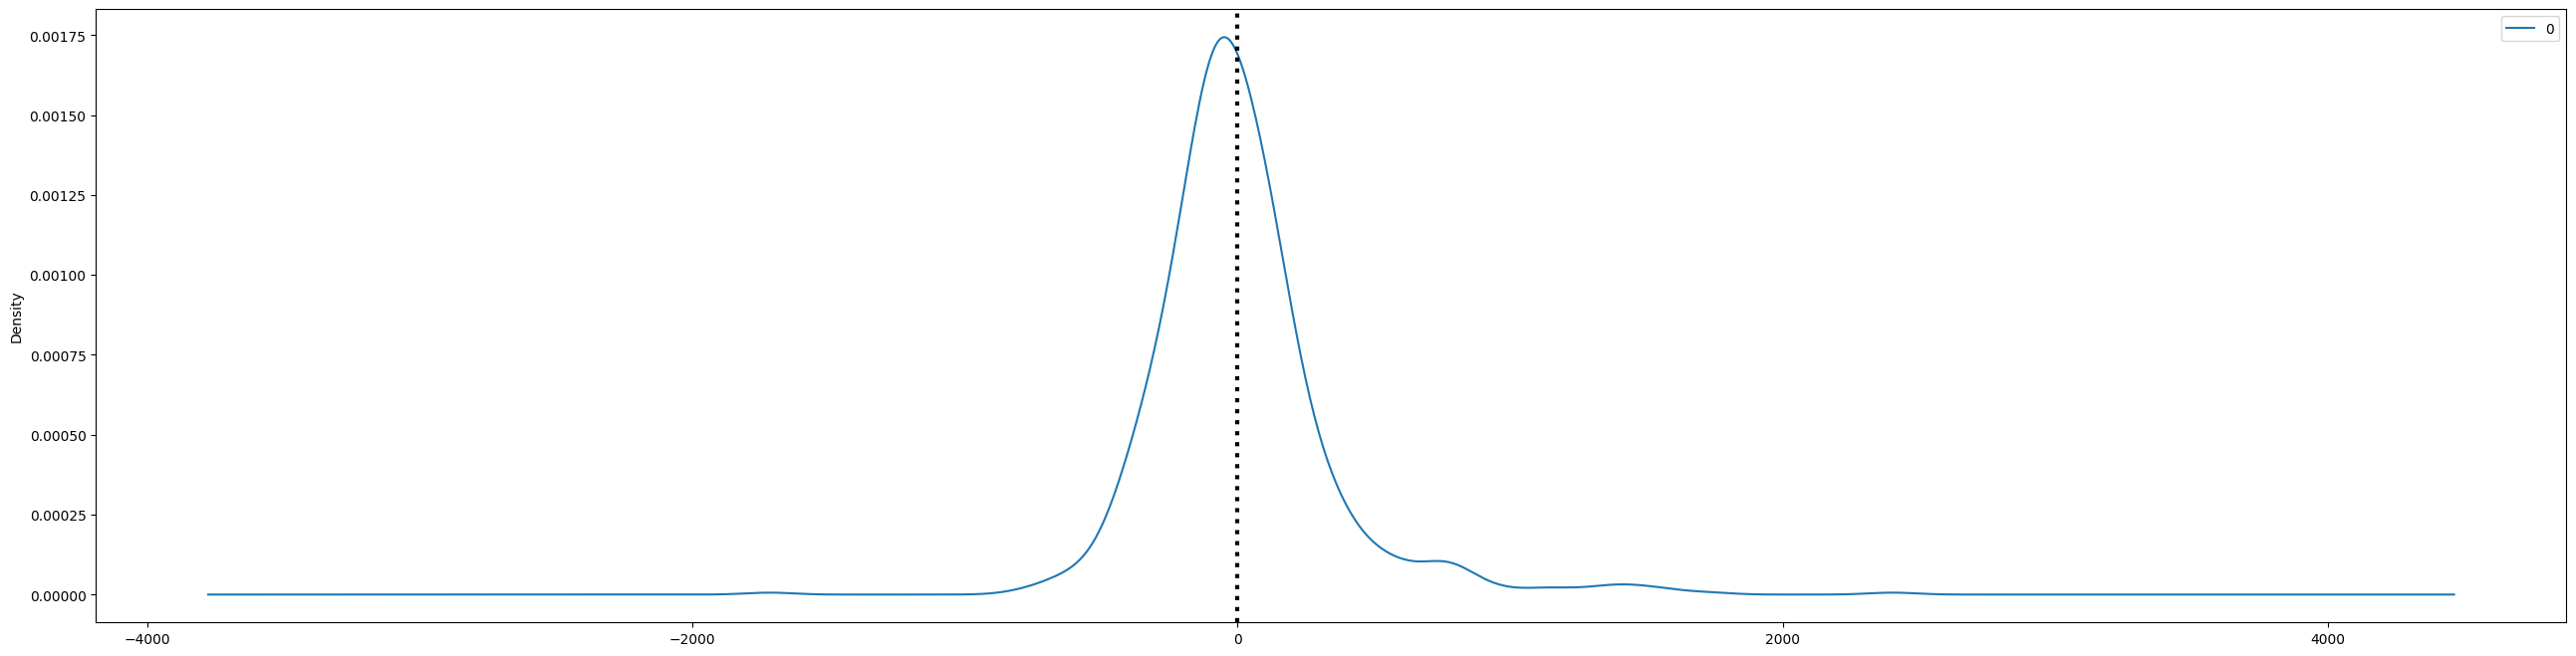

In [ ]:
#Make a density plot of the residuals
residuals.plot(kind='kde', figsize=(32,8))
plt.axvline(x=0, color='black', linewidth=3, label='Zero', linestyle=':')
plt.show()

In [ ]:
#Make forecasts and save them to preds_arima_auto. Print the RMSE/MAPE on the test set.
preds_arima_auto = model_auto_arima.forecast(30)
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_arima_auto)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_arima_auto)):.2f}%')

On the test set the RMSE is 382.24
On the test set the MAPE is 18.78%


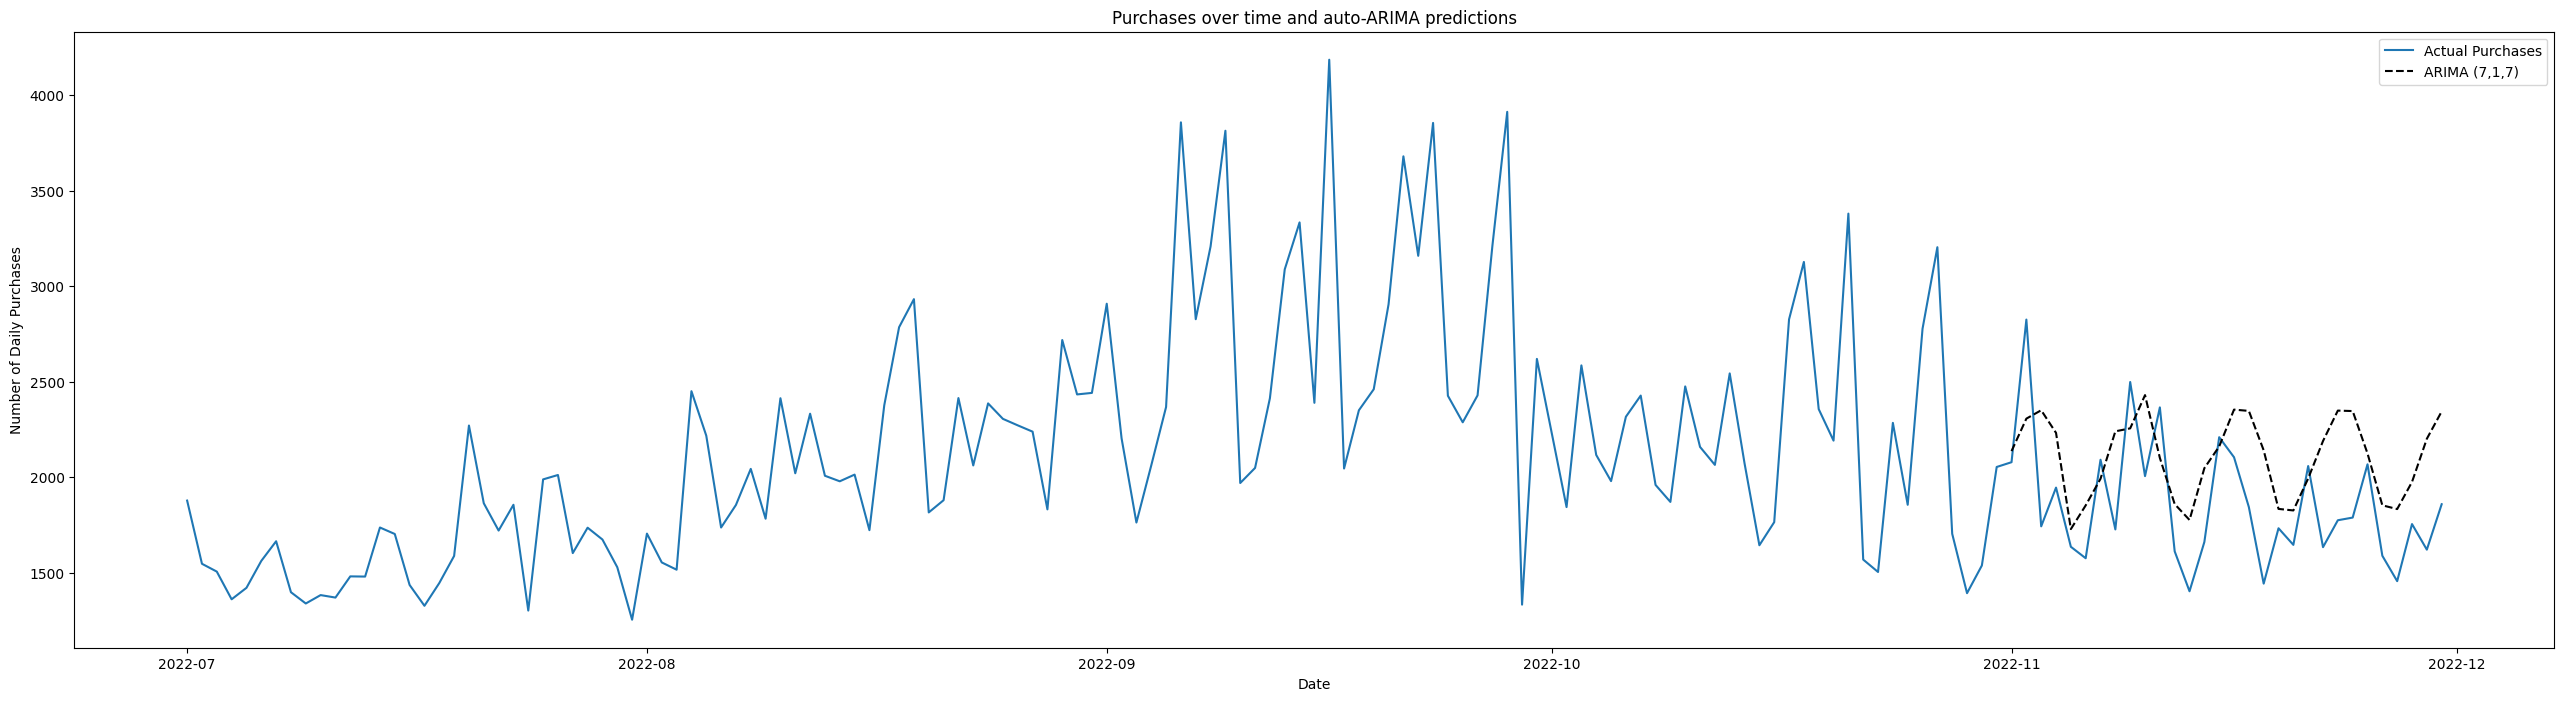


On the test set the RMSE is 382.24
On the test set the MAPE is 18.78%


In [ ]:
#Save the best preduictions to 'preds_arima' on the df_test and visualize them with a line plot
df_test['preds_arima'] = preds_arima_auto

plt.figure(figsize=(32,8))
plt.plot(df.loc['2022-07-01':].nbr_purchases, label ='Actual Purchases')
plt.plot(preds_arima_auto,
         color='black',
         linestyle='--',
         label='ARIMA (7,1,7)')
plt.title('Purchases over time and auto-ARIMA predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_arima_auto)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_arima_auto)):.2f}%')

The best model by now seems to be the (6, 1, 9) as suggested by the auto-arima.

## 5. SARIMA

SARIMA requires the analysis of ACF and PACF after seasonal differencing. This type of differencing is similar to the one you performed in Activity 3 only this time the value is not 1 but rather equal to the seasonality of the time series which in this case is weekly.

After applying the seasonal differencing on top of the first order differencing we can then extract the hyperparameters `p`, `q`, `P`, `Q`.

To obtain the `Q`, we look at the ACF and look for lags that are multiples of the seasonality and choose the one before it gets too close (or below) the significance threshold. Then for `q` we look at lags lower than multiples of seasonality and see when it dips to or below the threshold. That will be a candidate value.

For `P` and `p` the process is the same only we will be using the PACF.

As we previously saw on Activity 3, first order differencing already ensured a stationary time series. We can apply higher order differencing (or in SARIMA's case a seasonal differencing on top of the first order differencing) but if we overdo it we can end up building an unnecessarily complex model, or a less performant one with no necessity. It can be hard to identify when we are overdoing it. One of the ways we can watch out for this phenomenon is to look at ACF's first lag value. If the lag 1 autocorrelation is too negative, then the series is probably over-differenced.


## 5.1.


To get the first order + seasonal differencing, use the `'nbr_purchases_diff_1'` of `df_train` that you calculated previously (that had trend dealt with) and subtract a seven order (weekly) shifted `'nbr_purchases_diff_1'` (dealing with seasonality using `.shift()`). The result is the seasonal + trend differenced `nbr_purchases`.

Save this to a new column on `df_train` called `'nbr_purchases_diff_1_7'`. Then make two plots, one with the original `'nbr_purchases'` of the training set and `'nbr_purchases_diff_1'` and another with the original `'nbr_purchases'` of the training set and `'nbr_purchases_diff_1_7'`.

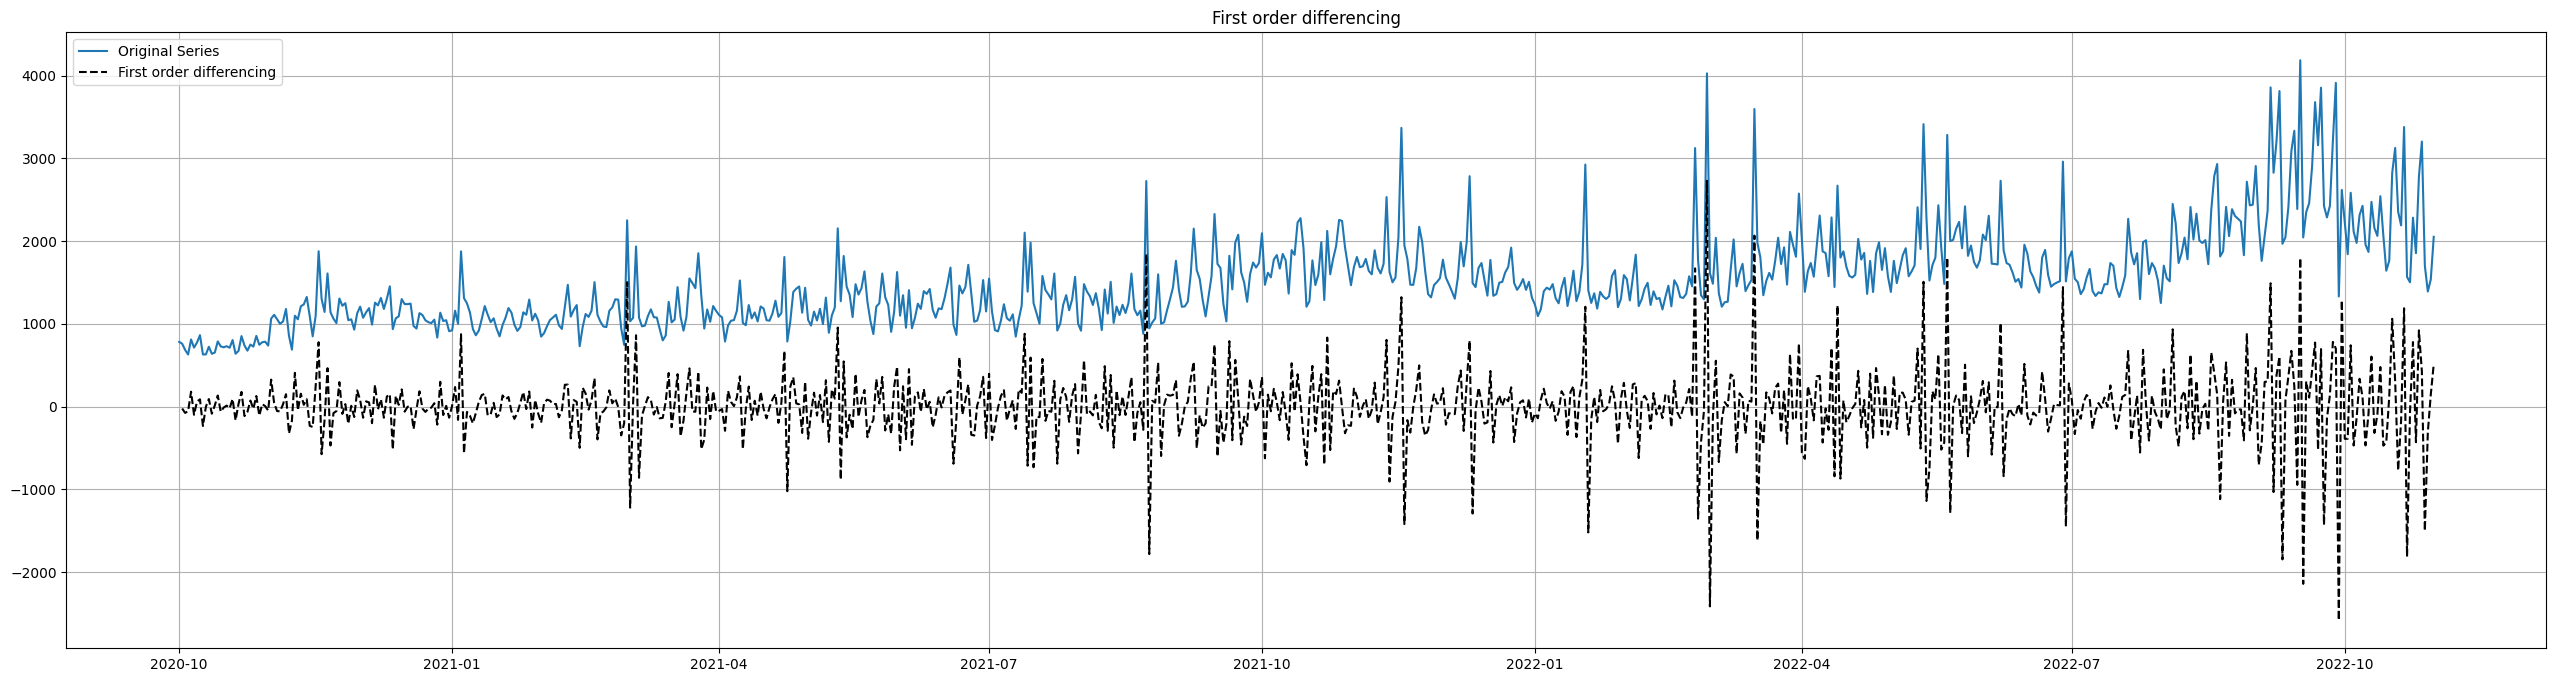

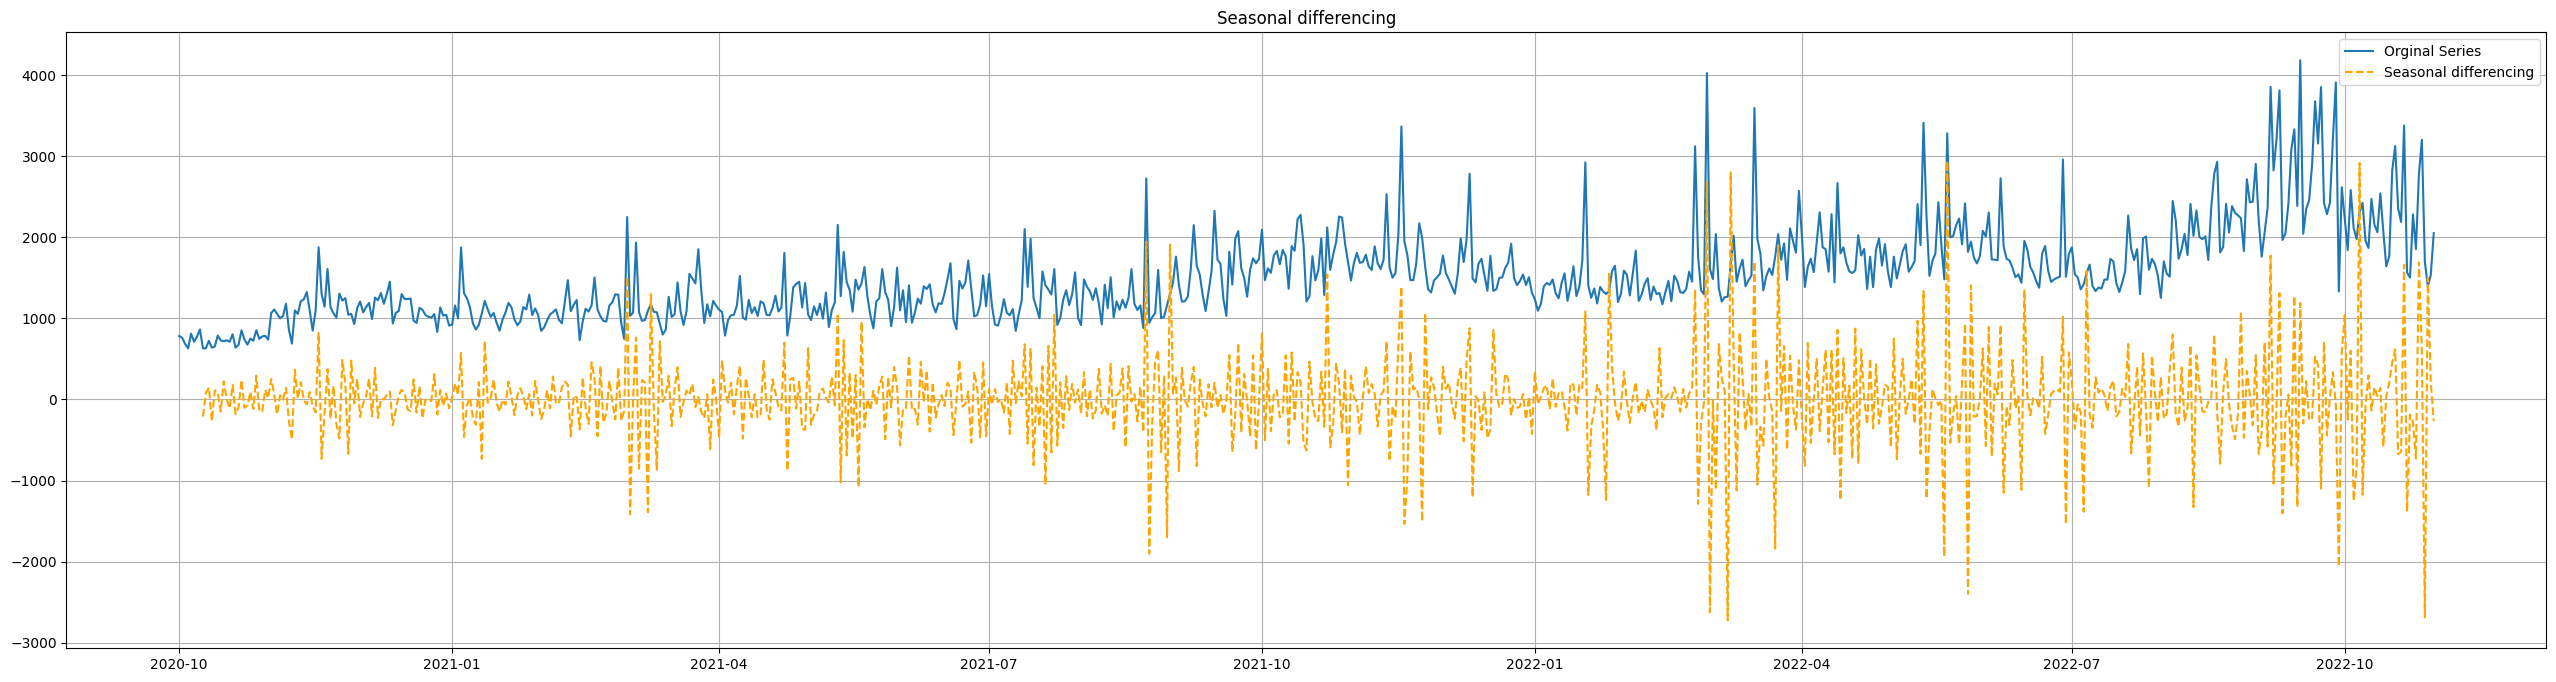

In [ ]:
#Get the trend and seasonal differenced time series and store to nbr_purchases_diff_1_7
df_train['nbr_purchases_diff_1_7'] = df_train.nbr_purchases_diff_1 - df_train.nbr_purchases_diff_1.shift(7)

# Make Plots
# First Order Differencing
plt.figure(figsize=(32,8))
plt.plot(df_train.nbr_purchases, label ='Original Series')
plt.plot(df_train.nbr_purchases_diff_1,
         color='black',
         linestyle='--',
         label='First order differencing')
plt.title('First order differencing')
plt.legend()
plt.grid()
plt.show()

# Seasonal Differencing
plt.figure(figsize=(32,8))
plt.plot(df_train.nbr_purchases, label ='Orginal Series')
plt.plot(df_train.nbr_purchases_diff_1_7,
         color='orange',
         linestyle='--',
         label='Seasonal differencing')
plt.title('Seasonal differencing')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("Observations of Dickey-fuller test")
results_adfuller = adfuller(df_train.nbr_purchases_diff_1_7.dropna(), autolag='AIC')
dickey=pd.Series(results_adfuller[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in results_adfuller[4].items():
    dickey['critical value (%s)'%key]= value
print(dickey)

Observations of Dickey-fuller test
Test Statistic                -1.060915e+01
p-value                        5.895528e-19
#lags used                     2.000000e+01
number of observations used    7.320000e+02
critical value (1%)           -3.439315e+00
critical value (5%)           -2.865497e+00
critical value (10%)          -2.568877e+00
dtype: float64


The values obtained confirm the stationarity.

## 5.2.

Plot the ACF and PACF of the seasonal differenced `'nbr_purchases'`. How do they compare with the ones of the first order differenced `'nbr_purchases'`?

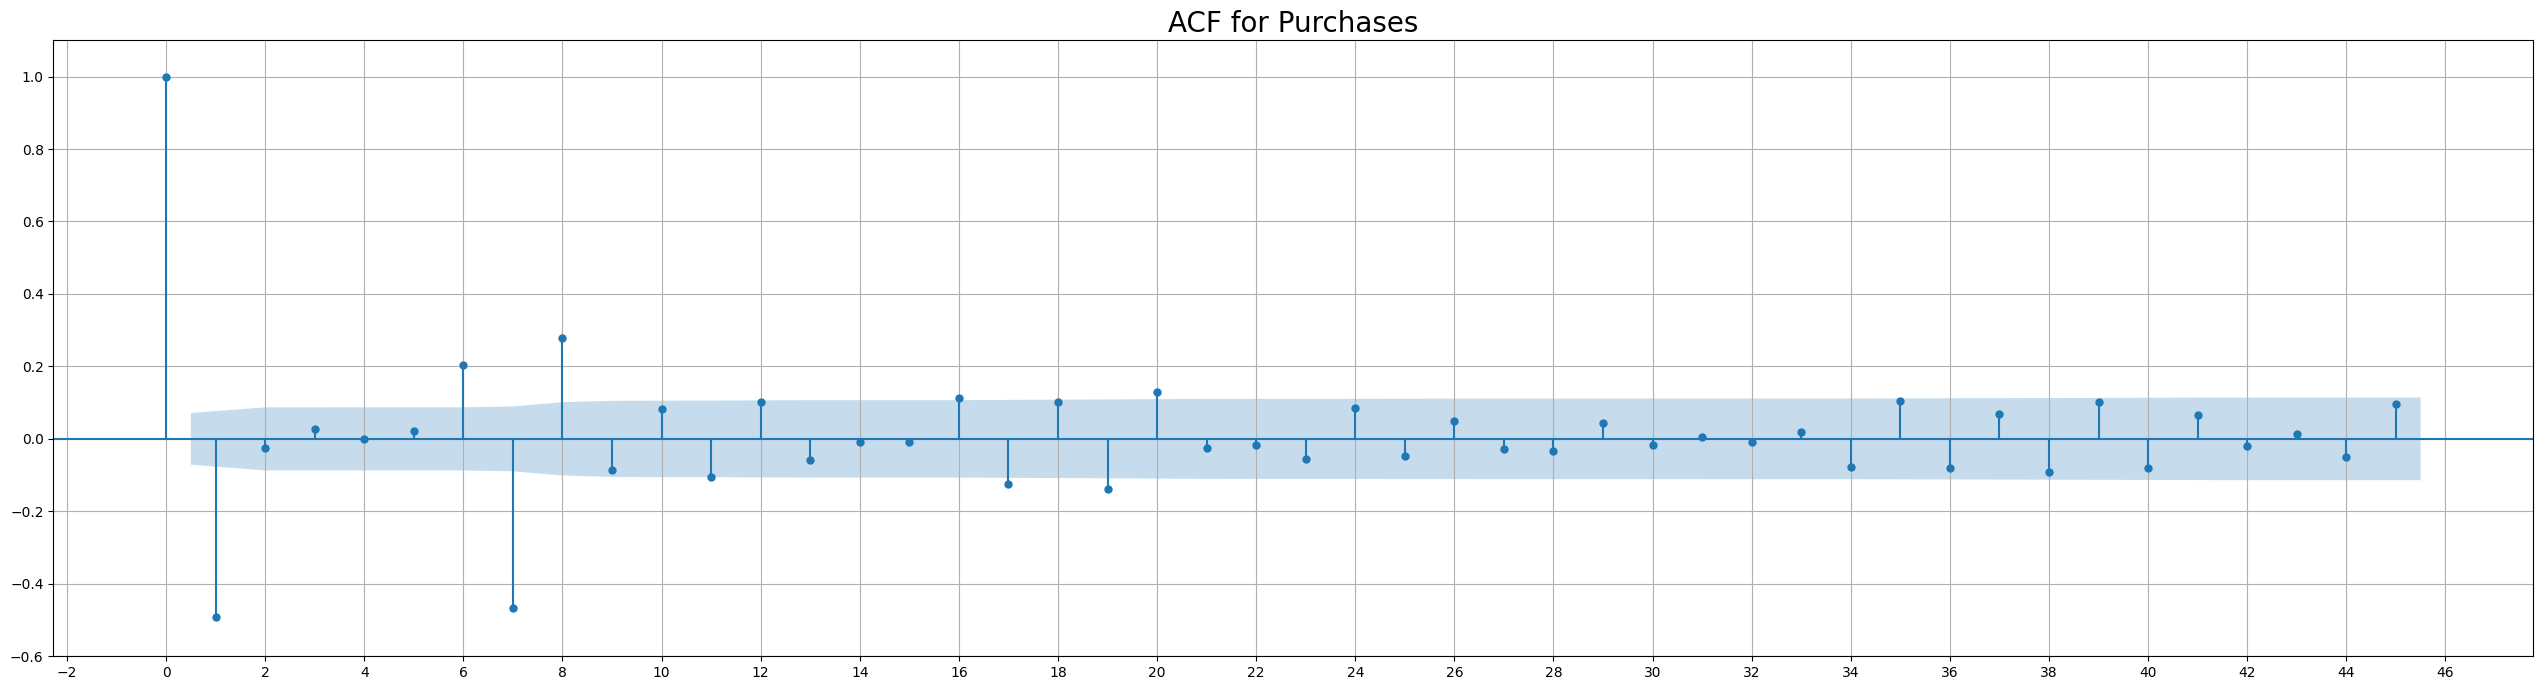

In [ ]:
#Apply ACF
with plt.rc_context():
    plt.rc("figure", figsize=(32,8))
    plot_acf(df_train.nbr_purchases_diff_1_7.dropna(),
             zero = True,
             lags = 45,
             alpha = 0.05)
    plt.title("ACF for Purchases",
              size=20)
    plt.grid()
    plt.ylim(-0.6,1.1)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

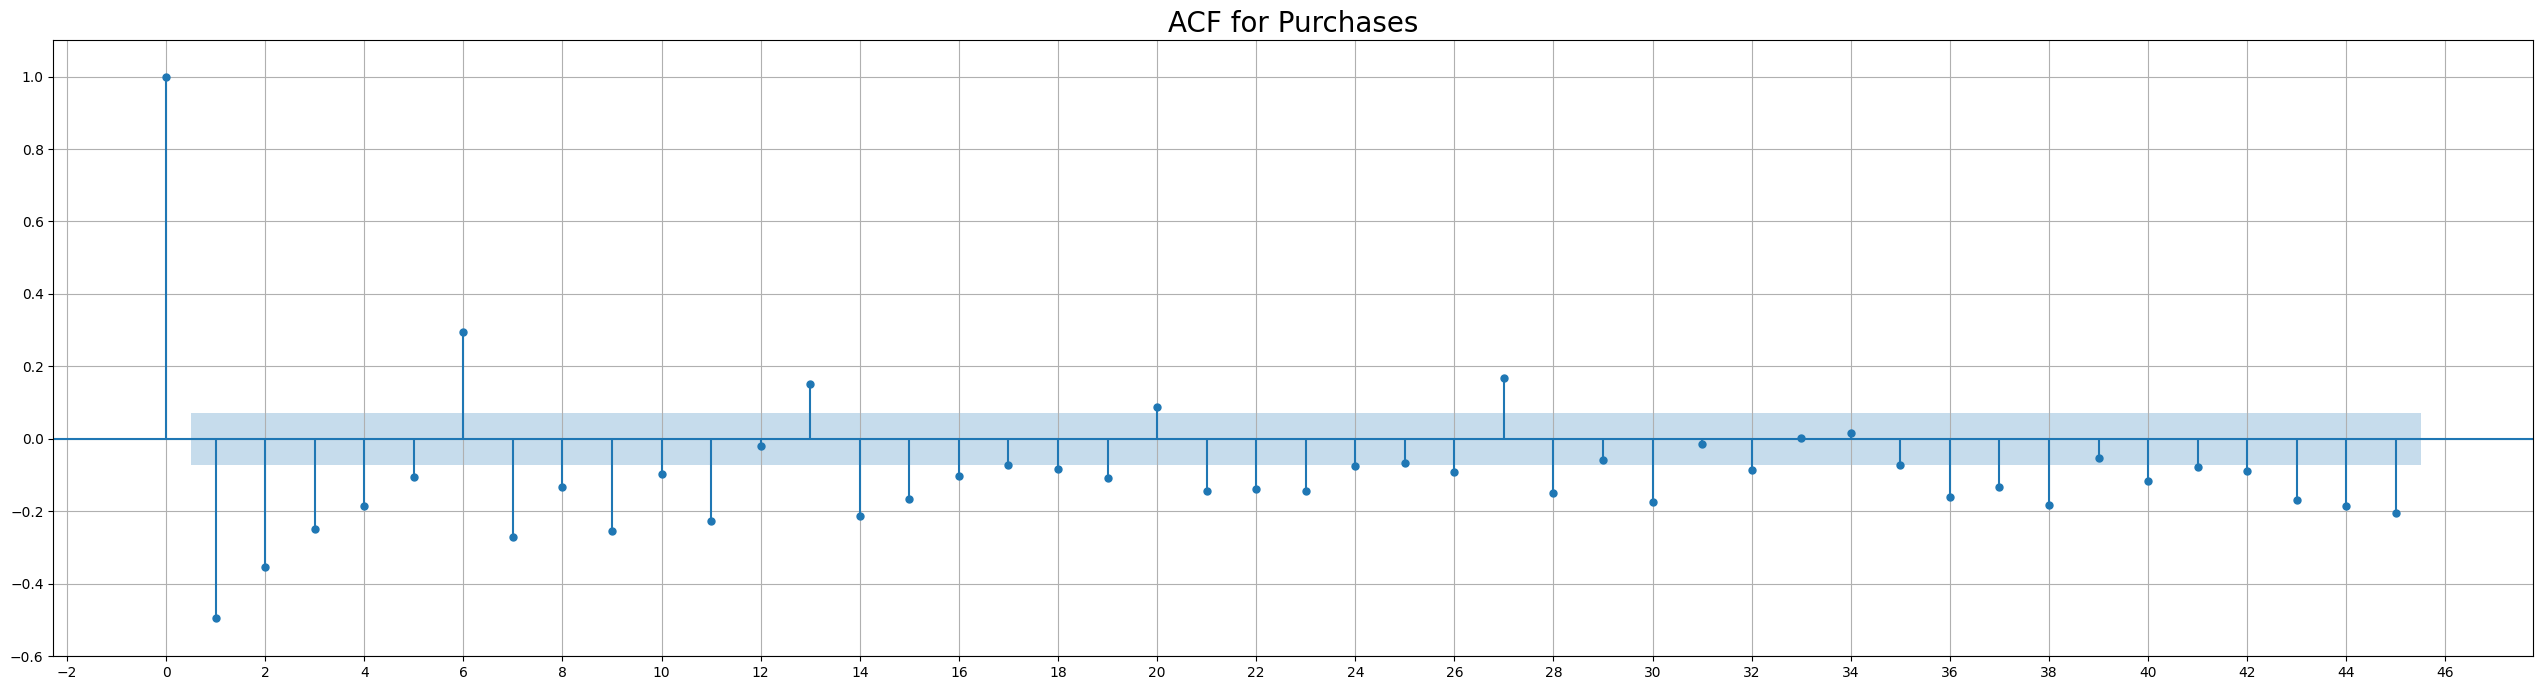

In [ ]:
#Apply PACF
with plt.rc_context():
    plt.rc("figure", figsize=(32,8))
    plot_pacf(df_train.nbr_purchases_diff_1_7.dropna(),
             zero = True,
             lags = 45,
             alpha = 0.05)
    plt.title("ACF for Purchases",
              size=20)
    plt.grid()
    plt.ylim(-0.6,1.1)
    plt.locator_params(axis='x', nbins=50)
    plt.show()

By checking the ACF and PACF we'll consider:

**q=** 1 (lags that go up to the seasonal lag)

**Q=** 1 (lags that go after the seasonal lag)

**p=** 6

**P=** 1 to 4

## 5.3.

Initialize the SARIMA using the `SARIMAX` from `statsmodels.tsa.statespace.sarimax` and giving it the `order` and `seasonal_order` hyperparameters. Then fit it and check the trained model summary.

Try various combinations of hyperparameters and use the summary as well as the test RMSE/MAPE to choose the best combination of hyperparameters.

Optional - Run the auto_arima with `seasonal=True` as well as `p`, `q`, `P` and `Q` start and maximum hyperparameters.

In [ ]:
#Initialize and fit SARIMA model. Print the summary statistics
sarima = SARIMAX(df_train.nbr_purchases,
                 order=(6,1,1),
                 seasonal_order=(2, 1, 1, 7))
model_sarima= sarima.fit()
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     nbr_purchases   No. Observations:                  761
Model:             SARIMAX(6, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -5447.131
Date:                           Tue, 02 May 2023   AIC                          10916.262
Time:                                   21:20:57   BIC                          10967.127
Sample:                               10-01-2020   HQIC                         10935.858
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7573      0.107     -7.057      0.000      -0.968      -0.547
ar.L2         -0.6633      0.102     -6.519

With the Ljung-Box of 99% we cannot say that we don't have whine noise on residuals.

It seems to perform better thant the previous models.

In [ ]:
#Make forecasts and print the RMSE/MAPE on the test set
preds_sarima = model_sarima.forecast(30)
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_sarima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_sarima)):.2f}%')

On the test set the RMSE is 379.80
On the test set the MAPE is 17.75%


RMSE and MAPE show signs of improvment; AIC is lower than the Sarima model.

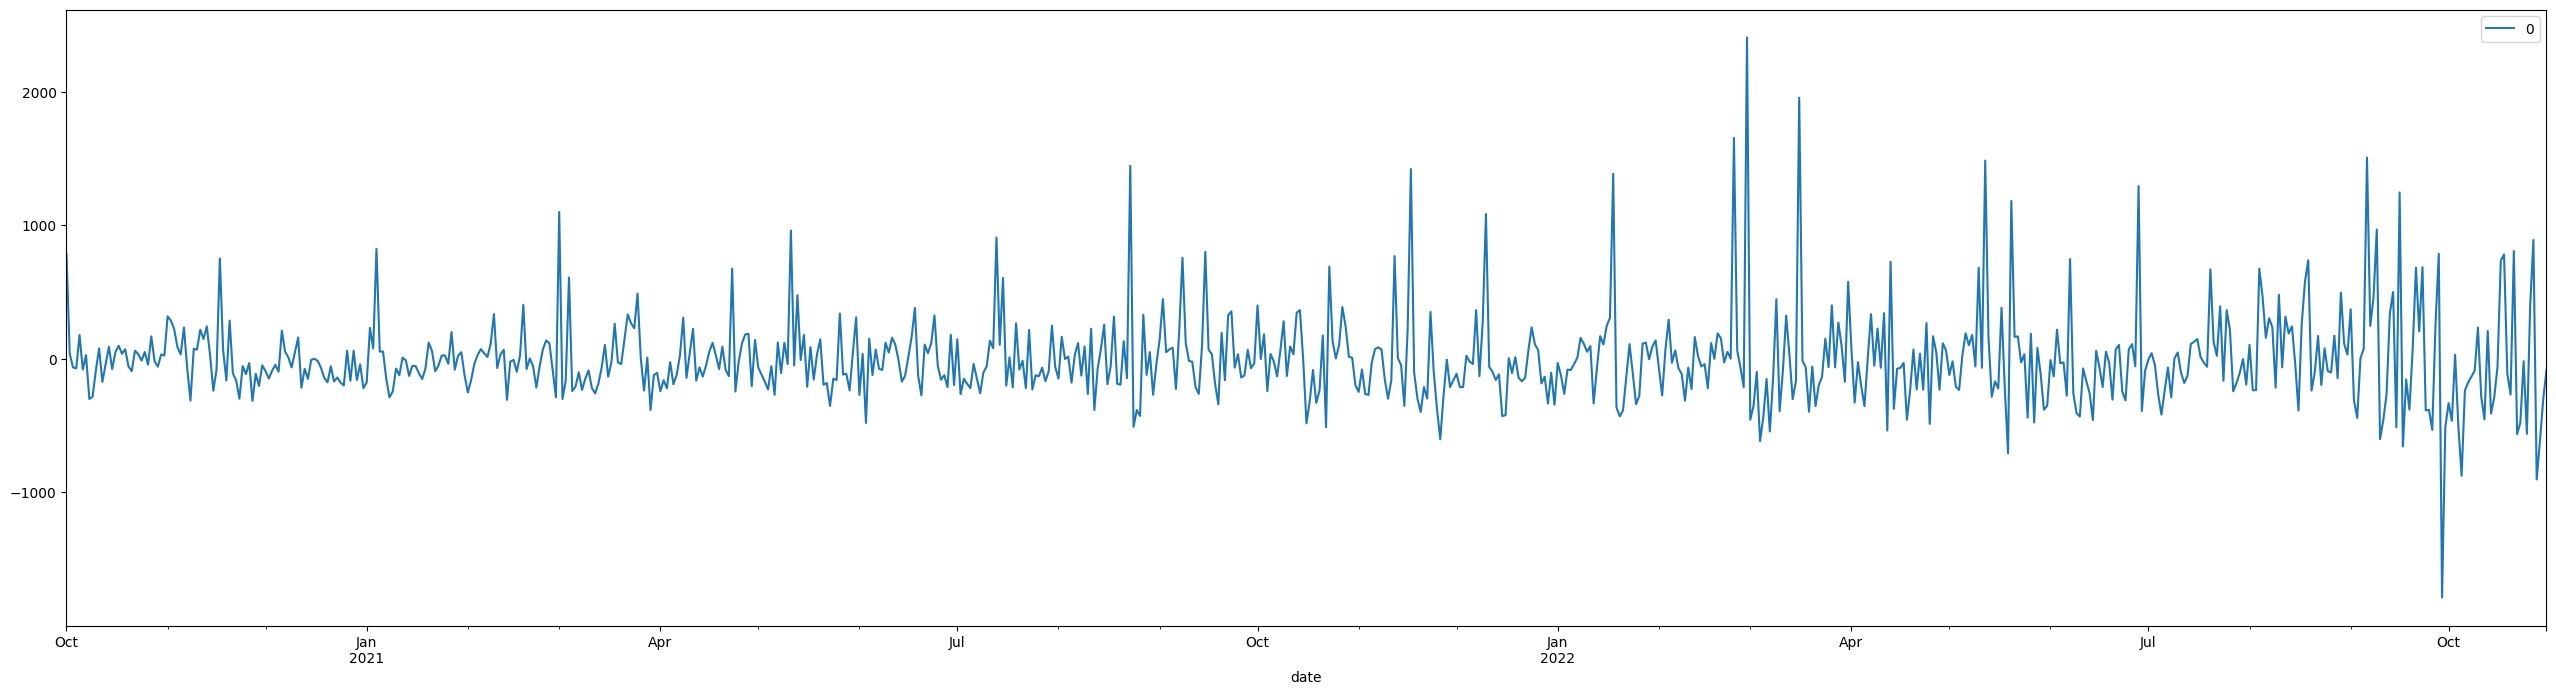

In [ ]:
#Save and line plot the residuals
residuals=pd.DataFrame(model_sarima.resid)
residuals.plot(figsize=(32,8))
plt.show()

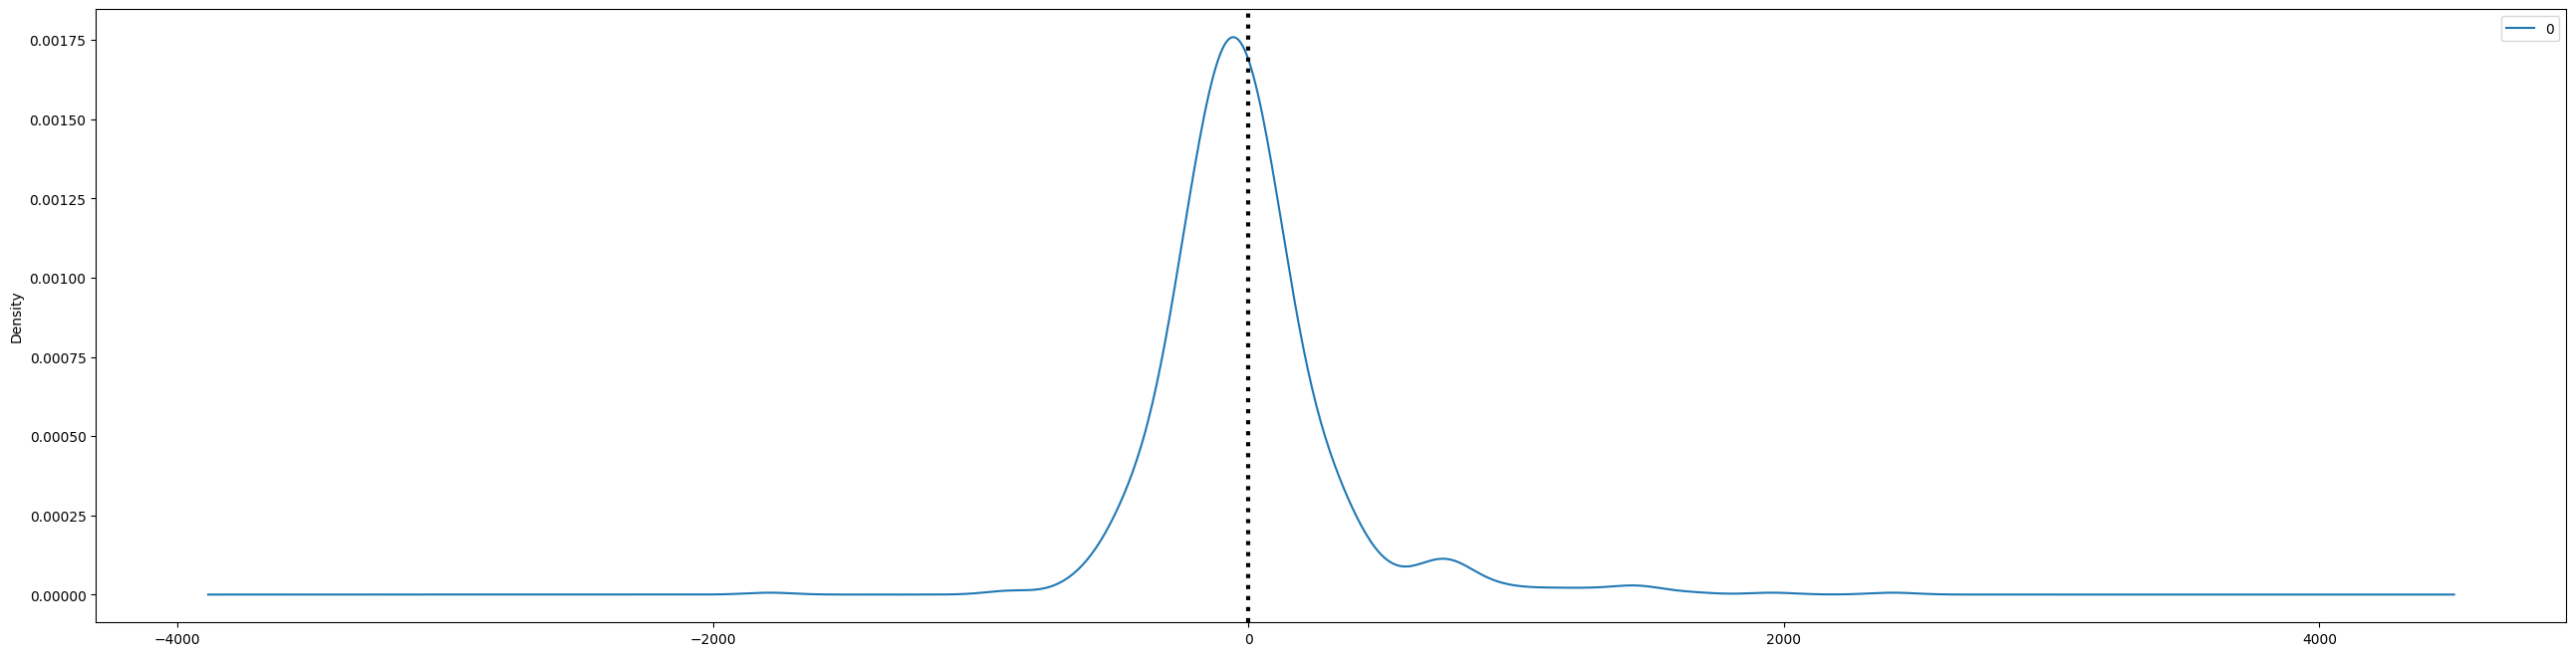

In [ ]:
#Make a density plot of the residuals
residuals.plot(kind='kde', figsize=(32,8))
plt.axvline(x=0, color='black', linewidth=3, label='Zero', linestyle=':')
plt.show()

In [ ]:
sarima = SARIMAX(df_train.nbr_purchases,
                 order=(6,1,1),
                 seasonal_order=(3, 1, 1, 7))
model_sarima= sarima.fit()
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     nbr_purchases   No. Observations:                  761
Model:             SARIMAX(6, 1, 1)x(3, 1, 1, 7)   Log Likelihood               -5461.109
Date:                           Tue, 02 May 2023   AIC                          10946.219
Time:                                   21:21:21   BIC                          11001.707
Sample:                               10-01-2020   HQIC                         10967.596
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1681      0.090      1.868      0.062      -0.008       0.344
ar.L2          0.1596      0.077      2.078

Ljung-Box-P is alright but the AIC is worse than the previous model.

In [ ]:
#Make forecasts and print the RMSE/MAPE on the test set
preds_sarima = model_sarima.forecast(30)
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_sarima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_sarima)):.2f}%')

On the test set the RMSE is 300.60
On the test set the MAPE is 13.11%


The RMSE and MAPE have dropped.

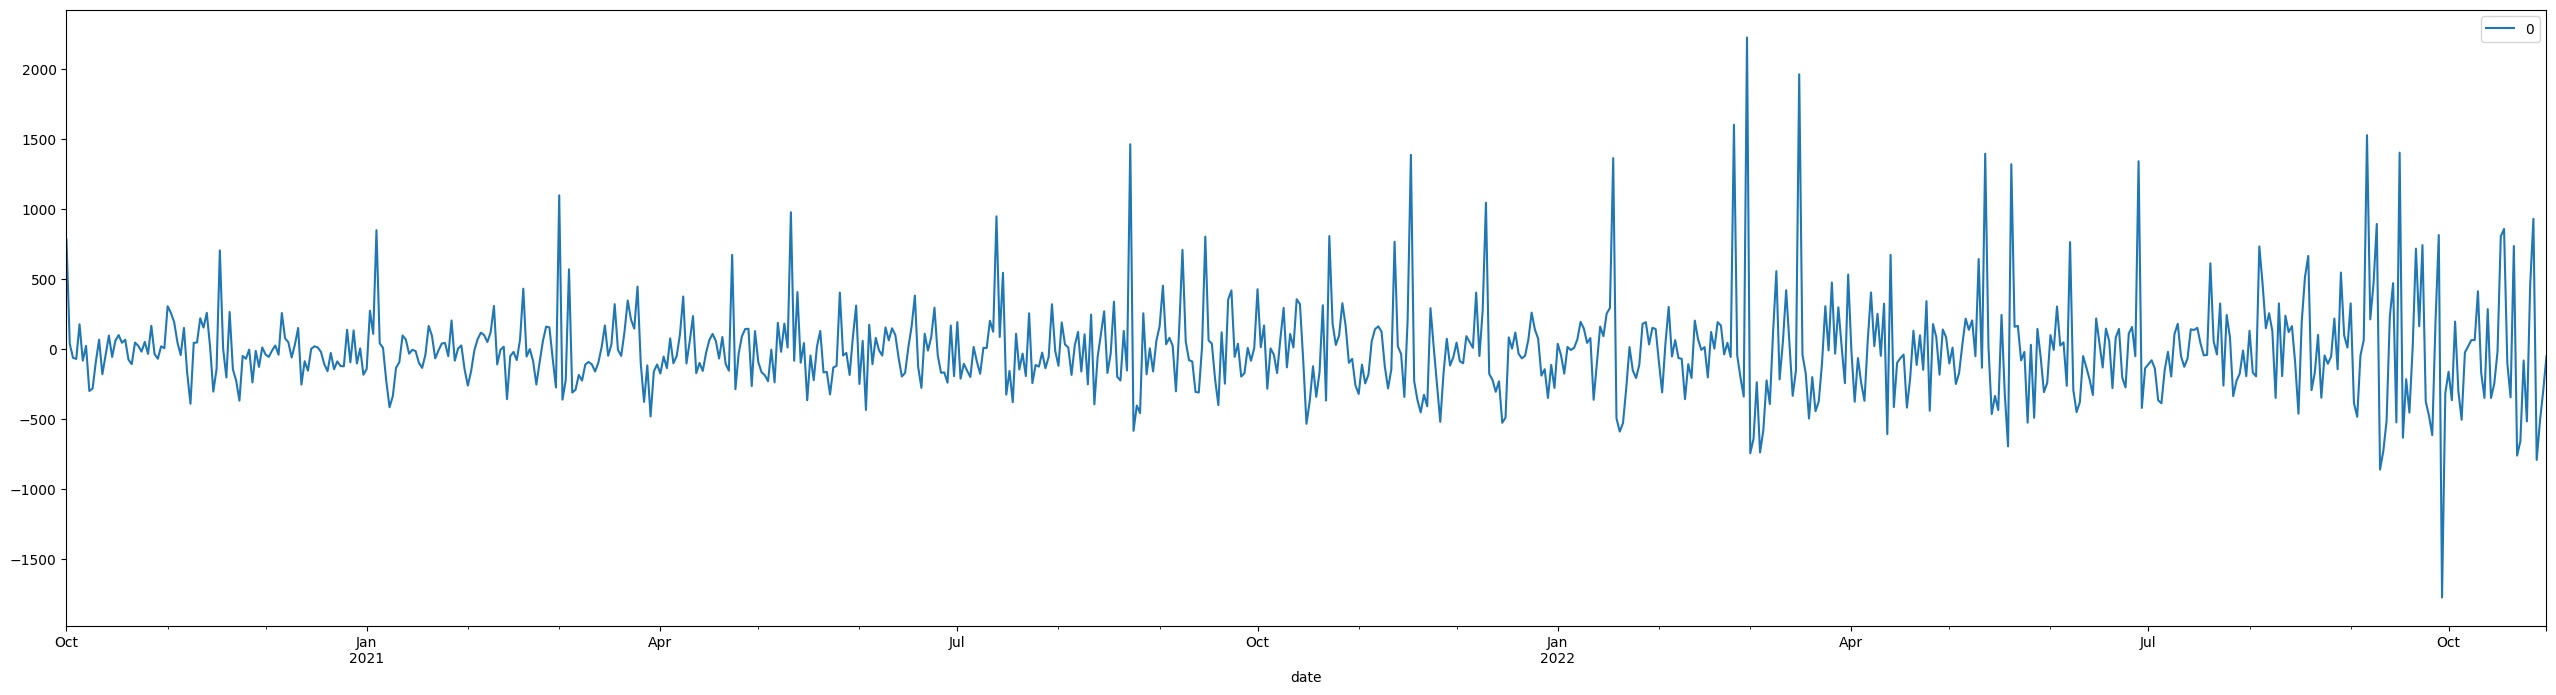

In [ ]:
#Save and line plot the residuals
residuals=pd.DataFrame(model_sarima.resid)
residuals.plot(figsize=(32,8))
plt.show()

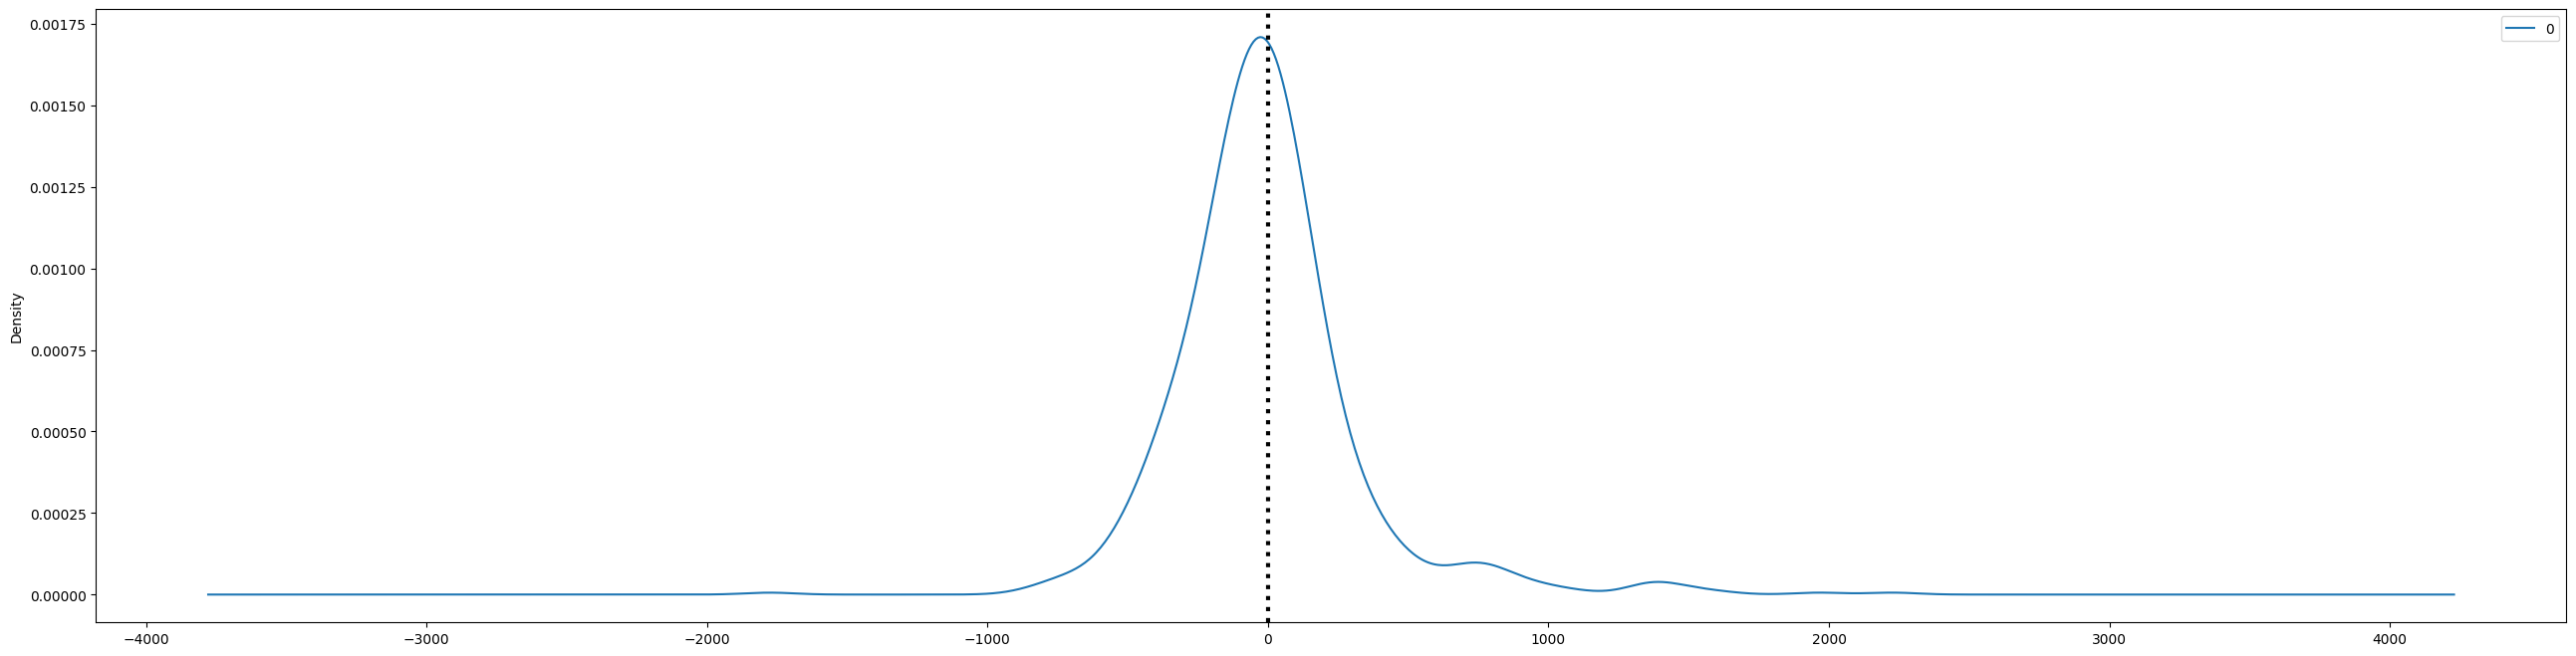

In [ ]:
#Make a density plot of the residuals
residuals.plot(kind='kde', figsize=(32,8))
plt.axvline(x=0, color='black', linewidth=3, label='Zero', linestyle=':')
plt.show()

Not many changes considering the previous model.

In [ ]:
sarima = SARIMAX(df_train.nbr_purchases,
                 order=(6,1,1),
                 seasonal_order=(4, 1, 1, 7))
model_sarima= sarima.fit()
print(model_sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     nbr_purchases   No. Observations:                  761
Model:             SARIMAX(6, 1, 1)x(4, 1, 1, 7)   Log Likelihood               -5449.636
Date:                           Tue, 02 May 2023   AIC                          10925.272
Time:                                   21:21:56   BIC                          10985.385
Sample:                               10-01-2020   HQIC                         10948.431
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1445      0.036      4.044      0.000       0.074       0.215
ar.L2          0.1065      0.036      2.956

The AIC is worse.

In [ ]:
#Make forecasts and print the RMSE/MAPE on the test set
preds_sarima = model_sarima.forecast(30)
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_sarima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_sarima)):.2f}%')

On the test set the RMSE is 506.55
On the test set the MAPE is 25.65%


RMSE and MAPE performance are worse.

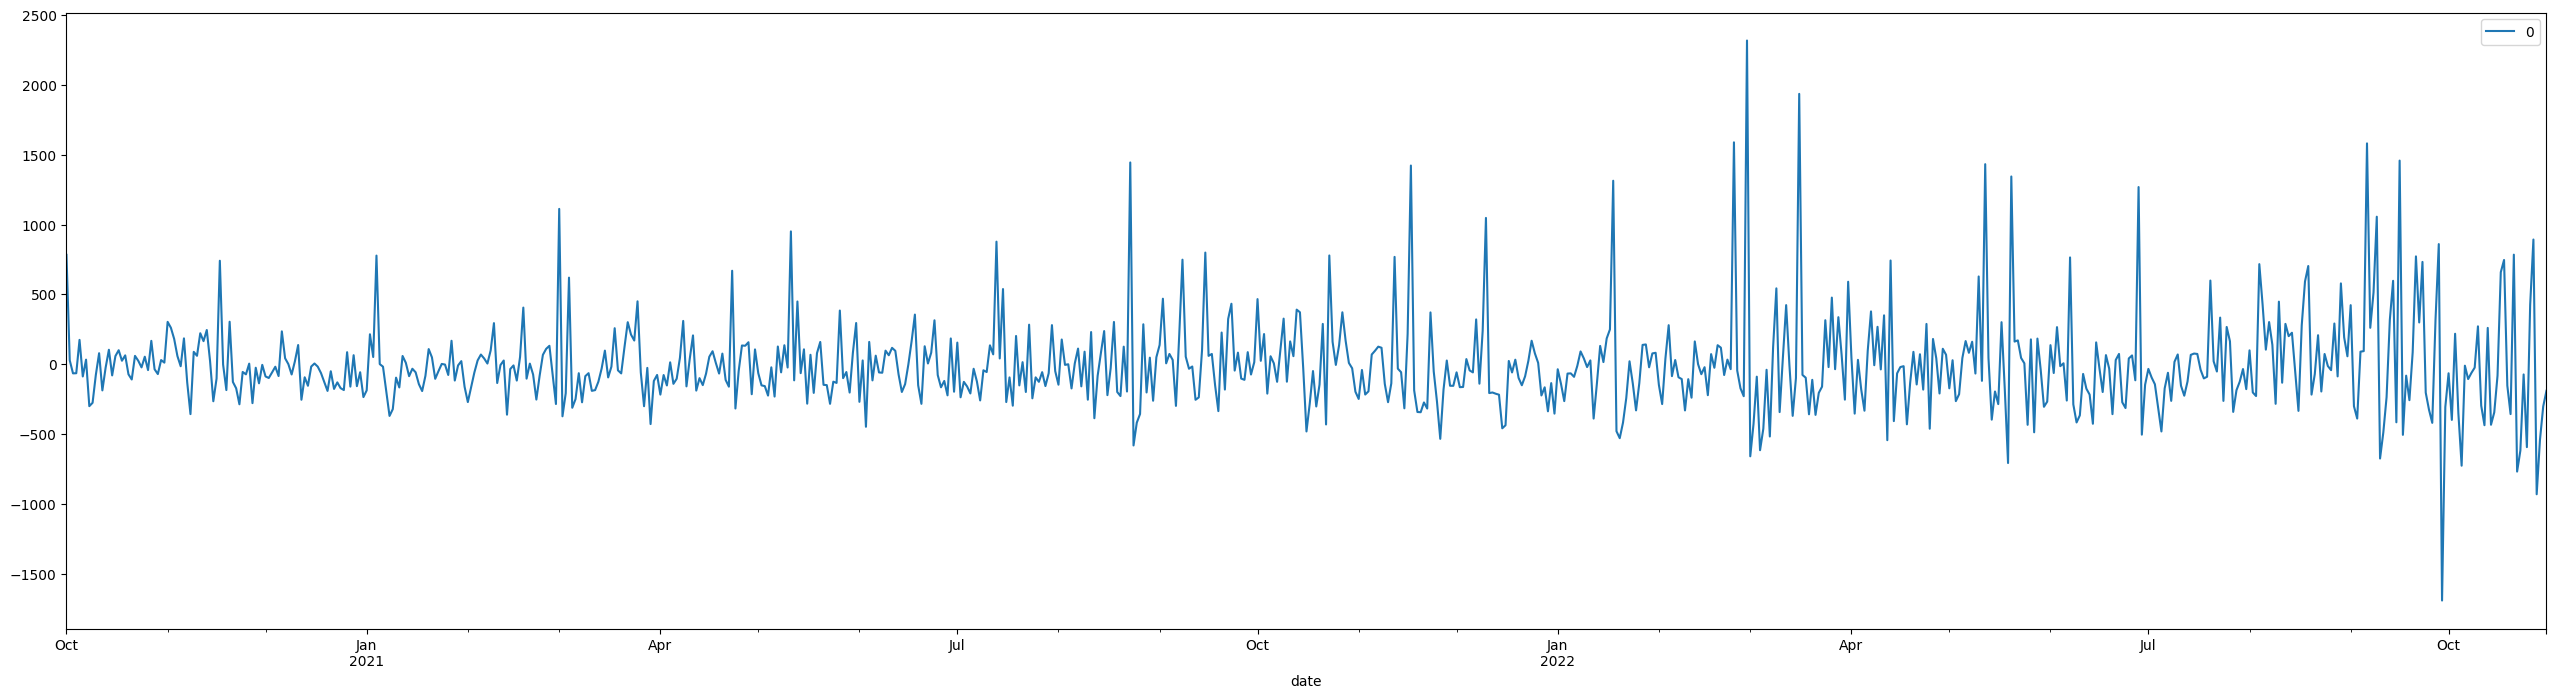

In [ ]:
#Save and line plot the residuals
residuals=pd.DataFrame(model_sarima.resid)
residuals.plot(figsize=(32,8))
plt.show()

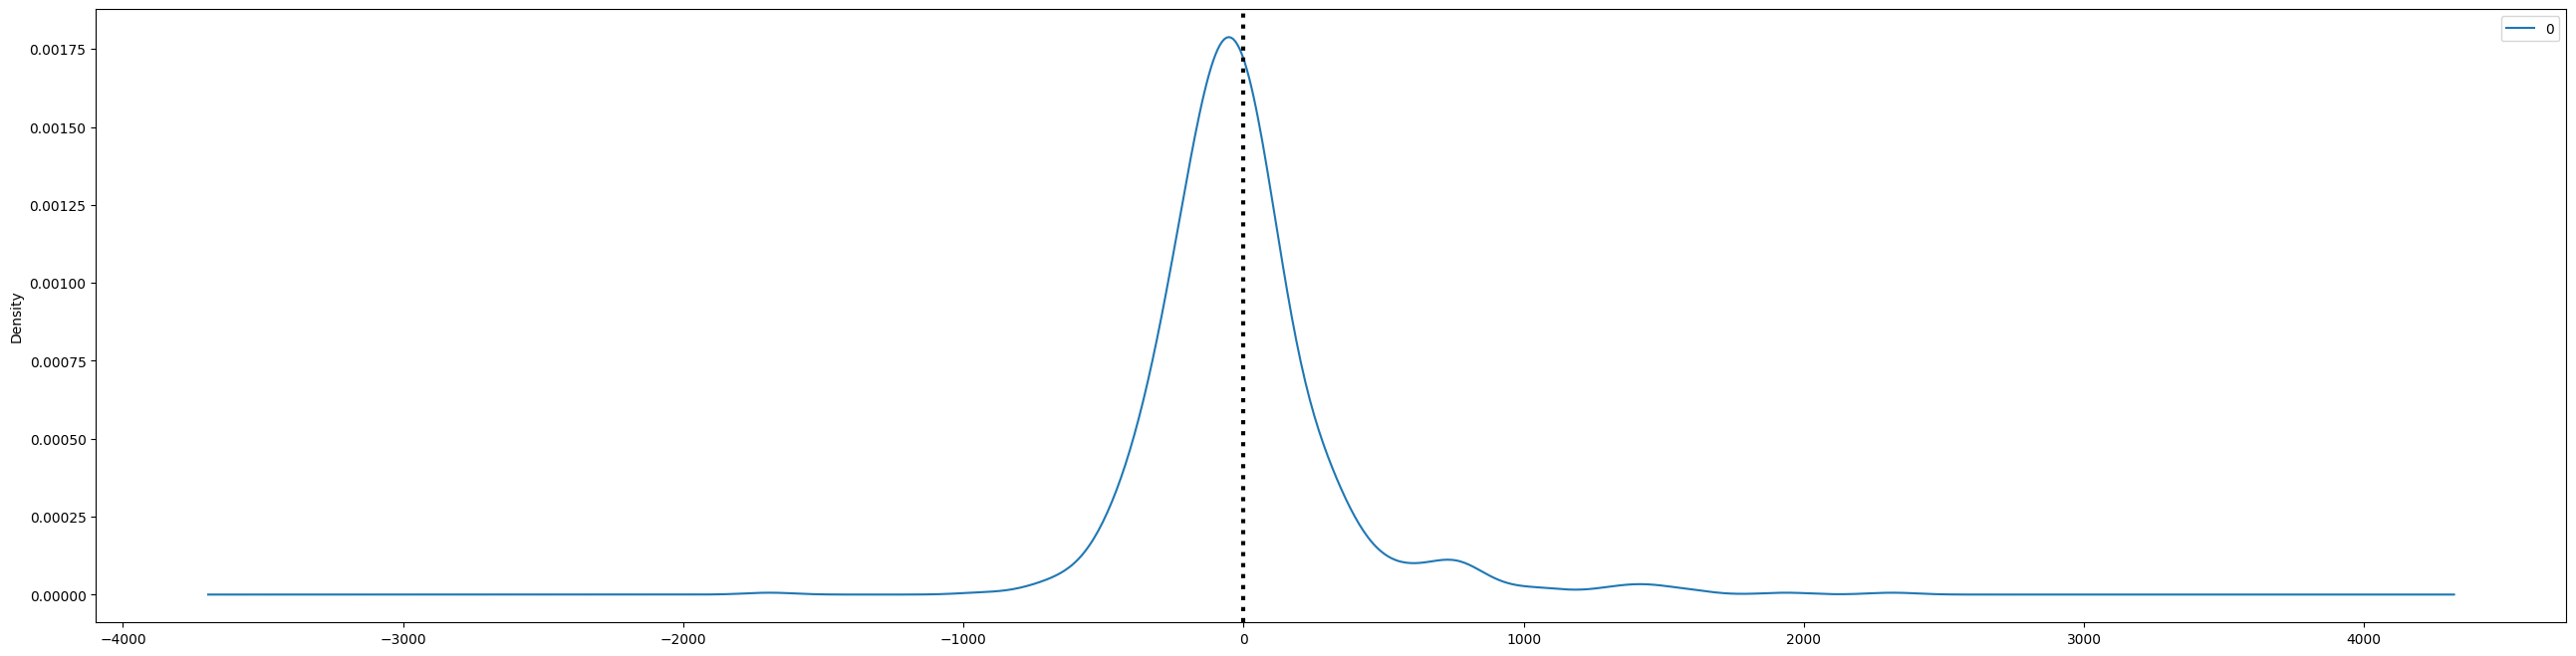

In [ ]:
#Make a density plot of the residuals
residuals.plot(kind='kde', figsize=(32,8))
plt.axvline(x=0, color='black', linewidth=3, label='Zero', linestyle=':')
plt.show()

We should consider by now the first model [(6, 1, 1) (2, 1, 1, 7)] as the best model so far.

Run the Auto SARIMA.

In [ ]:
#Run the Auto SARIMA (caution! This will take some time to run!)
#model=pmdarima.auto_arima(df_train.nbr_purchases,start_p=1,d=1,start_q=0,
#          max_p=5,max_d=1,max_q=5, start_P=0,
#          D=1, start_Q=0, max_P=5,max_D=1,
#          max_Q=5, m=7, seasonal=True,
#          error_action='warn',trace=True,
#          supress_warnings=True,stepwise=True,
#          random_state=20,n_fits=50)

Not used since it would take too much time to run.

## 5.4.

After you've chosen the best model, make 30 day forecasts, store them on a new column `'preds_sarima'` of `df_test` and visualize them alongside the actual `'nbr_purchases'`.

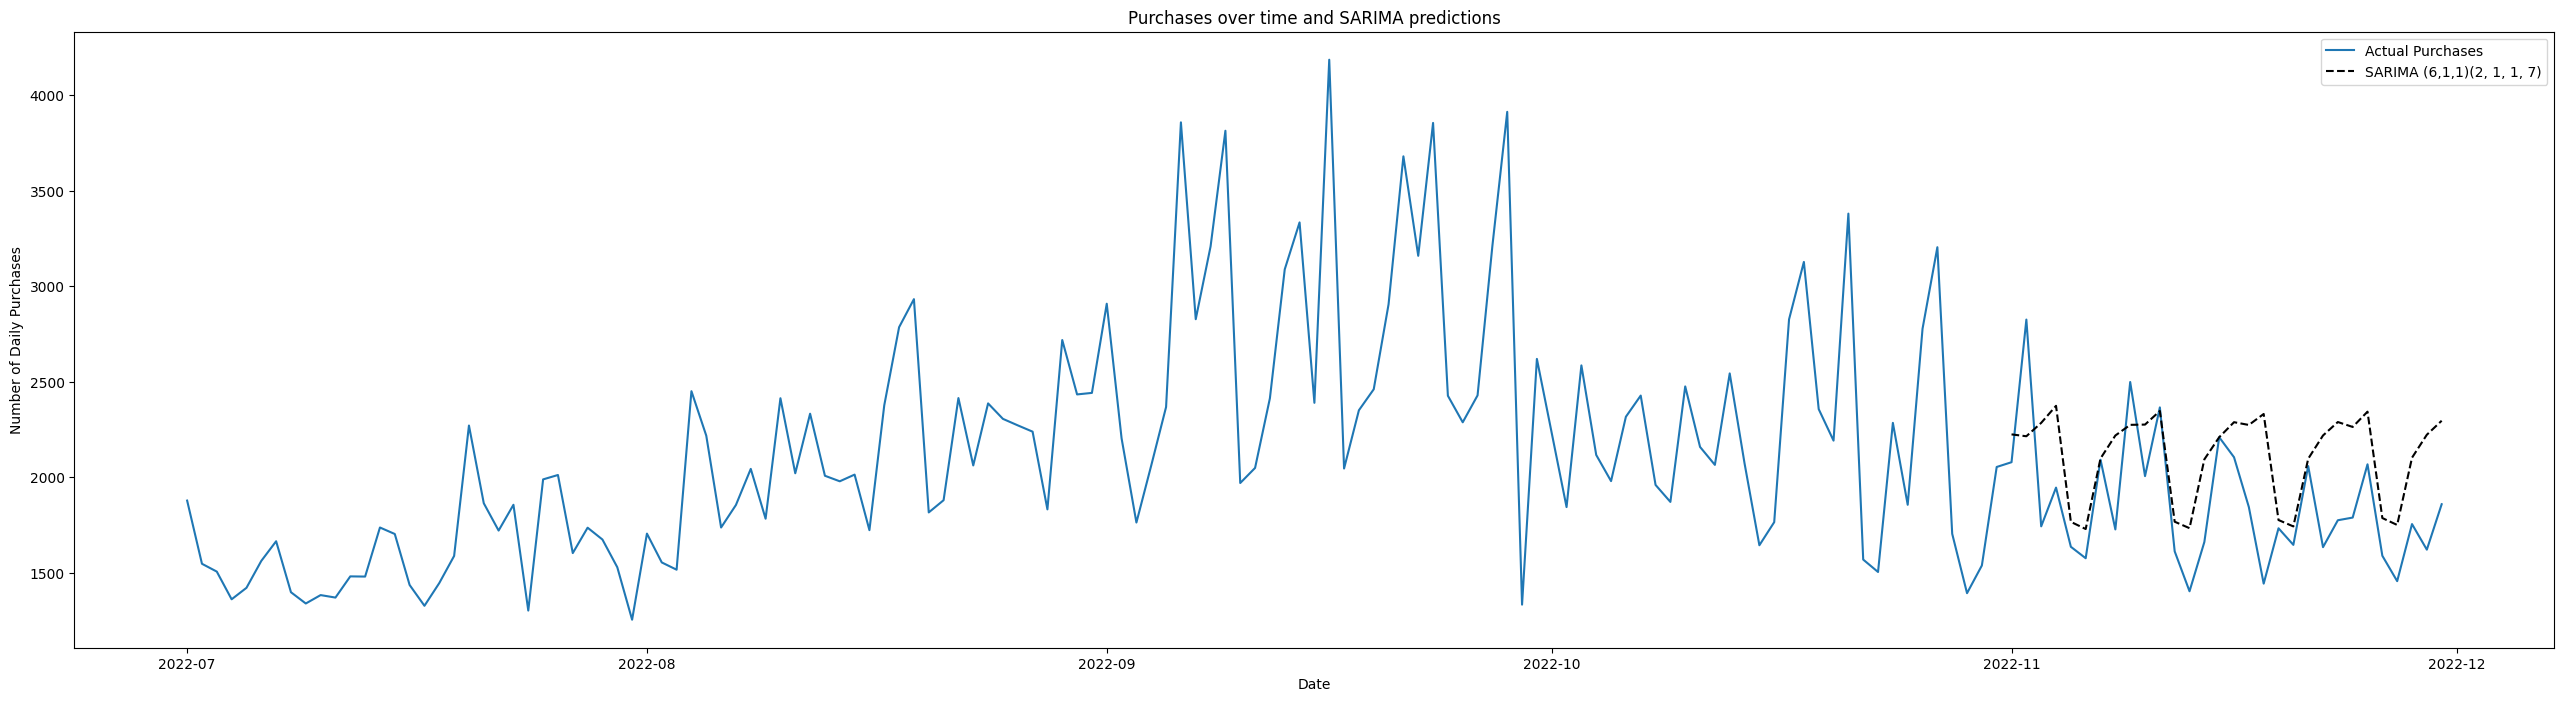


On the test set the RMSE is 379.80
On the test set the MAPE is 17.75%


In [ ]:
#Initialize and fit the best performing model
sarima = SARIMAX(df_train.nbr_purchases,
                 order=(6,1,1),
                 seasonal_order=(2, 1, 1, 7))
model_sarima= sarima.fit()

#Make forecasts, save them to 'preds_sarima' on df_test and calculate the RMSE of the test set
preds_sarima = model_sarima.forecast(30)
df_test['preds_sarima'] = preds_sarima

#Make visualization of forecasts on the test set
plt.figure(figsize=(32,8))
plt.plot(df.loc['2022-07-01':].nbr_purchases, label ='Actual Purchases')
plt.plot(preds_sarima,
         color='black',
         linestyle='--',
         label='SARIMA (6,1,1)(2, 1, 1, 7)')
plt.title('Purchases over time and SARIMA predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_sarima)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_sarima)):.2f}%')

## 5.5.

So far you have been making univariate forecasts, as all information is contained in a single feature. We can however try to leverage more than one feature when making forecasts, so called multivariate.

SARIMAX gives us the possibility to do so by using exogenous variables. An exogenous variable is one that is external to the model, in this case to the `nbr_purchases` time series. The `nbr_website_visits` for example! In some situations, they may add some more information that the model can then incorporate.

However we need to be careful in preparing this data so that it matches the structure of such a system were it to be deployed. Considering we need to make 30 day forecasts, we cannot use exogenous variable datapoints that correspond to the test set period. This means that we need to look at activities from at least 30 days ago to incorporate into a model. That way, to predict day 1 we would consider the website visits from 30 days ago and to predict day 30 we would consider the website visits from the last day of the training set. This ensures we are not making a data leakage error.

In mission 7 we saw that correlation is largest between website visits and purchases when website visits are shifted by 3 days. Given that we need to have a lag of at least 30 days, let's replot the cross-correlation between `nbr_purchases` and `nbr_website_visits`.

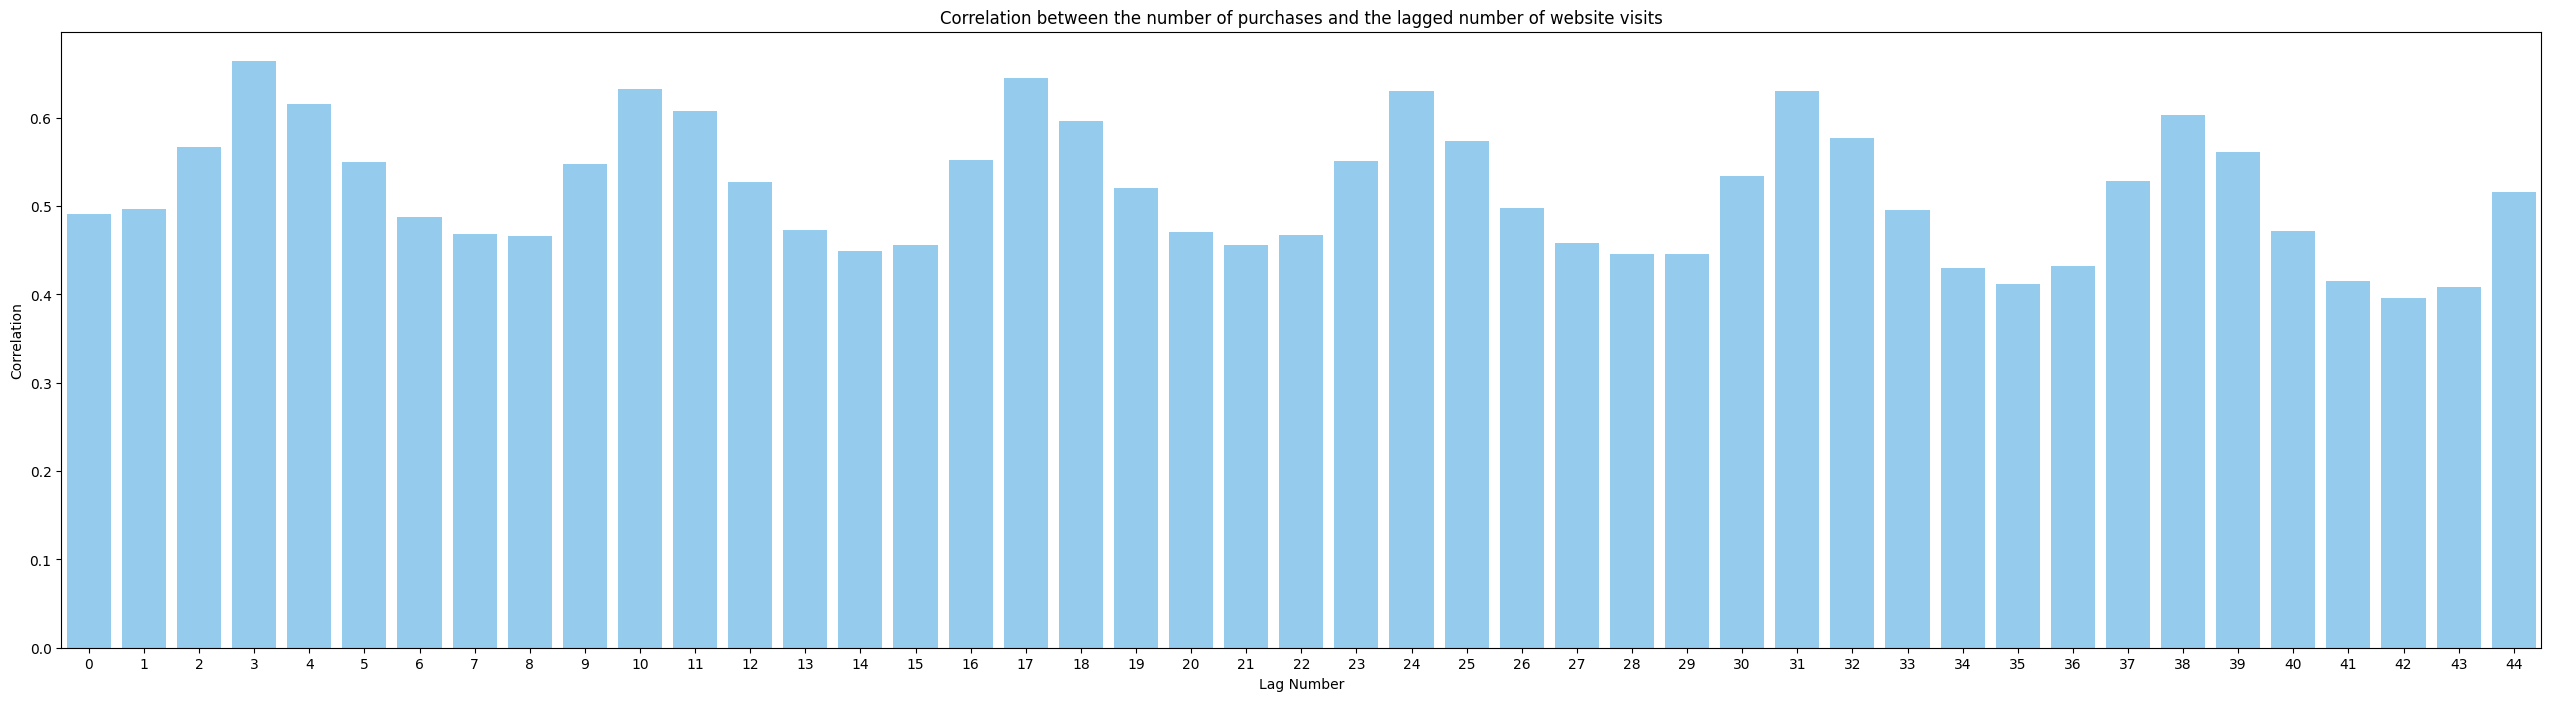

In [ ]:
#Calculate cross-correlation of nbr_purchases and 0 to 30 days lagged versions of nbr_website_visits
list_lags = range(0,45)
list_corr_lags = []
for lag in list_lags:
    tmp_corr = df.nbr_purchases.corr(df.nbr_website_visits.shift(lag))
    list_corr_lags.append(tmp_corr)

df_corr_feats = pd.DataFrame({'lag_nbr':list_lags,'correlation':list_corr_lags})

#Plot the results in a barplot
plt.figure(figsize=(32,8))
sns.barplot(x=df_corr_feats.lag_nbr,y=df_corr_feats.correlation,color='lightskyblue')
plt.xlabel('Lag Number')
plt.ylabel('Correlation')
plt.title('Correlation between the number of purchases and the lagged number of website visits')
plt.show()

After 30 lags, lag 31 is the one that has maximum cross-correlation! This makes sense as we have weekly seasonality (every 7 days we have a local maximum cross-correlation) and an initial maxiumum cross-correlation at lag 3. Therefore, we get 3 + 28 (4 weeks) = 31 days.

By considering the website visits from 31 days ago we therefore ensure that no data leakage exists and that we are choosing the most adequate complementary time series.

Start by shifting the `nbr_website_visits` of the `df` by 31 days and storing it in a new variable called `nbr_website_visits_shifted_31`. Then create a new SARIMAX model using the best hyperparameters you applied in 5.4 but adding a new parameter `exog=` where you pass the `nbr_website_visits_shifted_31` variable, excluding the first 31 rows as well as the last 30 (these correspond to the test set and therefore must not be included in this new Series). This is because shifting a column by 31, produces 31 rows of NaN at the beggining of the dataset that need to be dropped. Pass the `nbr_purchases` of the `df_train` to the SARIMAX but remember to exclude the first 31 rows of this Series as well as otherwise the `nbr_purchases` Series will have more rows than the `nbr_website_visits_shifted_31` that is passed on the `exog=` parameter, resulting in an error.

Save this model to `sarima_exog` and then fit it, storing the fitted model to `sarima_model_exog`.

Finally forecast 30 days using the `sarima_model_exog` model, passing the parameters 30 as well as the `exog=df_train.nbr_website_visits_shifted_31[-30:]` to ensure you give the model the last 30 days of shifted website visits of the training set. Save forecasts to `preds_sarima_exog`. Save these forecasts also to a new column of `df_test` named `preds_sarima_exog`.

Then check the model's summary statistics as well as RMSE and MAPE of the forecasts. How did it behave?

In [ ]:
#Calculate the 31 day shifted nbr_website_visits
nbr_website_visits_shifted_31 = df.nbr_website_visits.shift(31)

#Create the new SARIMA model with exogenous variable and fit. Exclude the first 31 rows from df_train.nbr_purchases and the first 31 rows
#as well as the last 30 from the nbr_website_visits_shifted_31
sarima_exog = SARIMAX(df_train.nbr_purchases[31:],
                 exog=nbr_website_visits_shifted_31[31:-30:],
                 order=(6,1,1),
                 seasonal_order=(2, 1, 1, 7))

model_sarima_exog= sarima_exog.fit()

#Make forecasts, save them to 'preds_sarima_exog' on df_test. Pass exog=nbr_website_visits_shifted_31 with only the last 30 rows.
preds_sarima_exog = model_sarima_exog.forecast(30, exog=nbr_website_visits_shifted_31[-30:])
#Save the forecasts to a new column of df_test called preds_sarima_exog
df_test['preds_sarima_exog'] = preds_sarima_exog

In [ ]:
#Check model statistics
print(model_sarima_exog.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     nbr_purchases   No. Observations:                  730
Model:             SARIMAX(6, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -5281.839
Date:                           Tue, 02 May 2023   AIC                          10587.677
Time:                                   21:22:27   BIC                          10642.662
Sample:                               11-01-2020   HQIC                         10608.902
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
nbr_website_visits     0.0124      0.012      1.004      0.316      -0.012       0.037
ar.L1              

In [ ]:
# Calculate the RMSE/MAPE of the test set
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_sarima_exog)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_sarima_exog)):.2f}%')

On the test set the RMSE is 354.56
On the test set the MAPE is 16.56%


It seems doing a multivariate forecasting in this situation as shown signs of improvment in our model: better values on RMSE, MAPE and AIC values.

# 6. Prophet

## 6.1.

Read reference 1 carefully and create `df_prophet` with the `'date'` and `'nbr_purchases'` informations. You will need it for the next task!

In [ ]:
#Create the df_prophet with correct format
df_prophet = df_train.reset_index().rename(columns={'date':'ds', 'nbr_purchases':'y'})[['ds', 'y']]

## 6.2.

Initialize the model and fit it on `df_prophet` after which you can use it to create a DataFrame called `prophet_future` that can be used to make future 30 day forecasts as well as predicting on the training set. You can see how to do this on the 1st learning content (look for how to make a future dataframe) and setting the correct period using the `period` hyperparameter.

Now, forecast on `prophet_future` and slice it into two distinct DataFrames, one named `preds_prophet_train` with the predictions on the training set and one named `preds_prophet_test` with the forecasts on the test set. Remember that `prophet_future` includes both training and test periods so you will need to separate the last 30 days to achieve this.

Make predictions for 30 days and store the results to a DF named `prophet_forecast`. Make sure this DataSet has the date on the index as is on `df_test`.

Check the RMSE/MAPE on the `preds_prophet_train` and `preds_prophet_test`. Did it perform well? Visualizing is always helpful to understand how a model is forecasting so you should visualize the predictions alongside the actual `'nbr_purchases'`.

In [ ]:
#Initialize and fit the prophet model
model_prophet = prophet.Prophet()
model_prophet.fit(df_prophet)

#Create the prophet_future and prophet_forecast datasets
prophet_future = model_prophet.make_future_dataframe(periods=30, freq='d')
prophet_forecast = model_prophet.predict(prophet_future).set_index('ds')

#Save predictions to preds_prophet_train and preds_prophet_test
preds_prophet_train = prophet_forecast.yhat.iloc[:-30].values
preds_prophet_test = prophet_forecast.yhat.iloc[-30:].values

#Print RMSE/MAPE on training and test sets
print()
print(f'On the train set the RMSE is {np.sqrt(mean_squared_error(df_train.nbr_purchases, preds_prophet_train)):.2f}')
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_prophet_test)):.2f}')
print()
print(f'On the train set the MAPE is {100*(mean_absolute_percentage_error(df_train.nbr_purchases, preds_prophet_train)):.2f}%')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_prophet_test)):.2f}%')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptbfvxx1c/am1hdbuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptbfvxx1c/svh7plo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46428', 'data', 'file=/tmp/tmptbfvxx1c/am1hdbuc.json', 'init=/tmp/tmptbfvxx1c/svh7plo5.json', 'output', 'file=/tmp/tmptbfvxx1c/prophet_model6zt61afg/prophet_model-20230502214222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:42:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:42:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



On the train set the RMSE is 328.29
On the test set the RMSE is 742.09

On the train set the MAPE is 14.62%
On the test set the MAPE is 40.52%


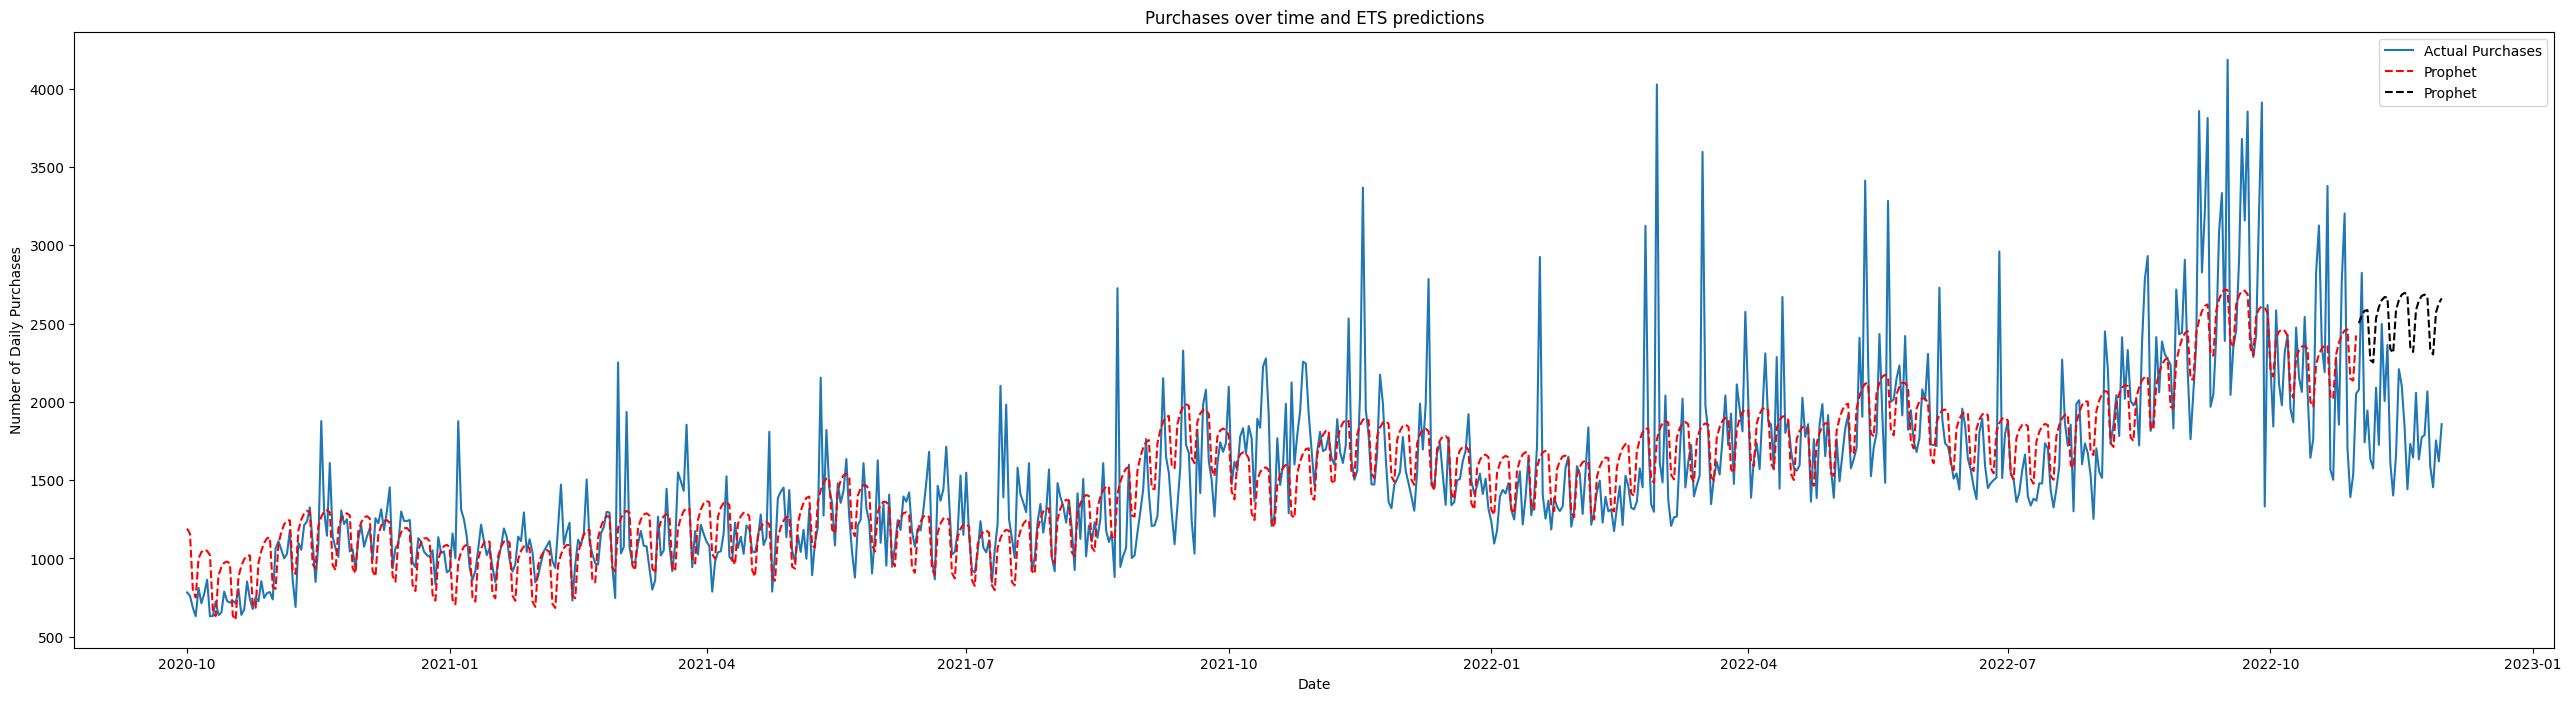


On the test set the RMSE is 742.09
On the test set the MAPE is 40.52%


In [ ]:
#Print the predictions of Prophet on the training and test sets
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Actual Purchases')
plt.plot(pd.DataFrame(preds_prophet_train, index=df_train.index),
         color='red',
         linestyle='--',
         label='Prophet')
plt.plot(pd.DataFrame(preds_prophet_test, index=df_test.index),
         color='black',
         linestyle='--',
         label='Prophet')
plt.title('Purchases over time and ETS predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_prophet_test)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_prophet_test)):.2f}%')

When we get to the test set we can see that it completely differs from the Actual Purchases, which may explain the poor values of RMSE and MAPE.

## 6.3.

So far you have used the standard hyperparameters of Prophet to create the model. As you’ve seen, the results aren’t brilliant.

Prophet can perform better than this, it just needs your help! Try different hyperparameter values and see if you can make it perform better. As usual, make predictions on the training and test sets and evaluate the results via the RMSE/MAPE.

One of the best things about Prophet is that is is quite explainable. It is made up of components that when added together produce the final model and forecasts. So after you find the best performing model, check the components (trend, weekly seasonality, yearly seasonality) that form the Prophet model you just created using the `plot_components` method of the model when applied to `prophet_future`.

Hint: Have a look at the `changepoint_prior_scale`, `changepoint_range` and `weekly_seasonality` hyperparameters and refer to the second and third reading materials.

In [ ]:
#Initialize and fit model with different values on the hyperparameters
model_prophet = prophet.Prophet(changepoint_prior_scale=0.5,
                                changepoint_range = 1,
                                  weekly_seasonality = True)
model_prophet.fit(df_prophet)

#Make forecasts
prophet_pred = model_prophet.make_future_dataframe(periods=30, freq='d')
prophet_forecast = model_prophet.predict(prophet_pred).set_index('ds')

#Save predictions
preds_prophet_train = prophet_forecast.yhat.iloc[:-30].values
preds_prophet_test = prophet_forecast.yhat.iloc[-30:].values

#Print training and test set RMSE/MAPE
print()
print(f'On the train set the RMSE is {np.sqrt(mean_squared_error(df_train.nbr_purchases, preds_prophet_train)):.2f}')
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, preds_prophet_test)):.2f}')
print()
print(f'On the train set the MAPE is {100*(mean_absolute_percentage_error(df_train.nbr_purchases, preds_prophet_train)):.2f}%')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, preds_prophet_test)):.2f}%')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptbfvxx1c/_i323xtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptbfvxx1c/c2ju1a9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44565', 'data', 'file=/tmp/tmptbfvxx1c/_i323xtu.json', 'init=/tmp/tmptbfvxx1c/c2ju1a9b.json', 'output', 'file=/tmp/tmptbfvxx1c/prophet_modelwm6z2cit/prophet_model-20230502215742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:57:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



On the train set the RMSE is 312.73
On the test set the RMSE is 358.87

On the train set the MAPE is 13.23%
On the test set the MAPE is 17.69%


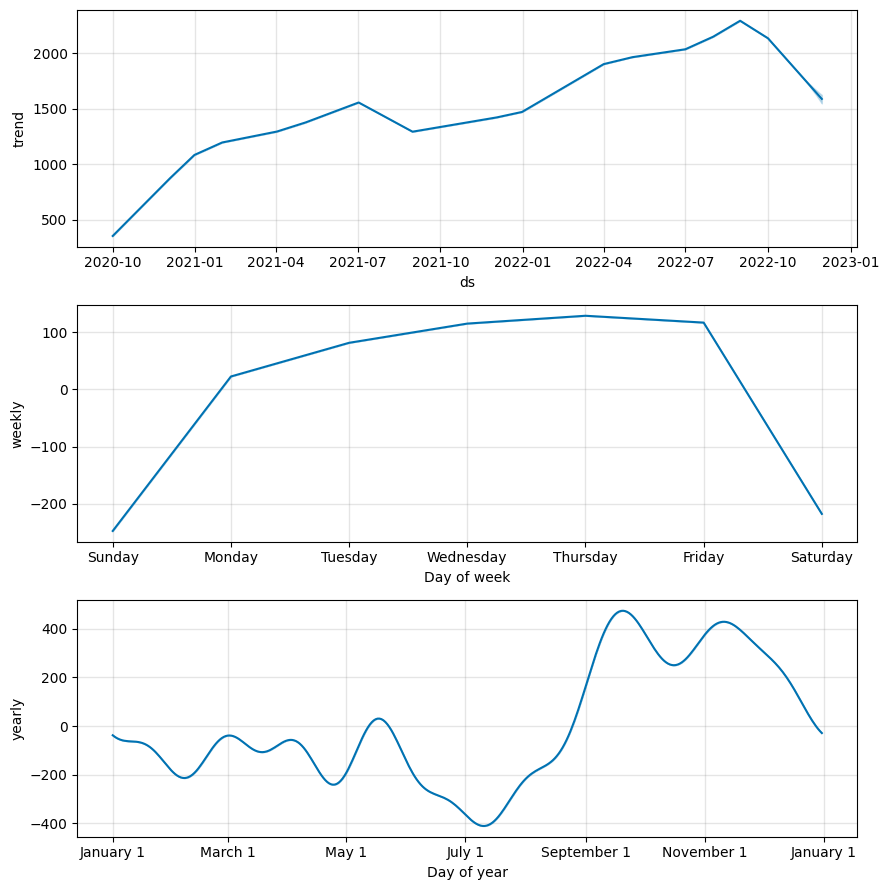

In [ ]:
#Visualize the model components
fig_components = model_prophet.plot_components(model_prophet.predict(prophet_future))

## 6.4.

Save the predictions on the test set to a new column `'preds_prophet'` of the `df_test`. Then visualize them alongside the actual values of `nbr_purchases`.

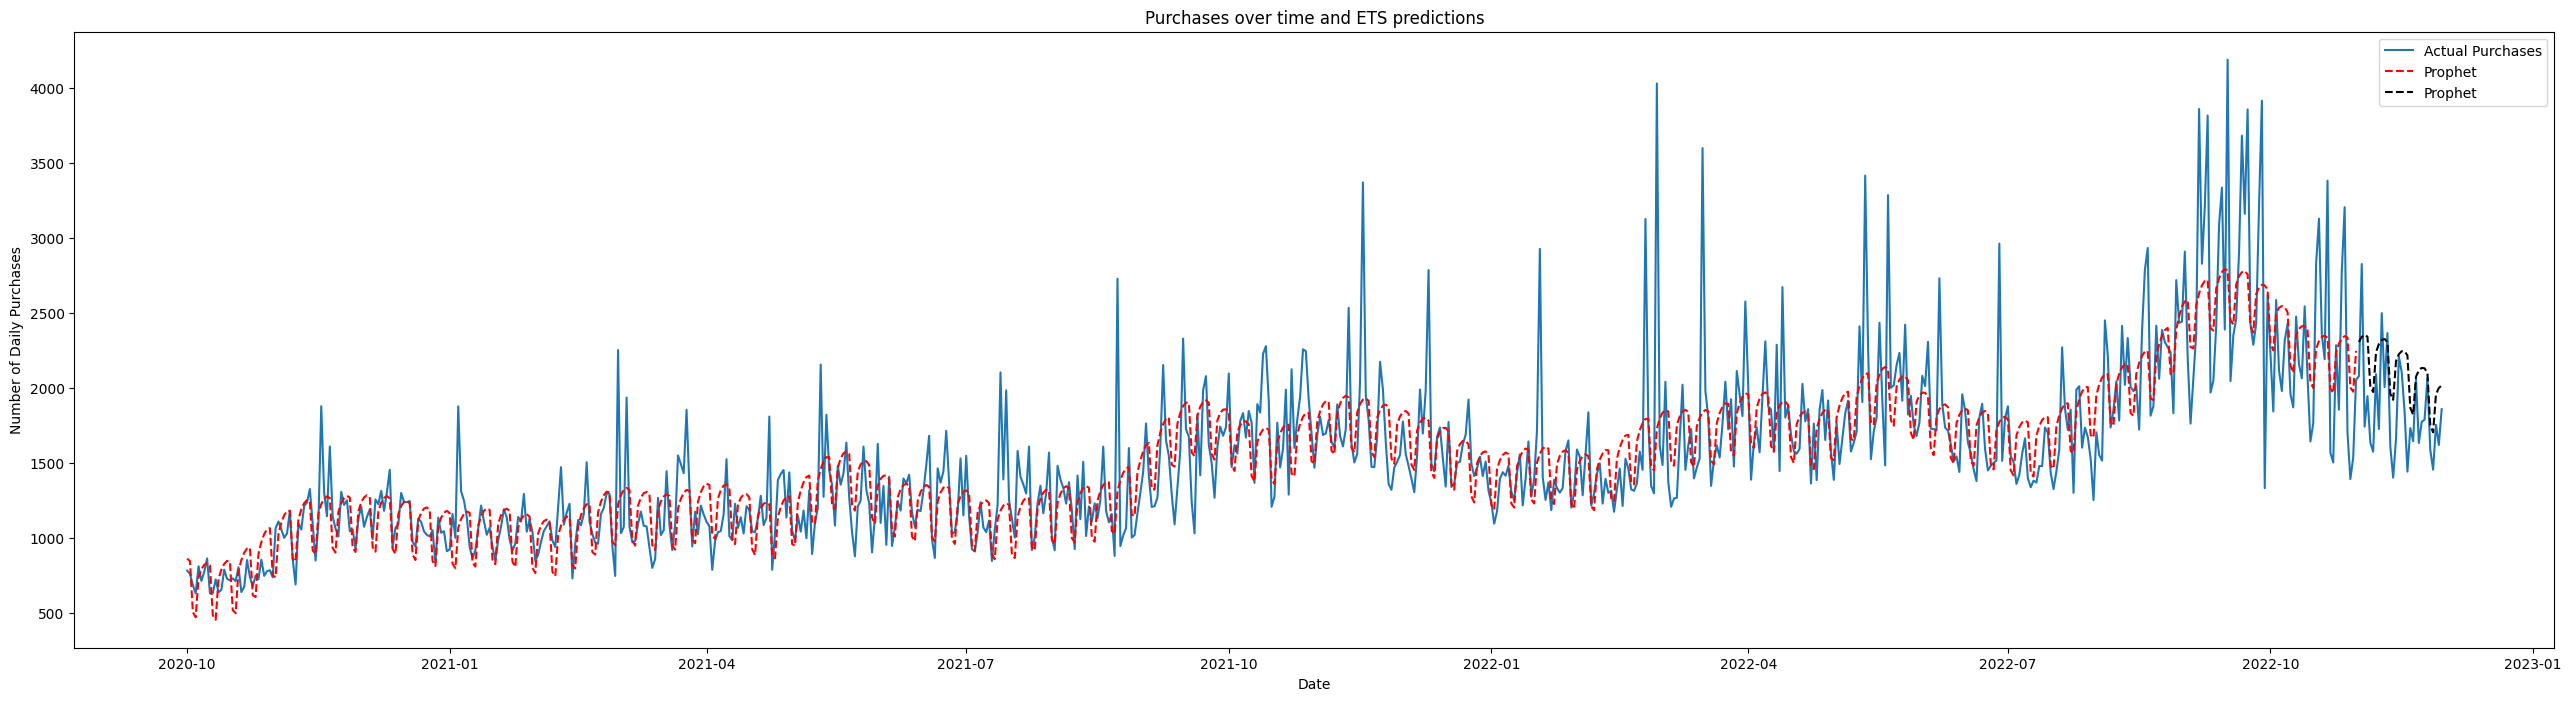


On the test set the RMSE is 358.87
On the test set the MAPE is 17.69%


In [ ]:
#Save the forecasts to 'preds_prophet' on df_test
df_test['preds_prophet'] = preds_prophet_test

#Visualize model's forecasts on the training and test sets
plt.figure(figsize=(32,8))
plt.plot(df.nbr_purchases, label ='Actual Purchases')
plt.plot(pd.DataFrame(preds_prophet_train, index=df_train.index),
         color='red',
         linestyle='--',
         label='Prophet')
plt.plot(df_test.preds_prophet,
         color='black',
         linestyle='--',
         label='Prophet')
plt.title('Purchases over time and ETS predictions')
plt.xlabel('Date')
plt.ylabel('Number of Daily Purchases')
plt.legend()
plt.show()
print()
print(f'On the test set the RMSE is {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_prophet)):.2f}')
print(f'On the test set the MAPE is {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_prophet)):.2f}%')

Now we can see it's following the trend much correctly and when the test set appears it is following its direction.

## 6.5.

It's time to wrap up!

Plot the `nbr_purchases` of `df_train` (from `'2022-07-01'` onwards)and `df_test` alongside all the predictions you've stored on `df_test`: `preds_ses`, `preds_ets`, `preds_arima`, `preds_sarima`, `preds_sarima_exog`, `preds_prophet`. Assign a different colour to each as well as a label to distinguish between them.

Them compare the RMSE and MAPE. Which one would you pick?

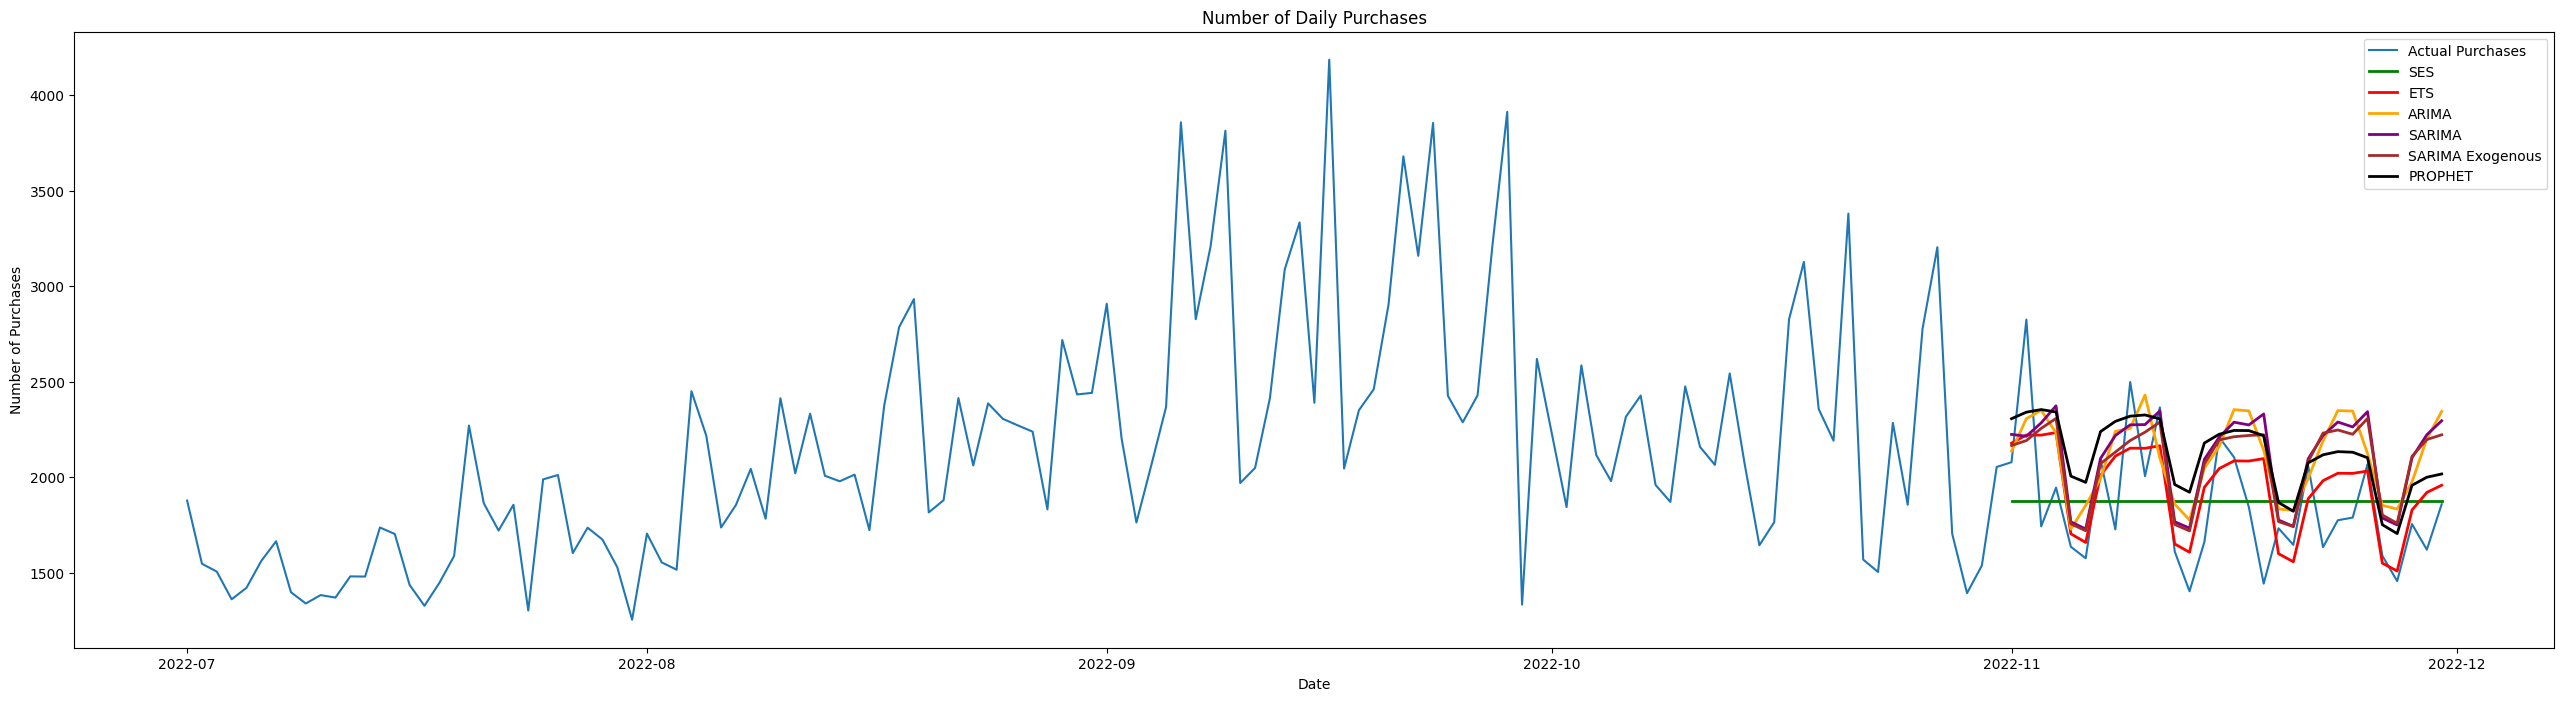


RMSE of SES: 320.43
RMSE of ETS: 263.00
RMSE of ARIMA: 382.24
RMSE of SARIMA: 379.80
RMSE of SARIMA Exogenous: 354.56
RMSE of PROPHET: 358.87

MAPE of SES: 13.92%
MAPE of ETS: 11.34%
MAPE of ARIMA: 18.78%
MAPE of SARIMA: 17.75%
MAPE of SARIMA Exogenous: 16.56%
MAPE of PROPHET: 17.69%


In [ ]:
#Plot all predictions and nbr_purchases
plt.figure(figsize=(32,8))
plt.plot(df.loc['2022-07-01':].nbr_purchases, label ='Actual Purchases')
plt.plot(df_test.preds_ses, label='SES', linewidth=2, color='green')
plt.plot(df_test.preds_ets, label='ETS', linewidth=2, color='red')
plt.plot(df_test.preds_arima, label='ARIMA', linewidth=2, color='orange')
plt.plot(df_test.preds_sarima, label='SARIMA', linewidth=2, color='purple')
plt.plot(df_test.preds_sarima_exog, label='SARIMA Exogenous', linewidth=2, color='brown')
plt.plot(df_test.preds_prophet, label='PROPHET', linewidth=2, color='black')
plt.title('Number of Daily Purchases')
plt.xlabel('Date')
plt.ylabel('Number of Purchases')
plt.legend()
plt.show()

#Print the RMSE of all models on the test sets
print()
print(f'RMSE of SES: {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_ses)):.2f}')
print(f'RMSE of ETS: {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_ets)):.2f}')
print(f'RMSE of ARIMA: {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_arima)):.2f}')
print(f'RMSE of SARIMA: {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_sarima)):.2f}')
print(f'RMSE of SARIMA Exogenous: {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_sarima_exog)):.2f}')
print(f'RMSE of PROPHET: {np.sqrt(mean_squared_error(df_test.nbr_purchases, df_test.preds_prophet)):.2f}')

#Print the MAPE of all models on the test sets
print()
print(f'MAPE of SES: {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_ses)):.2f}%')
print(f'MAPE of ETS: {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_ets)):.2f}%')
print(f'MAPE of ARIMA: {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_arima)):.2f}%')
print(f'MAPE of SARIMA: {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_sarima)):.2f}%')
print(f'MAPE of SARIMA Exogenous: {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_sarima_exog)):.2f}%')
print(f'MAPE of PROPHET: {100*(mean_absolute_percentage_error(df_test.nbr_purchases, df_test.preds_prophet)):.2f}%')

**ANSWER:** ETS shows signs of being the best performer model, comparing its values of RMSE and MAPE with all the others.